# Optimise on a big dataframe with filters

In [1]:
import multiprocessing
import os 
from __future__ import print_function
import pybobyqa
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

# Filter measurement

In [3]:
start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/small_df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [4]:
filenames

['df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle']

In [11]:
new_df = pd.DataFrame()
    
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        print(filenames[i])
    new_df = pd.concat([new_df,df])

df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle


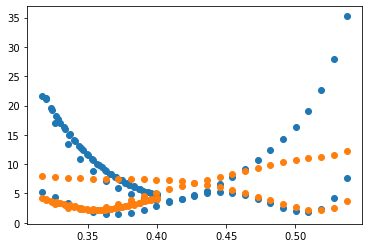

In [6]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01, new_df.sigH)
ax.scatter(new_df.k_qfn01, new_df.sigV)

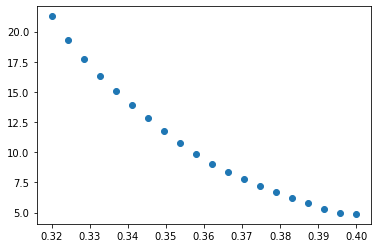

In [7]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[0:20], new_df.sigH[0:20])
# ax.scatter(new_df.k_qfn01, new_df.sigV)

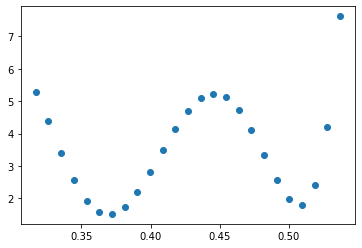

In [16]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[20:45], new_df.sigH[20:45])
# ax.scatter(new_df.k_qfn01, new_df.sigV)

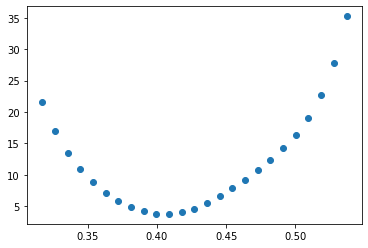

In [17]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[45:70], new_df.sigH[45:70])
# ax.scatter(new_df.k_qfn01, new_df.sigV)

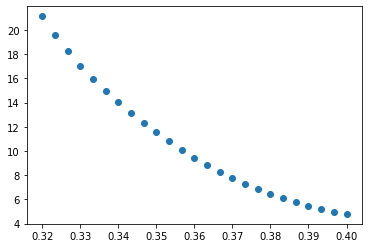

In [18]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01[70:95], new_df.sigH[70:95])
# ax.scatter(new_df.k_qfn01, new_df.sigV)

# Open large df

In [18]:
start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/large_df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [19]:
filenames

['df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle']

In [20]:
df = pd.DataFrame()
    
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df_i = pickle.load(handle)
        print(filenames[i])
    df = pd.concat([df,df_i])

df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle
df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle


# Optimize on a dataframe

In [4]:
header_read, twiss_read = read_twiss_file('/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction/tfs/fast_extraction.twiss')
gamma = header_read["gamma"]
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread
Brho = 24*3.3356

quad_current = {
    "QFN01": 620,
    "QDN02": 404,
    "QFN03": 378,
}
quad_length = {
    "QFN01": 0.74,
    "QDN02": 1.2,
    "QFN03": 1.2,
}

# Py-Bobyqua with multiprocessing

[ 1.31498943e+02  1.48439928e+02 -1.36646367e+01  1.40066653e+01
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]
2744.7712986903625
[ 1.50000000e+02  1.48439928e+02 -1.36646367e+01  1.40066653e+01
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]
2826.4288477979944
[ 1.31498943e+02  1.50000000e+02 -1.36646367e+01  1.40066653e+01
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]
2820.5234298383402
[ 1.31498943e+02  1.48439928e+02  8.63353633e+01  1.40066653e+01
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]
14352.008879710298
[ 1.31498943e+02  1.48439928e+02 -1.36646367e+01  1.00000000e+02
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]
5214.276028859199
[ 1.31

2818.4265537163037
[ 1.31629356e+02  1.48326577e+02 -1.33976988e+01  1.42567477e+01
 -4.88086149e+01 -9.38852894e+00 -9.45579760e+01 -2.52832489e+01
  3.93514072e-07  1.35481036e-07  6.02343761e-06]
3064.5144122348347
[ 1.31567524e+02  1.48790201e+02 -1.31406401e+01  1.35258057e+01
 -4.88463603e+01 -1.04352445e+01 -9.46692087e+01 -2.53932357e+01
  3.92446534e-07  1.18306086e-07  8.42625880e-06]
3030.365331268894
[ 1.31567838e+02  1.48604872e+02 -1.42476842e+01  1.35448237e+01
 -4.88294100e+01 -9.90295363e+00 -9.45610339e+01 -2.57043056e+01
  3.93470812e-07  1.14393947e-07  5.88781230e-06]
3124.912164993448
[ 1.31518282e+02  1.48450380e+02 -1.36833336e+01  1.40192494e+01
 -4.89261144e+01 -1.01540532e+01 -9.44769108e+01 -2.55009233e+01
  3.95449261e-07  1.26000603e-07  1.73232799e-05]
19601.705304385592
[ 1.31494974e+02  1.48267437e+02 -1.36593229e+01  1.38110841e+01
 -4.89097453e+01 -1.09777190e+01 -9.43790411e+01 -2.55095595e+01
  3.96121372e-07  1.38344456e-07  6.34001205e-06]
2957.17

2819.8841715070043
[ 1.31499146e+02  1.48439860e+02 -1.36639734e+01  1.40070206e+01
 -4.89185670e+01 -1.01615409e+01 -9.44758377e+01 -2.54985468e+01
  3.95479305e-07  1.26588288e-07  7.33440211e-06]
2819.977592691384
[ 1.31498897e+02  1.48439904e+02 -1.36651769e+01  1.40064599e+01
 -4.89184581e+01 -1.01618268e+01 -9.44766699e+01 -2.54983316e+01
  3.95469533e-07  1.26572529e-07  7.33583128e-06]
2819.9853247865194
[ 1.31498889e+02  1.48440287e+02 -1.36641901e+01  1.40062221e+01
 -4.89184525e+01 -1.01613351e+01 -9.44766132e+01 -2.54982745e+01
  3.95476187e-07  1.26585348e-07  7.33136674e-06]
2819.9365497340896
[ 1.31498809e+02  1.48439731e+02 -1.36647825e+01  1.40064030e+01
 -4.89186489e+01 -1.01610069e+01 -9.44757623e+01 -2.54986266e+01
  3.95480927e-07  1.26566959e-07  7.33008477e-06]
2819.911428793143
[ 1.31499273e+02  1.48439762e+02 -1.36650659e+01  1.40066378e+01
 -4.89182937e+01 -1.01614259e+01 -9.44761506e+01 -2.54987978e+01
  3.95473331e-07  1.26587257e-07  7.32801207e-06]
2819.89

2819.959003190193
[ 1.31498944e+02  1.48439928e+02 -1.36646380e+01  1.40066651e+01
 -4.89184917e+01 -1.01613541e+01 -9.44761443e+01 -2.54984336e+01
  3.95472508e-07  1.26579534e-07  7.33345756e-06]
2819.959056075851
[ 1.31498943e+02  1.48439928e+02 -1.36646358e+01  1.40066656e+01
 -4.89184911e+01 -1.01613553e+01 -9.44761443e+01 -2.54984336e+01
  3.95472515e-07  1.26579557e-07  7.33345833e-06]
2819.959088278861
[ 1.31498944e+02  1.48439927e+02 -1.36646365e+01  1.40066664e+01
 -4.89184913e+01 -1.01613544e+01 -9.44761438e+01 -2.54984345e+01
  3.95472549e-07  1.26579517e-07  7.33345854e-06]
2819.959070080481
[ 1.31498942e+02  1.48439928e+02 -1.36646360e+01  1.40066650e+01
 -4.89184914e+01 -1.01613536e+01 -9.44761435e+01 -2.54984336e+01
  3.95472537e-07  1.26579520e-07  7.33346072e-06]
2819.959099405941
[ 1.31498943e+02  1.48439929e+02 -1.36646371e+01  1.40066651e+01
 -4.89184910e+01 -1.01613554e+01 -9.44761442e+01 -2.54984349e+01
  3.95472540e-07  1.26579522e-07  7.33344557e-06]
2819.95890

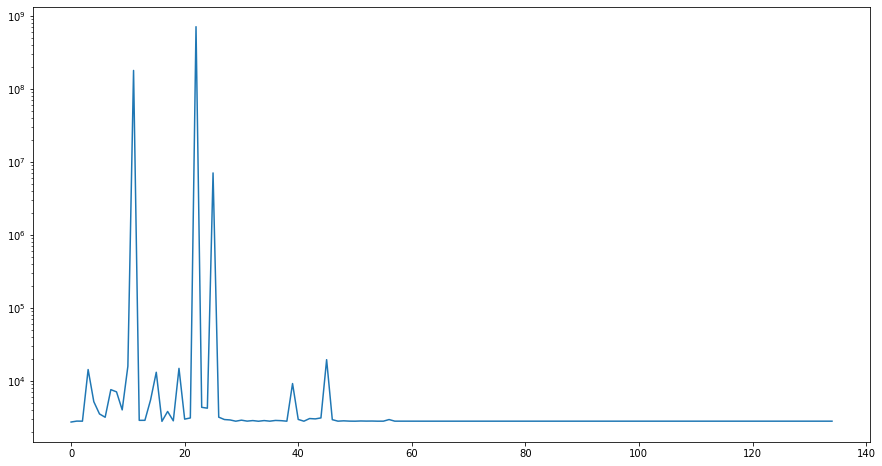

In [46]:
# Py-BOBYQA example: minimize the Rosenbrock function


exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################


madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

btv="f61.btv010"

progress_obj = []
progress_params = []
# Define the objective function
def f_fit(params):
    global progress_obj
    print(params)
    betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params
    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

        
    def worker1(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1, return_dict1V))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2, return_dict2V))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3, return_dict3V))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4, return_dict4V))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_H_madx"]=madx_sigma_list
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1V.values())
        madx_sigma_list.extend(return_dict2V.values())
        madx_sigma_list.extend(return_dict3V.values())
        madx_sigma_list.extend(return_dict4V.values())
        
        new_df["sigma_V_madx"]=madx_sigma_list
        
        
        objective = sum(
            abs(
                new_df["sigma_H_madx"]-new_df["sigH"])**2 + (new_df["sigma_V_madx"]-new_df["sigV"])**2
                )
        

    print (objective)
    progress_obj.append(objective)
    progress_params.append(params)
    
    with open('filename.pickle', 'wb') as handle:
        pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('params2.pickle', 'wb') as handle:
        pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)


    return (objective)

# Define the starting point

# Open the last params that work, a way to save progress of optimisation
with open('params2.pickle', 'rb') as handle:
            params = pickle.load(handle)
        
initial_guess = [82.4, 33.2, -11.1, 0.28, 0.13, 0.0, 0.02, 0.0, 1.5e-6, 1.5e-6, 7.53e-4]
initial_guess = params[-1]


# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, -100, -100, -100, -100, 0.0, 0.0, 0.0])
upper = np.array([150, 150, 100, 100, 100, 100, 100, 100, 5.0e-6, 5.0e-6, 20.0e-4])


# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-8, maxfun=1000)

# Display output
print(soln)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(progress_obj)
ax.set_yscale('log')

# Try solution

In [47]:
soln.x

array([ 1.31498943e+02,  1.48439928e+02, -1.36646367e+01,  1.40066653e+01,
       -4.89184913e+01, -1.01613546e+01, -9.44761435e+01, -2.54984341e+01,
        3.95472530e-07,  1.26579533e-07,  7.33345453e-06])

In [48]:
# New initial conditions East Area
betx0 = soln.x[0]
bety0 = soln.x[1]
alfx0 = soln.x[2]
alfy0 = soln.x[3]
Dx0 = soln.x[4]
Dy0 = soln.x[5]
Dpx0 = soln.x[6]
Dpy0 = soln.x[7]
exn = soln.x[8]
eyn = soln.x[9]
sige = soln.x[10]

In [23]:
with open('params2.pickle', 'rb') as handle:
    params = pickle.load(handle)
print(params[-1])
    
# New initial conditions East Area
betx0 = params[-1][0]
bety0 = params[-1][1]
alfx0 = params[-1][2]
alfy0 = params[-1][3]
Dx0 = params[-1][4]
Dy0 = params[-1][5]
Dpx0 = params[-1][6]
Dpy0 = params[-1][7]
exn = params[-1][8]
eyn = params[-1][9]
sige = params[-1][10]

[ 1.31498943e+02  1.48439928e+02 -1.36646367e+01  1.40066653e+01
 -4.89184913e+01 -1.01613546e+01 -9.44761435e+01 -2.54984341e+01
  3.95472530e-07  1.26579533e-07  7.33345453e-06]


In [25]:
betx0 = 147
bety0 = 4.6
alfx0 = -41
alfy0 = 0.06
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 4.92e-6
eyn = 3.4e-6
sige = 0.000412

# Comparison between all acquisitions and MADX with matched initial conditions

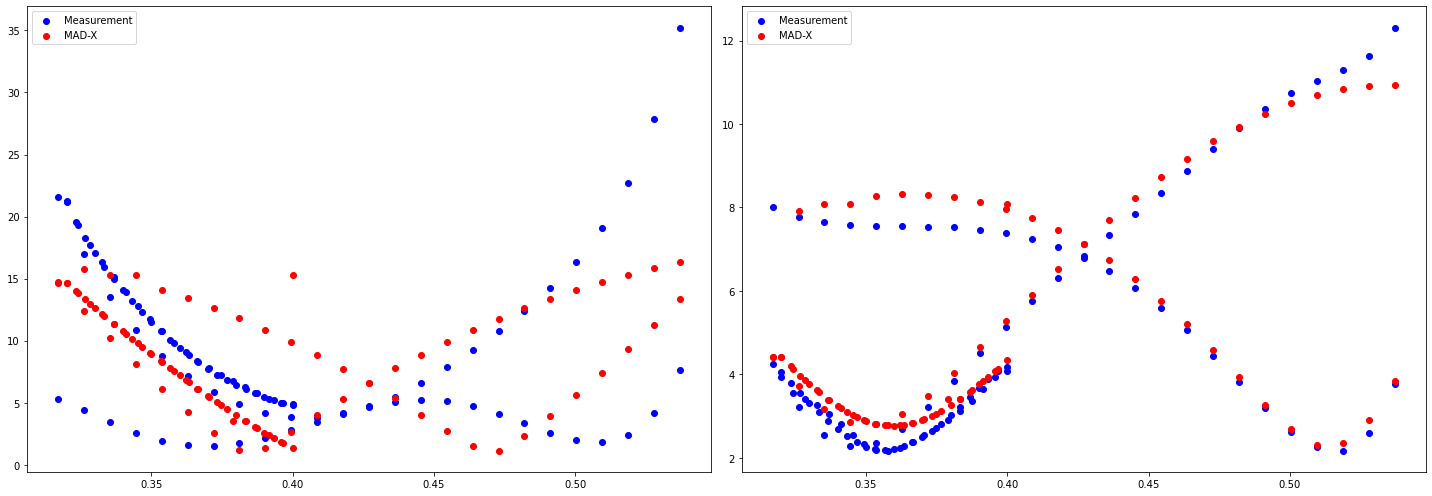

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,7), tight_layout=True)
ax[0].scatter(new_df.k_qfn01, new_df.sigH, color="b", label="Measurement")
ax[0].scatter(new_df.k_qfn01, new_df.sigma_H_madx, color="r", label="MAD-X")

ax[1].scatter(new_df.k_qfn01, new_df.sigV, color="b", label="Measurement")
ax[1].scatter(new_df.k_qfn01, new_df.sigma_V_madx, color="r", label="MAD-X")

ax[0].legend()
ax[1].legend()

Text(0.7, 0.8, 'Matched initial parameters:\n$\\beta_{x}$=147\n$\\beta_{y}$=4.6\n$\\alpha_{x}$=-41\n$\\alpha_{y}$=0.06\n$D_{x}$=0.13\n$D_{y}$=0.0\n$D_{px}$=0.02\n$D_{py}$=0.0\n$exn$=4.92e-06\n$eyn$=3.4e-06\n$\\frac{dp}{p}$=0.000412')

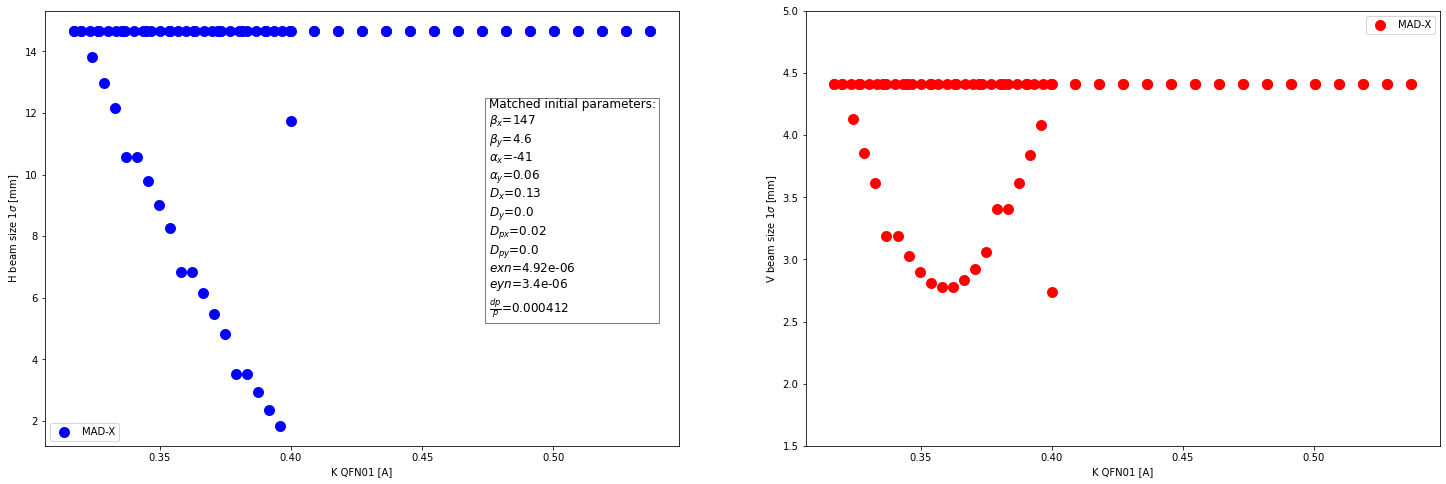

In [50]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for idx in list(new_df.index.values):
    k_qfn01 = new_df.k_qfn01[idx]
    k_qdn02 = new_df.k_qdn02[idx]
    k_qfn03 = new_df.k_qfn03[idx]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

# df_acq = df[df.Acqu==2].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")


# df_acq = df[df.Acqu==3].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="cornflowerblue", s=20, label="Acq 3", zorder=99)
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="tomato", s=20, label="Acq 3", zorder=99)

# df_acq = df[df.Acqu==4].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

# df_acq = df[df.Acqu==5].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=5, zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=5, zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
ax[1].set_ylim(1.5, 5)

# Box with initial parameters
# textstr = '\n'.join((
#     "Matched initial parameters:",
#     r'$\beta_{x}$='+str(round(betx0,3)),
#     r'$\beta_{y}$='+str(round(bety0,3)),
#     r'$\alpha_{x}$='+str(round(alfx0,3)),
#     r'$\alpha_{y}$='+str(round(alfy0,3)),
#     r'$D_{x}$='+str(round(Dx0,3)),
#     r'$D_{y}$='+str(round(Dy0,3)),
#     r'$D_{px}$='+str(round(Dpx0,3)),
#     r'$D_{py}$='+str(round(Dpy0,3)),
#     r'$exn$='+str(round(exn,8)),
#     r'$eyn$='+str(round(eyn,8)),
#     r'$\frac{dp}{p}$='+str(round(sige,6)),
#     ))

# props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# fig.suptitle(f"{subset_dirnames}")
# plt.savefig("fig/quad_scan_filter_pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight') 

# ####################
# OTHER TECHNIQUES
# ####################

# Optimise with Dispersion values set constant from codilog values

In [12]:
# Py-BOBYQA example: minimize the Rosenbrock function
from __future__ import print_function
import pybobyqa

exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

#################################### Initialize MADX ####################################
import multiprocessing
import os 

madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

btv="f61.btv010"

progress_obj = []
progress_params = []
# Define the objective function
def f_fit(params):
    global progress_obj
    print(params)
    betx0, bety0, alfx0, alfy0, exn, eyn, sige = params
    
    dx0 = 0.13
    dy0 = 0.0
    dpx0 = 0.02
    dpy0 = 0
    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

        
    def worker1(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1, return_dict1V))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2, return_dict2V))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3, return_dict3V))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4, return_dict4V))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_H_madx"]=madx_sigma_list
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1V.values())
        madx_sigma_list.extend(return_dict2V.values())
        madx_sigma_list.extend(return_dict3V.values())
        madx_sigma_list.extend(return_dict4V.values())
        
        new_df["sigma_V_madx"]=madx_sigma_list
        
        
        objective = sum(
            abs(
                new_df["sigma_H_madx"]-new_df["sigH"])**2 + (new_df["sigma_V_madx"]-new_df["sigV"])**2
                )
        

    print (objective)
    progress_obj.append(objective)
    progress_params.append(params)
    
    with open('progress_dispersion_fixed.pickle', 'wb') as handle:
        pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('params_dispersion_fixed.pickle', 'wb') as handle:
        pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)


    return (objective)

# Define the starting point

# Open the last params that work, a way to save progress of optimisation
with open('params_dispersion_fixed.pickle', 'rb') as handle:
            params = pickle.load(handle)
        
initial_guess = [82.4, 33.2, -11.1, 0.28, 1.5e-6, 1.5e-6, 7.53e-4]
# initial_guess = [230, 7, -55, -0.024, 5e-6, 2.33e-6, 0.0015]
# initial_guess = params[-1]
# initial_guess = soln.x

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, 1, -100, -100, 0.0, 0.0, 0.0])
upper = np.array([300, 150, 100, 100, 5.0e-5, 5.0e-5, 20.0e-4])

# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-8, maxfun=100000)

# Display output
print(soln)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(progress_obj)
ax.set_yscale('log')

[ 8.24e+01  3.32e+01 -1.11e+01  2.80e-01  1.50e-06  1.50e-06  7.53e-04]
8068.394924236925
[ 2.319e+02  3.320e+01 -1.110e+01  2.800e-01  1.500e-06  1.500e-06
  7.530e-04]
7437.301217332812
[ 8.240e+01  1.077e+02 -1.110e+01  2.800e-01  1.500e-06  1.500e-06
  7.530e-04]
15051.845989477071
[8.24e+01 3.32e+01 8.89e+01 2.80e-01 1.50e-06 1.50e-06 7.53e-04]
102007.6034767501
[ 8.24e+01  3.32e+01 -1.11e+01  1.00e+02  1.50e-06  1.50e-06  7.53e-04]
592457.7856995343
[ 8.24e+01  3.32e+01 -1.11e+01  2.80e-01  2.65e-05  1.50e-06  7.53e-04]
17091.522877905205
[ 8.24e+01  3.32e+01 -1.11e+01  2.80e-01  1.50e-06  2.65e-05  7.53e-04]
79117.1362354485
[ 8.240e+01  3.320e+01 -1.110e+01  2.800e-01  1.500e-06  1.500e-06
  1.753e-03]
7877.2648232717975
[ 1.00e+00  3.32e+01 -1.11e+01  2.80e-01  1.50e-06  1.50e-06  7.53e-04]
84560.84016215845
[ 8.24e+01  1.00e+00 -1.11e+01  2.80e-01  1.50e-06  1.50e-06  7.53e-04]
7615.343981170384
[ 8.24e+01  3.32e+01 -1.00e+02  2.80e-01  1.50e-06  1.50e-06  7.53e-04]
53259.035

5388.392961535478
[ 2.31023862e+02  2.21084239e+01  6.55198271e-01 -1.71503893e+00
  4.71753559e-07  6.38281442e-07  9.01102576e-04]
5367.654738909329
[ 2.30990377e+02  2.21277796e+01  6.24523126e-01 -1.71416889e+00
  4.71980350e-07  6.37950605e-07  9.00788903e-04]
5369.697113834638
[ 2.30919193e+02  2.20720206e+01  6.78474694e-01 -1.71013256e+00
  4.62394915e-07  6.43920751e-07  9.00949428e-04]
5381.807936950684
[ 2.31145250e+02  2.21264647e+01  6.50404979e-01 -1.70601574e+00
  4.83848927e-07  6.34889911e-07  9.01241005e-04]
5349.074249137062
[ 2.31181924e+02  2.21925763e+01  7.88218700e-01 -1.50384764e+00
  5.58614869e-07  6.36568591e-07  9.01707332e-04]
5262.414946841394
[ 2.31191364e+02  2.20928008e+01  7.82247748e-01 -1.65520689e+00
  6.42021134e-07  6.16808432e-07  9.02097892e-04]
5245.422090543932
[ 2.31598675e+02  2.21607319e+01  8.08198045e-01 -1.45715858e+00
  6.61808301e-07  5.88725880e-07  9.03464583e-04]
5256.961982408235
[ 2.31213478e+02  2.21270055e+01  8.70271389e-01 -1

4060.022622448085
[ 1.93321128e+02  1.79099276e+01  3.15041690e+01 -1.10773590e+00
  3.31805303e-07  8.13479751e-07  8.53013755e-04]
4057.32076026092
[ 1.93242857e+02  1.79205317e+01  3.15537472e+01 -1.13980501e+00
  3.37862421e-07  7.99861719e-07  8.53053357e-04]
4056.935123241949
[ 1.93163176e+02  1.79061392e+01  3.15795492e+01 -1.11865259e+00
  3.49432089e-07  8.13774458e-07  8.52844994e-04]
4058.8284801773802
[ 1.93286745e+02  1.78977025e+01  3.16187243e+01 -1.10670426e+00
  3.33275821e-07  7.95245336e-07  8.53522818e-04]
4056.3182090281757
[ 1.93290055e+02  1.79103314e+01  3.15576883e+01 -1.12261597e+00
  3.34688393e-07  7.99646817e-07  8.54256798e-04]
4056.923817535598
[ 1.93254815e+02  1.79087128e+01  3.16240985e+01 -1.07663595e+00
  3.41581251e-07  7.74902257e-07  8.53264493e-04]
4060.198704313882
[ 1.93394643e+02  1.78878311e+01  3.16612682e+01 -1.11943122e+00
  3.26815540e-07  7.99459674e-07  8.53111517e-04]
4056.2034024957343
[ 1.93425597e+02  1.78570145e+01  3.16839832e+01 

3783.541506029492
[1.87087286e+02 1.19533529e+01 4.68984638e+01 4.34804530e-01
 2.23000446e-07 1.80077243e-06 8.65687359e-04]
3800.8964200408845
[1.87363893e+02 1.19925216e+01 4.65328554e+01 3.23226951e-01
 3.11411346e-07 1.72896647e-06 8.69839298e-04]
3930.048591813913
[1.87572261e+02 1.17976007e+01 4.65896225e+01 2.41646030e-01
 2.33779079e-07 1.79590950e-06 8.69051615e-04]
3780.0264113659296
[1.87275425e+02 1.19008474e+01 4.67531307e+01 1.89858695e-01
 2.25724496e-07 1.82970955e-06 8.69840325e-04]
3779.283157098419
[1.87271781e+02 1.18832278e+01 4.68148001e+01 5.66920973e-02
 2.10450329e-07 1.82754504e-06 8.69341682e-04]
3803.7519822739905
[1.87183429e+02 1.18490681e+01 4.67562579e+01 3.14518507e-01
 2.39539142e-07 1.83825986e-06 8.69864064e-04]
3776.5302051682274
[1.87294287e+02 1.18825595e+01 4.68115199e+01 4.04635665e-01
 2.24552250e-07 1.83395180e-06 8.70626348e-04]
3794.7043362892587
[1.87195467e+02 1.18668133e+01 4.67922872e+01 3.12203965e-01
 2.57236752e-07 1.83538572e-06 8.6

3695.7476415556416
[1.85824284e+02 9.99558434e+00 5.18662924e+01 2.82950965e-01
 2.17326625e-07 2.36808051e-06 8.77031202e-04]
3695.457972868937
[1.85768547e+02 1.00044462e+01 5.18640019e+01 2.80497912e-01
 2.16046955e-07 2.36611347e-06 8.77151158e-04]
3695.532923894369
[1.85819371e+02 9.99724830e+00 5.18782101e+01 2.69352070e-01
 2.16711203e-07 2.36982247e-06 8.76963139e-04]
3695.44715075115
[1.85812841e+02 1.00017715e+01 5.18919162e+01 2.81906959e-01
 2.17197662e-07 2.36916602e-06 8.76906939e-04]
3695.2216217782193
[1.85746145e+02 1.00048832e+01 5.19494794e+01 2.96613435e-01
 2.16642004e-07 2.36688712e-06 8.76523094e-04]
3694.52183363955
[1.85474711e+02 1.00113918e+01 5.21213026e+01 3.70646651e-01
 2.13675530e-07 2.34039054e-06 8.74674712e-04]
3695.0914547292427
[1.85822633e+02 9.99171738e+00 5.19760301e+01 2.98064981e-01
 2.18296546e-07 2.36795396e-06 8.76341394e-04]
3694.351424143274
[1.85718681e+02 9.91639158e+00 5.20880039e+01 2.73892060e-01
 2.18645287e-07 2.36920874e-06 8.76478

3552.436975408011
[1.65713447e+02 1.00000000e+00 6.61070335e+01 7.33576225e-02
 1.71014757e-07 3.25685117e-06 8.49700343e-04]
4286.961094909059
[1.70434279e+02 3.70707486e+00 6.12673424e+01 1.01423481e+00
 1.51167454e-07 3.12299591e-06 8.57956641e-04]
3833.333075572539
[ 1.63103203e+02  4.04406718e+00  6.20694351e+01 -1.45963317e-01
  1.09066188e-07  2.93520920e-06  8.50515101e-04]
3916.0983654133734
[1.71169121e+02 4.07407220e+00 6.23527686e+01 9.38438080e-01
 7.13399859e-08 2.82740357e-06 8.63702615e-04]
4898.136631310177
[ 1.68633140e+02  4.34965263e+00  6.15724486e+01 -1.47942305e-01
  2.14612346e-07  3.33787066e-06  8.73565664e-04]
3662.397809951366
[1.71582371e+02 3.65692968e+00 6.18797681e+01 2.97672305e-01
 4.11841910e-07 2.97115093e-06 8.63929503e-04]
5801.197314555963
[ 1.69545993e+02  3.99222565e+00  6.11381903e+01 -9.81960385e-02
  1.50709087e-07  2.92031904e-06  8.59323101e-04]
3618.8064314117278
[ 1.71580128e+02  3.87770497e+00  6.17415439e+01 -2.68523171e-02
  7.32444249

3523.2815461069517
[1.73177839e+02 5.75902692e+00 6.37035810e+01 2.12512201e-01
 1.75694422e-07 3.31931337e-06 8.70107494e-04]
3523.3468730183954
[1.73158634e+02 5.79523146e+00 6.36457253e+01 2.51994398e-01
 1.76554384e-07 3.31584372e-06 8.70163436e-04]
3524.045161866359
[1.73131783e+02 5.79077794e+00 6.36672345e+01 2.08975809e-01
 1.73811482e-07 3.31276512e-06 8.69825682e-04]
3523.2268006610625
[1.73127614e+02 5.77983875e+00 6.36601526e+01 2.05501400e-01
 1.74109125e-07 3.31051635e-06 8.69882306e-04]
3523.32819925389
[1.73126236e+02 5.78233863e+00 6.36743214e+01 2.18126685e-01
 1.73214528e-07 3.31532582e-06 8.69862195e-04]
3522.8884741284865
[1.73100820e+02 5.75425665e+00 6.37319565e+01 2.16207055e-01
 1.72887423e-07 3.31470675e-06 8.70230544e-04]
3522.2859898264974
[1.72865371e+02 5.69931171e+00 6.39588327e+01 1.84003098e-01
 1.72850628e-07 3.29675319e-06 8.71434292e-04]
3520.5264503724507
[1.72744062e+02 5.76674970e+00 6.41490088e+01 1.50880618e-01
 1.74522990e-07 3.30087941e-06 8.7

3484.7538328031355
[1.68531431e+02 4.99045668e+00 6.76535783e+01 1.10561866e-01
 1.58876831e-07 3.08708255e-06 8.95050471e-04]
3484.749998347966
[1.68515875e+02 4.99422018e+00 6.76598550e+01 1.06451344e-01
 1.59503977e-07 3.08665406e-06 8.95083835e-04]
3484.5669206329676
[1.68518369e+02 4.99618651e+00 6.76627643e+01 1.07336716e-01
 1.60020506e-07 3.08748096e-06 8.95164948e-04]
3484.5080117369066
[1.68513510e+02 4.99511169e+00 6.76572069e+01 1.10844928e-01
 1.60221445e-07 3.08801813e-06 8.95227315e-04]
3484.531793851521
[1.68529226e+02 5.00060790e+00 6.76619713e+01 1.06328494e-01
 1.59273970e-07 3.08744662e-06 8.95152872e-04]
3484.5676394406396
[1.68526811e+02 4.99284728e+00 6.76692824e+01 1.05758619e-01
 1.60163103e-07 3.08781901e-06 8.95174421e-04]
3484.5026195098044
[1.68537839e+02 4.98965756e+00 6.76686912e+01 1.05552631e-01
 1.59797566e-07 3.08776362e-06 8.95224092e-04]
3484.550688351589
[1.68525794e+02 4.99398745e+00 6.76702192e+01 1.05692902e-01
 1.60311476e-07 3.08812130e-06 8.9

3521.221491347441
[1.68936367e+02 6.09758123e+00 7.79963178e+01 1.85911453e-01
 1.40308044e-07 3.67168157e-06 8.68391319e-04]
3447.4312900251243
[1.69192579e+02 6.26438616e+00 7.76574136e+01 1.87032574e-01
 1.64959786e-07 3.73671889e-06 8.70685339e-04]
3548.8200290782956
[1.69433612e+02 6.10405997e+00 7.77128894e+01 4.19782316e-01
 1.34137368e-07 3.70355467e-06 8.68898970e-04]
3430.1927116543397
[1.69317860e+02 6.21766073e+00 7.78795303e+01 4.50832588e-01
 1.36963836e-07 3.70070232e-06 8.68044661e-04]
3432.131618612186
[1.69466658e+02 6.11416393e+00 7.77414824e+01 3.79871355e-01
 1.08569789e-07 3.70263823e-06 8.69430794e-04]
3515.689814515603
[1.69380208e+02 6.10770128e+00 7.77343428e+01 4.23131205e-01
 1.39333706e-07 3.73175933e-06 8.68517852e-04]
3432.619486012872
[1.69505000e+02 6.11117746e+00 7.76787830e+01 4.16977650e-01
 1.35117450e-07 3.70886564e-06 8.68992143e-04]
3430.4157084333033
[1.69452282e+02 6.11824445e+00 7.77205696e+01 3.89079694e-01
 1.40741148e-07 3.69784500e-06 8.68

3416.917793000669
[1.69696925e+02 5.06735960e+00 7.97290821e+01 2.16856607e-01
 1.36142259e-07 3.59443681e-06 8.68396565e-04]
3419.042943059265
[1.69699627e+02 5.06340886e+00 7.97170842e+01 2.21054261e-01
 1.33850365e-07 3.60041302e-06 8.68317929e-04]
3416.438282950971
[1.69704637e+02 5.06576606e+00 7.97186125e+01 2.20038914e-01
 1.33946663e-07 3.60374332e-06 8.68273919e-04]
3416.618707934494
[1.69700171e+02 5.06538203e+00 7.97149774e+01 2.16403036e-01
 1.33656288e-07 3.60069450e-06 8.68362989e-04]
3416.510997199659
[1.69700582e+02 5.06444749e+00 7.97124564e+01 2.25027672e-01
 1.32877818e-07 3.60056298e-06 8.68312059e-04]
3415.6027276741947
[1.69725530e+02 5.06219480e+00 7.96938586e+01 2.38736022e-01
 1.31148747e-07 3.60080513e-06 8.68352181e-04]
3414.653935397468
[1.69713554e+02 5.07301673e+00 7.96881288e+01 2.56272180e-01
 1.29984005e-07 3.60394137e-06 8.68447931e-04]
3414.4003571784824
[1.69713328e+02 5.09089760e+00 7.96733160e+01 2.52231768e-01
 1.30334217e-07 3.60361387e-06 8.6836

3406.0324693198295
[1.67748218e+02 5.05223603e+00 8.04960567e+01 2.73424109e-01
 1.27953021e-07 3.69456753e-06 8.67937259e-04]
3406.055052889877
[1.67747503e+02 5.05221391e+00 8.04953388e+01 2.75205099e-01
 1.28320751e-07 3.69487440e-06 8.67922395e-04]
3406.0298527751343
[1.67745392e+02 5.05168156e+00 8.04953258e+01 2.74794535e-01
 1.28337508e-07 3.69482592e-06 8.67931029e-04]
3406.027620308214
[1.67740718e+02 5.05271074e+00 8.04900340e+01 2.73118253e-01
 1.28341142e-07 3.69567810e-06 8.67942336e-04]
3406.061713611054
[1.67744798e+02 5.05159833e+00 8.04946374e+01 2.76792264e-01
 1.27946336e-07 3.69471736e-06 8.67932381e-04]
3406.0331161491813
[1.67743577e+02 5.05164646e+00 8.04979031e+01 2.77047544e-01
 1.28301800e-07 3.69469109e-06 8.67936890e-04]
3405.996305029935
[1.67737667e+02 5.04978200e+00 8.05056890e+01 2.85201561e-01
 1.28495318e-07 3.69306242e-06 8.67991236e-04]
3405.946518383123
[1.67734461e+02 5.05583918e+00 8.05025718e+01 2.89138238e-01
 1.28573633e-07 3.69201078e-06 8.680

3399.9955616096545
[1.67359435e+02 4.81760138e+00 8.17304625e+01 2.23843395e-01
 1.26867926e-07 3.54485737e-06 8.69760977e-04]
3399.6433570030017
[1.67263187e+02 4.84585022e+00 8.16808198e+01 2.22806780e-01
 1.26506980e-07 3.53351331e-06 8.70399069e-04]
3399.430542128791
[1.67294792e+02 4.89667576e+00 8.17054948e+01 2.24384524e-01
 1.26685045e-07 3.52757089e-06 8.71288042e-04]
3399.23966719034
[1.67203370e+02 4.93975285e+00 8.17135334e+01 2.28473444e-01
 1.27041267e-07 3.51182094e-06 8.71839907e-04]
3398.979529928422
[1.67251757e+02 4.97327660e+00 8.17398588e+01 2.23197333e-01
 1.27076601e-07 3.49500050e-06 8.72605454e-04]
3398.9241947855658
[1.67232620e+02 5.04146151e+00 8.17185634e+01 2.08799988e-01
 1.27697149e-07 3.48726705e-06 8.73239215e-04]
3399.2844309683305
[1.67254111e+02 4.97652716e+00 8.17440385e+01 2.27586519e-01
 1.12334468e-07 3.49573308e-06 8.72595135e-04]
3423.307260584203
[1.67188745e+02 4.97520835e+00 8.17182526e+01 2.35634270e-01
 1.25803692e-07 3.49985349e-06 8.728

3427.3617356402865
[1.66007845e+02 6.49564740e+00 8.63627456e+01 4.89688368e-01
 1.31340465e-07 3.70516494e-06 9.05012369e-04]
3418.6024391923606
[1.66041396e+02 6.51931789e+00 8.63553267e+01 4.76855418e-01
 1.13872847e-07 3.68961888e-06 9.05878802e-04]
3386.5328364421684
[1.66055917e+02 6.53494973e+00 8.63523413e+01 4.36369436e-01
 1.17575278e-07 3.69677288e-06 9.06058903e-04]
3383.97463173979
[1.66056250e+02 6.54330542e+00 8.63293083e+01 4.33051865e-01
 1.19004347e-07 3.69457724e-06 9.05954442e-04]
3384.8239476458702
[1.66093931e+02 6.53371145e+00 8.63538388e+01 4.50706062e-01
 1.18826415e-07 3.69631313e-06 9.06067528e-04]
3385.1695103855473
[1.66053757e+02 6.53951656e+00 8.63524229e+01 4.40379231e-01
 1.18431795e-07 3.69715229e-06 9.06182105e-04]
3384.5286728915376
[1.66047920e+02 6.53868648e+00 8.63603143e+01 4.36909541e-01
 1.19147777e-07 3.69559684e-06 9.05993900e-04]
3384.890462388814
[1.66059467e+02 6.53362757e+00 8.63529344e+01 4.32554172e-01
 1.18075067e-07 3.69564346e-06 9.0

3382.4123619505585
[1.66016464e+02 6.47429009e+00 8.63742147e+01 3.89911522e-01
 1.16294359e-07 3.68388603e-06 9.06724191e-04]
3382.3983911232594
[1.66009376e+02 6.47393407e+00 8.63741803e+01 3.91728455e-01
 1.16150605e-07 3.68237681e-06 9.06735204e-04]
3382.3374888903268
[1.66005659e+02 6.47405637e+00 8.63741843e+01 3.96007436e-01
 1.15806343e-07 3.68202140e-06 9.06675568e-04]
3382.3387908912723
[1.66011268e+02 6.47398799e+00 8.63754490e+01 3.90347239e-01
 1.16316829e-07 3.68194870e-06 9.06741043e-04]
3382.33438998122
[1.66010852e+02 6.47291635e+00 8.63740630e+01 3.88538516e-01
 1.16180911e-07 3.68145733e-06 9.06762262e-04]
3382.3437287014094
[1.66010468e+02 6.47291603e+00 8.63755219e+01 3.90331230e-01
 1.16568109e-07 3.68191595e-06 9.06733230e-04]
3382.32174910734
[1.66008609e+02 6.47210651e+00 8.63765161e+01 3.90468706e-01
 1.16486496e-07 3.68198994e-06 9.06735914e-04]
3382.299743600863
[1.66003634e+02 6.47126928e+00 8.63789342e+01 3.94669018e-01
 1.16355003e-07 3.68156840e-06 9.066

3380.117880119714
[1.65735261e+02 6.40118998e+00 8.64444605e+01 3.98858653e-01
 1.15041059e-07 3.65545625e-06 9.06369197e-04]
3380.440035617299
[1.65718248e+02 6.39115724e+00 8.64428833e+01 3.83788566e-01
 1.16064082e-07 3.65899417e-06 9.06569770e-04]
3380.0665478820856
[1.65699009e+02 6.38631295e+00 8.64459995e+01 3.81696804e-01
 1.16272923e-07 3.66039137e-06 9.06555269e-04]
3379.9841807523003
[1.65685930e+02 6.38432457e+00 8.64499350e+01 3.82475629e-01
 1.16119643e-07 3.65736673e-06 9.06524461e-04]
3379.8667202114084
[1.65668754e+02 6.38342658e+00 8.64567701e+01 3.81298564e-01
 1.15801997e-07 3.65562420e-06 9.06475212e-04]
3379.788168873086
[1.65651762e+02 6.37805314e+00 8.64579911e+01 3.77065371e-01
 1.16055332e-07 3.65401655e-06 9.06511273e-04]
3379.6630191488116
[1.65638229e+02 6.37686948e+00 8.64649541e+01 3.79075336e-01
 1.15803008e-07 3.65209801e-06 9.06434403e-04]
3379.5665185161647
[1.65567054e+02 6.36905592e+00 8.64828695e+01 3.67540042e-01
 1.15376575e-07 3.64345350e-06 9.0

3375.5987440173353
[1.65065917e+02 6.21257800e+00 8.65907046e+01 3.58704780e-01
 1.15813982e-07 3.60651435e-06 9.05807156e-04]
3375.5774953480695
[1.65064954e+02 6.21013051e+00 8.65902545e+01 3.58468827e-01
 1.15860321e-07 3.60605642e-06 9.05796453e-04]
3375.5520955258326
[1.65062605e+02 6.20854063e+00 8.65912941e+01 3.59378665e-01
 1.15799769e-07 3.60539486e-06 9.05797253e-04]
3375.525730284759
[1.65053129e+02 6.19993097e+00 8.65950572e+01 3.60576109e-01
 1.16002810e-07 3.60340588e-06 9.05780761e-04]
3375.4167813543468
[1.65030643e+02 6.16363305e+00 8.66211879e+01 3.64032642e-01
 1.17230802e-07 3.59715089e-06 9.05657865e-04]
3375.3348719807555
[1.65005605e+02 6.16164060e+00 8.65928821e+01 3.79573535e-01
 1.15733798e-07 3.58524147e-06 9.05872440e-04]
3375.398348457119
[1.65043258e+02 6.15524404e+00 8.66116677e+01 3.62786924e-01
 1.17253999e-07 3.59665342e-06 9.05662760e-04]
3375.3238519163774
[1.65004108e+02 6.14928310e+00 8.65978415e+01 3.61854374e-01
 1.16261320e-07 3.59552474e-06 9.

3369.1151782602383
[1.64878893e+02 5.53695892e+00 8.69553643e+01 2.55965112e-01
 1.14873097e-07 3.48912176e-06 9.04154327e-04]
3369.117153979389
[1.64880349e+02 5.53775663e+00 8.69556025e+01 2.56921609e-01
 1.14989759e-07 3.48878301e-06 9.04139424e-04]
3369.1082814145043
[1.64880876e+02 5.53793819e+00 8.69561436e+01 2.58696407e-01
 1.14851376e-07 3.48887294e-06 9.04134972e-04]
3369.103017085664
[1.64882262e+02 5.53842788e+00 8.69575072e+01 2.58542552e-01
 1.14822807e-07 3.48896845e-06 9.04125345e-04]
3369.1051350089997
[1.64880539e+02 5.53807955e+00 8.69565318e+01 2.59014529e-01
 1.15037619e-07 3.48884040e-06 9.04137962e-04]
3369.0915502733787
[1.64880279e+02 5.53813815e+00 8.69570784e+01 2.59733318e-01
 1.15054452e-07 3.48880089e-06 9.04141405e-04]
3369.084982718495
[1.64881192e+02 5.53933137e+00 8.69591176e+01 2.62371556e-01
 1.15017980e-07 3.48846672e-06 9.04137722e-04]
3369.073455282167
[1.64886639e+02 5.54836976e+00 8.69670332e+01 2.66152933e-01
 1.15034402e-07 3.48764361e-06 9.04

3367.8538342849856
[1.64603095e+02 5.39998667e+00 8.70585258e+01 2.40742360e-01
 1.13796731e-07 3.45477916e-06 9.02315934e-04]
3368.0038659046154
[1.64570942e+02 5.38250376e+00 8.70449829e+01 2.46288256e-01
 1.14367260e-07 3.45596197e-06 9.02322371e-04]
3367.8369215905914
[1.64568794e+02 5.37870695e+00 8.70548364e+01 2.44654836e-01
 1.14075066e-07 3.45674547e-06 9.02214198e-04]
3367.837207558764
[1.64568415e+02 5.38247934e+00 8.70428633e+01 2.38936979e-01
 1.14451987e-07 3.45573374e-06 9.02309489e-04]
3367.832180263036
[1.64564713e+02 5.38389225e+00 8.70494498e+01 2.40367184e-01
 1.14288861e-07 3.45593509e-06 9.02281616e-04]
3367.815626721566
[1.64564727e+02 5.38624441e+00 8.70524048e+01 2.42063657e-01
 1.14266033e-07 3.45709430e-06 9.02235886e-04]
3367.8052338761404
[1.64560338e+02 5.38723166e+00 8.70572219e+01 2.42902535e-01
 1.14158095e-07 3.45700975e-06 9.02181652e-04]
3367.795668569672
[1.64544959e+02 5.39549926e+00 8.70734794e+01 2.45689449e-01
 1.13855051e-07 3.45231616e-06 9.02

3356.5389761000783
[1.60654956e+02 6.07626090e+00 8.83984314e+01 2.79716882e-01
 1.10893078e-07 3.36675624e-06 8.80089364e-04]
3356.522690892453
[1.60659642e+02 6.08063612e+00 8.84033648e+01 2.78044920e-01
 1.10953434e-07 3.36566916e-06 8.80131833e-04]
3356.5163190982707
[1.60659838e+02 6.07781198e+00 8.84177410e+01 2.77035057e-01
 1.10984968e-07 3.36531208e-06 8.80075386e-04]
3356.433143141804
[1.60674313e+02 6.07224841e+00 8.84234041e+01 2.68704117e-01
 1.11050807e-07 3.36572631e-06 8.80060548e-04]
3356.4144577067386
[1.60674232e+02 6.06805617e+00 8.84223294e+01 2.70641726e-01
 1.10829819e-07 3.36540781e-06 8.80110566e-04]
3356.420167114425
[1.60673777e+02 6.06988409e+00 8.84295509e+01 2.72266336e-01
 1.10977807e-07 3.36597942e-06 8.80045655e-04]
3356.3709374080872
[1.60671777e+02 6.06490093e+00 8.84289387e+01 2.70163415e-01
 1.11189668e-07 3.36535602e-06 8.80021704e-04]
3356.3212455446833
[1.60656605e+02 6.04824326e+00 8.84300844e+01 2.62722281e-01
 1.11657061e-07 3.36373304e-06 8.7

3350.4308040561823
[1.60291363e+02 4.86299338e+00 8.94624410e+01 2.69681065e-01
 1.09540572e-07 3.70759109e-06 8.52137188e-04]
3350.386674349219
[1.60289782e+02 4.86743007e+00 8.94692304e+01 2.71787882e-01
 1.09807987e-07 3.70443592e-06 8.52108109e-04]
3350.3395690046555
[1.60292453e+02 4.86717774e+00 8.94803111e+01 2.72154632e-01
 1.09618476e-07 3.70207851e-06 8.52044640e-04]
3350.284903055603
[1.60293354e+02 4.87470340e+00 8.95184458e+01 2.65617058e-01
 1.09482109e-07 3.69222431e-06 8.51737619e-04]
3350.08600275825
[1.60229744e+02 4.85941425e+00 8.95811942e+01 2.74131788e-01
 1.08991344e-07 3.67106636e-06 8.49454459e-04]
3349.8174918754944
[1.60217257e+02 4.85787941e+00 8.96035110e+01 2.61332656e-01
 1.13113052e-07 3.67692502e-06 8.49376190e-04]
3352.1474299814786
[1.60227059e+02 4.85798162e+00 8.96726649e+01 2.26134723e-01
 1.08738437e-07 3.66674952e-06 8.48719117e-04]
3350.1436531444288
[1.60266177e+02 4.84988578e+00 8.95894717e+01 2.80831909e-01
 1.14508405e-07 3.66831238e-06 8.49

3343.327049573229
[1.59688373e+02 4.85908045e+00 9.12624399e+01 1.71950483e-01
 1.06192582e-07 3.35327869e-06 8.31968318e-04]
3343.3284481388014
[1.59687649e+02 4.85891535e+00 9.12627384e+01 1.73777457e-01
 1.06079634e-07 3.35340117e-06 8.31978128e-04]
3343.3233318216858
[1.59687575e+02 4.85891528e+00 9.12630829e+01 1.74305499e-01
 1.06243033e-07 3.35330484e-06 8.31976566e-04]
3343.30302012557
[1.59687790e+02 4.85983433e+00 9.12656747e+01 1.76372037e-01
 1.06423340e-07 3.35292735e-06 8.31968386e-04]
3343.2760951177133
[1.59689753e+02 4.86253952e+00 9.12772372e+01 1.80400651e-01
 1.06585883e-07 3.35088955e-06 8.31919085e-04]
3343.242642206836
[1.59678807e+02 4.86805095e+00 9.12817260e+01 1.74188670e-01
 1.06764147e-07 3.35021730e-06 8.31828979e-04]
3343.219005314937
[1.59663573e+02 4.86301489e+00 9.12855937e+01 1.70922990e-01
 1.06720877e-07 3.34940344e-06 8.31745181e-04]
3343.2191296962374
[1.59677180e+02 4.86706403e+00 9.12845323e+01 1.76789669e-01
 1.07359942e-07 3.35044746e-06 8.318

3336.656828352095
[1.58688977e+02 5.12383271e+00 9.25211808e+01 1.55323826e-01
 1.04093372e-07 3.24887035e-06 8.27382201e-04]
3336.6535045155724
[1.58689781e+02 5.12010710e+00 9.25222529e+01 1.58898545e-01
 1.04058122e-07 3.24892637e-06 8.27375700e-04]
3336.6263141835534
[1.58692174e+02 5.11837220e+00 9.25224856e+01 1.61004689e-01
 1.03953714e-07 3.24912752e-06 8.27359258e-04]
3336.6260440826154
[1.58693793e+02 5.11808744e+00 9.25218234e+01 1.61239098e-01
 1.04075175e-07 3.24877842e-06 8.27358891e-04]
3336.628473854304
[1.58691043e+02 5.11793211e+00 9.25237355e+01 1.59947816e-01
 1.04005066e-07 3.24897887e-06 8.27358616e-04]
3336.6237294310213
[1.58690571e+02 5.11870530e+00 9.25250068e+01 1.59875425e-01
 1.04004206e-07 3.24872388e-06 8.27362632e-04]
3336.618789657175
[1.58690844e+02 5.12140047e+00 9.25299761e+01 1.63173421e-01
 1.04048326e-07 3.24776813e-06 8.27354490e-04]
3336.5876235988617
[1.58704231e+02 5.13181057e+00 9.25477111e+01 1.70714214e-01
 1.04309367e-07 3.24361238e-06 8.2

3308.2547633811323
[1.51560201e+02 6.84424873e+00 9.99995597e+01 7.06027218e-02
 9.13701360e-08 2.60807644e-06 7.94307983e-04]
3308.25232211718
[1.51559258e+02 6.84367965e+00 9.99998865e+01 7.07620776e-02
 9.12104167e-08 2.60809993e-06 7.94294501e-04]
3308.2552663227148
[1.51557646e+02 6.84409763e+00 1.00000000e+02 6.97434048e-02
 9.13681769e-08 2.60815143e-06 7.94306727e-04]
3308.2429850921026
[1.51547633e+02 6.84398636e+00 1.00000000e+02 6.84248883e-02
 9.14317640e-08 2.60782267e-06 7.94346216e-04]
3308.228611563747
[1.51539409e+02 6.84020752e+00 1.00000000e+02 6.86395325e-02
 9.13949592e-08 2.60787717e-06 7.94374308e-04]
3308.2022411654766
[1.51506985e+02 6.82554004e+00 1.00000000e+02 6.93535342e-02
 9.12677244e-08 2.60806884e-06 7.94502622e-04]
3308.10624291786
[1.51353636e+02 6.81438696e+00 1.00000000e+02 6.20915032e-02
 9.11046477e-08 2.60155465e-06 7.95203074e-04]
3307.8991050848813
[1.51287252e+02 6.85945529e+00 9.99093053e+01 4.57034702e-02
 9.13911145e-08 2.60112376e-06 7.956

3307.296330787283
[1.50861156e+02 6.51693505e+00 9.99995294e+01 2.65119633e-02
 9.39458528e-08 2.58105279e-06 7.97195257e-04]
3308.896655657634
[1.50858028e+02 6.51889069e+00 9.99921820e+01 2.04956907e-02
 9.11306431e-08 2.58057010e-06 7.97199551e-04]
3307.028276806421
[1.50855457e+02 6.51997646e+00 9.99928180e+01 2.13447138e-02
 9.12903114e-08 2.57890097e-06 7.97134498e-04]
3307.055636236121
[1.50857646e+02 6.51870712e+00 9.99904692e+01 2.44126813e-02
 9.08122046e-08 2.58092468e-06 7.97187972e-04]
3307.0426121275914
[1.50858132e+02 6.51644303e+00 9.99926591e+01 2.11993563e-02
 9.10884635e-08 2.58088414e-06 7.97167537e-04]
3307.0164480985422
[1.50858942e+02 6.51625390e+00 9.99954396e+01 2.41565368e-02
 9.11083518e-08 2.58042276e-06 7.97149842e-04]
3307.006085135029
[1.50856497e+02 6.51702100e+00 9.99995896e+01 2.39844086e-02
 9.11930712e-08 2.58041727e-06 7.97134757e-04]
3306.988612968135
[1.50859754e+02 6.51841955e+00 1.00000000e+02 2.59530451e-02
 9.11850042e-08 2.57963548e-06 7.9712

3305.0637466007056
[1.50537530e+02 5.97871656e+00 1.00000000e+02 1.65588424e-02
 9.09674788e-08 2.64379526e-06 7.97709246e-04]
3305.0640134559735
[1.50538588e+02 5.97837131e+00 1.00000000e+02 1.72673896e-02
 9.08447259e-08 2.64391162e-06 7.97730643e-04]
3305.077372759101
[1.50538088e+02 5.98008521e+00 1.00000000e+02 1.62323440e-02
 9.09837176e-08 2.64415841e-06 7.97711933e-04]
3305.050687004927
[1.50538587e+02 5.98140905e+00 9.99997420e+01 1.02819331e-02
 9.10604586e-08 2.64490957e-06 7.97700915e-04]
3305.0275856215785
[1.50559133e+02 5.97829707e+00 9.99915197e+01 6.99897225e-03
 9.09856646e-08 2.64842301e-06 7.97526860e-04]
3305.0354252815087
[1.50531746e+02 5.97657875e+00 1.00000000e+02 1.20636328e-02
 9.15642014e-08 2.64604680e-06 7.97684505e-04]
3305.04560497876
[1.50534747e+02 5.97359517e+00 1.00000000e+02 1.13272963e-02
 9.11077110e-08 2.64712258e-06 7.97696958e-04]
3304.9719756806107
[1.50537218e+02 5.96627511e+00 1.00000000e+02 1.58512569e-02
 9.09476612e-08 2.64930103e-06 7.97

3294.6545320374516
[1.50186526e+02 5.08316686e+00 9.99699560e+01 1.65293456e-01
 1.08386749e-07 3.26906124e-06 8.02147216e-04]
3365.143942527312
[1.50218720e+02 5.07161164e+00 1.00000000e+02 1.21873176e-01
 9.20492167e-08 3.27622820e-06 8.01663597e-04]
3296.199595533822
[1.50157126e+02 5.06767760e+00 9.99745382e+01 1.52698054e-01
 8.89129697e-08 3.26366389e-06 8.02092251e-04]
3295.94069034427
[1.50185762e+02 5.05320862e+00 1.00000000e+02 1.57342074e-01
 9.12507538e-08 3.26675954e-06 8.02206804e-04]
3294.747063794157
[1.50147353e+02 5.07698517e+00 1.00000000e+02 1.61934200e-01
 9.25633990e-08 3.26824676e-06 8.02144734e-04]
3295.1800131958944
[1.50182480e+02 5.07412106e+00 9.99956143e+01 1.58792840e-01
 9.09748061e-08 3.27157348e-06 8.02079274e-04]
3294.6399456785193
[1.50173369e+02 5.07839900e+00 1.00000000e+02 1.66932620e-01
 9.11195028e-08 3.26744791e-06 8.02034972e-04]
3294.5827782871943
[1.50174968e+02 5.07307939e+00 1.00000000e+02 1.67890437e-01
 9.09648895e-08 3.26684505e-06 8.020

3292.493809893102
[1.49822783e+02 5.14192733e+00 1.00000000e+02 2.31364397e-01
 9.10488586e-08 3.46124565e-06 8.02514778e-04]
3292.49077835814
[1.49825181e+02 5.13900860e+00 9.99994412e+01 2.38101639e-01
 9.05898850e-08 3.46172946e-06 8.02464412e-04]
3292.573410931943
[1.49816607e+02 5.14122056e+00 9.99943635e+01 2.27992456e-01
 9.10169214e-08 3.46162585e-06 8.02457621e-04]
3292.484256993705
[1.49806073e+02 5.14050496e+00 9.99954267e+01 2.31867379e-01
 9.09833500e-08 3.46045011e-06 8.02484546e-04]
3292.475394962234
[1.49798668e+02 5.13783614e+00 1.00000000e+02 2.31622257e-01
 9.11178976e-08 3.46188144e-06 8.02462887e-04]
3292.456104089391
[1.49793675e+02 5.13903164e+00 1.00000000e+02 2.33635946e-01
 9.10835249e-08 3.46357262e-06 8.02519930e-04]
3292.443444951997
[1.49783733e+02 5.14055194e+00 1.00000000e+02 2.35285975e-01
 9.11328480e-08 3.46523801e-06 8.02527560e-04]
3292.4308658647174
[1.49748054e+02 5.14923688e+00 1.00000000e+02 2.42255979e-01
 9.11780095e-08 3.47167971e-06 8.026369

3289.2242358528883
[1.47652716e+02 5.14039179e+00 1.00000000e+02 2.16339386e-01
 7.03721603e-08 3.69558040e-06 8.11455963e-04]
3407.3642485421046
[1.47585337e+02 5.07281161e+00 1.00000000e+02 2.83243878e-01
 9.17335572e-08 3.69031431e-06 8.12176100e-04]
3288.629805446775
[1.47425376e+02 5.01292200e+00 1.00000000e+02 3.05543495e-01
 9.14914223e-08 3.70698014e-06 8.11757797e-04]
3288.6471518075277
[1.47593988e+02 5.06961032e+00 9.99221340e+01 2.79825458e-01
 9.19794985e-08 3.69149577e-06 8.12184140e-04]
3288.9953454419533
[1.47660187e+02 5.05384814e+00 1.00000000e+02 3.00309898e-01
 9.09950590e-08 3.70278051e-06 8.12031322e-04]
3288.5907642432303
[1.47656673e+02 5.03197796e+00 1.00000000e+02 2.87788058e-01
 9.31934671e-08 3.69815990e-06 8.11934033e-04]
3290.498540047103
[1.47644391e+02 5.07663054e+00 1.00000000e+02 2.96421441e-01
 9.12116284e-08 3.70703102e-06 8.11894965e-04]
3288.559886597004
[1.47649391e+02 5.06970367e+00 9.99986359e+01 3.00856478e-01
 9.05345184e-08 3.70984771e-06 8.1

3286.3352105721283
[1.46667678e+02 5.09687784e+00 1.00000000e+02 2.88427102e-01
 8.99834681e-08 3.71294583e-06 8.11188504e-04]
3286.339939948195
[1.46607771e+02 5.08981460e+00 9.99963800e+01 2.81102783e-01
 8.79536093e-08 3.72019538e-06 8.10995437e-04]
3287.401236258873
[1.46607866e+02 5.09080507e+00 1.00000000e+02 2.85358731e-01
 8.99871100e-08 3.71651893e-06 8.10965316e-04]
3286.2537412264255
[1.46515650e+02 5.10799986e+00 1.00000000e+02 2.91481976e-01
 8.93712729e-08 3.71338974e-06 8.10563699e-04]
3286.1347622521807
[1.46442205e+02 5.10100174e+00 1.00000000e+02 2.76306961e-01
 8.99273029e-08 3.71692181e-06 8.09996764e-04]
3286.037229904836
[1.46360319e+02 5.12723188e+00 1.00000000e+02 2.80803547e-01
 8.97656781e-08 3.71064782e-06 8.09641733e-04]
3285.7912206204724
[1.45954422e+02 5.13719391e+00 1.00000000e+02 2.70711405e-01
 8.94226423e-08 3.70050280e-06 8.08132827e-04]
3285.109356755562
[1.44265551e+02 5.14454260e+00 1.00000000e+02 2.31639207e-01
 8.78120549e-08 3.66159420e-06 8.02

3272.606285039692
[1.39828063e+02 5.25393224e+00 1.00000000e+02 2.70157367e-01
 8.82169331e-08 3.58412431e-06 7.89039144e-04]
3272.5761477498377
[1.39813739e+02 5.25685260e+00 1.00000000e+02 2.70380669e-01
 8.83767181e-08 3.58195609e-06 7.89038025e-04]
3272.5782836110207
[1.39827928e+02 5.25292829e+00 9.99979098e+01 2.70436234e-01
 8.68804132e-08 3.58406006e-06 7.89026012e-04]
3272.878764757702
[1.39825054e+02 5.25014759e+00 1.00000000e+02 2.70752221e-01
 8.78542485e-08 3.58321038e-06 7.89037352e-04]
3272.5523143088835
[1.39820933e+02 5.25029876e+00 1.00000000e+02 2.64998890e-01
 8.78655018e-08 3.58310375e-06 7.89015467e-04]
3272.5384850219903
[1.39812266e+02 5.25015540e+00 1.00000000e+02 2.65977335e-01
 8.78963047e-08 3.58315730e-06 7.89048712e-04]
3272.5175544430526
[1.39777017e+02 5.25363125e+00 1.00000000e+02 2.66073898e-01
 8.78407681e-08 3.58155000e-06 7.89154700e-04]
3272.444906496366
[1.39671959e+02 5.28992177e+00 1.00000000e+02 2.85033633e-01
 8.78988282e-08 3.56907295e-06 7.8

3271.6897916412136
[1.39364686e+02 5.27856136e+00 9.99726309e+01 2.55323562e-01
 8.78321381e-08 3.56035601e-06 7.89305961e-04]
3271.70186386183
[1.39366774e+02 5.27609932e+00 9.99712753e+01 2.57361587e-01
 8.83033037e-08 3.56217684e-06 7.89304572e-04]
3271.7554093283798
[1.39364533e+02 5.27908402e+00 9.99715265e+01 2.59908578e-01
 8.78198358e-08 3.56187095e-06 7.89265482e-04]
3271.681088769277
[1.39360386e+02 5.28020508e+00 9.99721939e+01 2.60353356e-01
 8.78322660e-08 3.56134598e-06 7.89255546e-04]
3271.6690728066023
[1.39339052e+02 5.28488093e+00 9.99718568e+01 2.61186180e-01
 8.77967825e-08 3.56055145e-06 7.89241251e-04]
3271.627818957904
[1.39251274e+02 5.29537960e+00 9.99687779e+01 2.51782440e-01
 8.77579990e-08 3.56473646e-06 7.89156459e-04]
3271.579500563628
[1.39213984e+02 5.32289924e+00 9.99740880e+01 2.59462904e-01
 8.78181556e-08 3.55394645e-06 7.89030252e-04]
3271.4118636369512
[1.39163720e+02 5.33769628e+00 9.99766266e+01 2.66170761e-01
 8.76430626e-08 3.54785178e-06 7.885

3265.215125322304
[1.34345062e+02 4.77677130e+00 1.00000000e+02 1.27296510e-01
 8.65145395e-08 3.24149077e-06 7.80981031e-04]
3264.912687261407
[1.34348482e+02 4.77254170e+00 1.00000000e+02 1.33733734e-01
 8.64241421e-08 3.24157562e-06 7.81000200e-04]
3264.8356630616477
[1.34354429e+02 4.77324894e+00 1.00000000e+02 1.38185741e-01
 8.64705847e-08 3.24072133e-06 7.81058994e-04]
3264.8224467324007
[1.34363798e+02 4.77249215e+00 1.00000000e+02 1.39363704e-01
 8.65136906e-08 3.24227984e-06 7.81073960e-04]
3264.8287321847965
[1.34352738e+02 4.77384063e+00 9.99984178e+01 1.38686069e-01
 8.55368096e-08 3.24098591e-06 7.81068850e-04]
3264.9274088687907
[1.34352901e+02 4.77509369e+00 1.00000000e+02 1.41095427e-01
 8.62101730e-08 3.24115630e-06 7.81049242e-04]
3264.774095010679
[1.34345234e+02 4.78690688e+00 1.00000000e+02 1.44315002e-01
 8.63358337e-08 3.24278442e-06 7.81056578e-04]
3264.6710742482765
[1.34285850e+02 4.79808382e+00 1.00000000e+02 1.52707913e-01
 8.66537746e-08 3.25070263e-06 7.8

3260.1170161443756
[1.33294202e+02 5.35372403e+00 9.99369370e+01 2.47471719e-01
 8.81030129e-08 3.39121363e-06 7.86955277e-04]
3261.4665912603587
[1.33252616e+02 5.36118086e+00 1.00000000e+02 2.37836621e-01
 8.71016386e-08 3.37740212e-06 7.87010462e-04]
3260.252257797011
[1.33284589e+02 5.35118938e+00 1.00000000e+02 2.68156089e-01
 9.03519666e-08 3.39206638e-06 7.87061509e-04]
3266.385912085848
[1.33324627e+02 5.35772662e+00 1.00000000e+02 2.23691162e-01
 8.65985252e-08 3.39083887e-06 7.86907398e-04]
3259.8638611726637
[1.33318818e+02 5.35176736e+00 9.99998774e+01 2.16042441e-01
 8.66407162e-08 3.39126737e-06 7.87014838e-04]
3259.8896025939007
[1.33323787e+02 5.36064178e+00 1.00000000e+02 2.26108205e-01
 8.61439229e-08 3.38888308e-06 7.87037790e-04]
3259.7447955086423
[1.33303940e+02 5.35761115e+00 1.00000000e+02 2.20266340e-01
 8.60945499e-08 3.38761116e-06 7.87020015e-04]
3259.69856935408
[1.33292532e+02 5.35201882e+00 1.00000000e+02 2.21320976e-01
 8.59996370e-08 3.38788211e-06 7.87

3247.457533850895
[1.25869203e+02 6.09081489e+00 9.98316993e+01 3.03290169e-01
 8.34396176e-08 3.46721184e-06 8.03132301e-04]
3247.4212479119305
[1.25827990e+02 6.07593630e+00 9.98605869e+01 2.97642018e-01
 8.30077932e-08 3.45917852e-06 8.03336896e-04]
3247.199981587951
[1.25849287e+02 6.06211557e+00 9.98975771e+01 2.82077748e-01
 8.32449335e-08 3.45099356e-06 8.03494665e-04]
3247.088001963058
[1.25792601e+02 6.05118462e+00 9.99352719e+01 2.89139531e-01
 8.27690177e-08 3.44635475e-06 8.03467039e-04]
3246.7854423926055
[1.25764069e+02 6.02748182e+00 9.99475743e+01 2.77317620e-01
 8.26938329e-08 3.43919194e-06 8.03781802e-04]
3246.623425353484
[1.25723848e+02 6.03086162e+00 9.99859507e+01 2.76399664e-01
 8.26616613e-08 3.43178998e-06 8.03977938e-04]
3246.41285027955
[1.25692935e+02 6.00403026e+00 1.00000000e+02 2.71396233e-01
 8.24280323e-08 3.42250669e-06 8.03854461e-04]
3246.229078229941
[1.25634610e+02 5.99435630e+00 1.00000000e+02 2.66252193e-01
 8.22615965e-08 3.42031517e-06 8.04264

3243.0124884481934
[1.24848576e+02 5.75460109e+00 9.99940470e+01 2.57390475e-01
 8.25623582e-08 3.39032632e-06 8.08335799e-04]
3243.0426409034962
[1.24848300e+02 5.75455462e+00 9.99938079e+01 2.58506222e-01
 8.30778255e-08 3.39012084e-06 8.08334165e-04]
3242.999707745441
[1.24849363e+02 5.75485601e+00 9.99933860e+01 2.58617723e-01
 8.31134439e-08 3.39015820e-06 8.08331045e-04]
3243.0070507745063
[1.24848067e+02 5.75425469e+00 9.99939725e+01 2.57846013e-01
 8.30456215e-08 3.39026399e-06 8.08333376e-04]
3242.9928144891346
[1.24847777e+02 5.75404496e+00 9.99946749e+01 2.57797303e-01
 8.29792550e-08 3.39032237e-06 8.08328255e-04]
3242.9878218256026
[1.24846918e+02 5.75386024e+00 9.99951452e+01 2.57234042e-01
 8.29630200e-08 3.39036909e-06 8.08326498e-04]
3242.98209060728
[1.24843168e+02 5.75355191e+00 9.99968506e+01 2.54842996e-01
 8.29606786e-08 3.39042715e-06 8.08317245e-04]
3242.963860857389
[1.24830123e+02 5.75618725e+00 1.00000000e+02 2.46728395e-01
 8.28705239e-08 3.38845746e-06 8.08

3241.1168418001616
[1.24062751e+02 5.17929590e+00 9.99998430e+01 1.95258091e-01
 8.26596708e-08 3.32802375e-06 8.07923741e-04]
3241.1011685344224
[1.24048291e+02 5.17251717e+00 1.00000000e+02 1.95064892e-01
 8.25296996e-08 3.33022875e-06 8.07911408e-04]
3241.072686057197
[1.24046428e+02 5.16302789e+00 1.00000000e+02 1.93278425e-01
 8.26374495e-08 3.33085455e-06 8.08002274e-04]
3241.070841019984
[1.24050939e+02 5.16209082e+00 1.00000000e+02 1.88118647e-01
 8.15976079e-08 3.33099710e-06 8.07984584e-04]
3241.455429557805
[1.24051323e+02 5.16022569e+00 1.00000000e+02 1.95743122e-01
 8.27461849e-08 3.33195379e-06 8.07965487e-04]
3241.0848188704704
[1.24044472e+02 5.16300024e+00 9.99987916e+01 1.90797123e-01
 8.32395293e-08 3.33090876e-06 8.07993202e-04]
3241.1687021982184
[1.24042162e+02 5.16304512e+00 1.00000000e+02 1.91167880e-01
 8.26167225e-08 3.33092865e-06 8.07984083e-04]
3241.062810056697
[1.24037548e+02 5.16462204e+00 1.00000000e+02 1.90626226e-01
 8.26409794e-08 3.33118150e-06 8.07

3234.977069683624
[1.20217826e+02 4.71880368e+00 9.99265943e+01 2.75674880e-01
 8.11624870e-08 3.76004397e-06 8.08466818e-04]
3234.427352724957
[1.20217957e+02 4.71813178e+00 9.99305555e+01 2.74574542e-01
 8.15073689e-08 3.75885360e-06 8.08475419e-04]
3234.407756007796
[1.20214239e+02 4.71875116e+00 9.99302597e+01 2.78646373e-01
 8.12744650e-08 3.75798915e-06 8.08449598e-04]
3234.396673392425
[1.20211589e+02 4.71686017e+00 9.99298765e+01 2.77862848e-01
 8.11302520e-08 3.75799517e-06 8.08446729e-04]
3234.413592647254
[1.20216813e+02 4.71975262e+00 9.99318813e+01 2.77150937e-01
 8.13360387e-08 3.75794594e-06 8.08439449e-04]
3234.3856733242224
[1.20229471e+02 4.72497990e+00 9.99375987e+01 2.76265134e-01
 8.14040605e-08 3.75788173e-06 8.08397475e-04]
3234.371374783666
[1.20231507e+02 4.72843078e+00 9.99314598e+01 2.68972958e-01
 8.14402319e-08 3.75598322e-06 8.08392135e-04]
3234.386971981619
[1.20232684e+02 4.72293566e+00 9.99389583e+01 2.76834881e-01
 8.03891924e-08 3.75706058e-06 8.08409

3233.2076926381164
[1.20025251e+02 5.25454555e+00 1.00000000e+02 3.08272705e-01
 8.10810126e-08 3.76325595e-06 8.07197605e-04]
3233.155593894602
[1.19990562e+02 5.34532393e+00 1.00000000e+02 3.17763459e-01
 8.10859725e-08 3.76680850e-06 8.06884260e-04]
3233.3171656966424
[1.20046306e+02 5.26723988e+00 9.99804138e+01 3.40359702e-01
 8.41026397e-08 3.75865227e-06 8.07231477e-04]
3236.2840421625006
[1.20016315e+02 5.28405178e+00 1.00000000e+02 3.18771773e-01
 8.10625019e-08 3.75468017e-06 8.06840722e-04]
3233.146406684427
[1.20021405e+02 5.28907448e+00 9.99823762e+01 2.99317606e-01
 8.50330624e-08 3.75498459e-06 8.06776383e-04]
3237.8727902983096
[1.20006597e+02 5.28614614e+00 9.99694796e+01 3.16083142e-01
 8.11304335e-08 3.75431660e-06 8.06769897e-04]
3233.1847788230557
[1.20024967e+02 5.28765419e+00 9.99981019e+01 3.12963362e-01
 7.87842225e-08 3.75314880e-06 8.06908195e-04]
3235.0597955017374
[1.20002577e+02 5.28221781e+00 9.99976143e+01 3.14883389e-01
 8.11572709e-08 3.75699828e-06 8.

3217.9913183631875
[1.10631677e+02 5.60532303e+00 1.00000000e+02 1.31707662e-01
 7.98680677e-08 3.00333953e-06 8.15623373e-04]
3219.099583932741
[1.10659838e+02 5.62459148e+00 9.99485544e+01 8.91691600e-02
 8.04756022e-08 3.02198721e-06 8.15999311e-04]
3220.64385993359
[1.10664995e+02 5.62469500e+00 1.00000000e+02 9.03350335e-02
 7.57930189e-08 3.03142200e-06 8.15719481e-04]
3218.741228955773
[1.10677156e+02 5.62654234e+00 1.00000000e+02 8.22107226e-02
 8.42896574e-08 3.02005913e-06 8.16172532e-04]
3233.469226736275
[1.10676002e+02 5.61714614e+00 9.99978469e+01 1.06628061e-01
 7.54398421e-08 3.02282204e-06 8.16171602e-04]
3218.767852205425
[1.10675503e+02 5.63504955e+00 1.00000000e+02 8.98508802e-02
 7.82103916e-08 3.02243097e-06 8.16090199e-04]
3217.8494319172346
[1.10672837e+02 5.63843502e+00 1.00000000e+02 8.50698841e-02
 7.63629716e-08 3.02213671e-06 8.15999358e-04]
3218.414873474146
[1.10684977e+02 5.63542746e+00 9.99997642e+01 9.02983799e-02
 7.77003557e-08 3.02251965e-06 8.16078

3214.66975869088
[1.09915756e+02 5.65040735e+00 9.99973894e+01 1.62234302e-01
 7.57738651e-08 3.09751969e-06 8.14740863e-04]
3215.199033455769
[1.09907273e+02 5.64894211e+00 1.00000000e+02 1.60112397e-01
 7.70596333e-08 3.09781552e-06 8.14715120e-04]
3214.3856723255685
[1.09903784e+02 5.64388501e+00 1.00000000e+02 1.61752727e-01
 7.70039544e-08 3.09797865e-06 8.14684609e-04]
3214.3945040526332
[1.09904726e+02 5.64878697e+00 9.99964876e+01 1.60116712e-01
 7.71364756e-08 3.09777170e-06 8.14722820e-04]
3214.3811167245976
[1.09900057e+02 5.64997959e+00 9.99974886e+01 1.60944768e-01
 7.71469490e-08 3.09756517e-06 8.14711376e-04]
3214.3754614055483
[1.09898382e+02 5.65073730e+00 9.99972929e+01 1.62007499e-01
 7.70501362e-08 3.09766983e-06 8.14716046e-04]
3214.3869077368486
[1.09898604e+02 5.64939047e+00 9.99980894e+01 1.60073303e-01
 7.72031926e-08 3.09764662e-06 8.14722113e-04]
3214.362975616721
[1.09897730e+02 5.64882452e+00 9.99979245e+01 1.60048326e-01
 7.73109340e-08 3.09805067e-06 8.14

3212.646368727267
[1.09287458e+02 5.99692704e+00 9.99847932e+01 2.27972635e-01
 7.70519294e-08 3.25167864e-06 8.17983857e-04]
3212.639554613734
[1.09286329e+02 5.99580063e+00 9.99855166e+01 2.28676066e-01
 7.70657448e-08 3.25176288e-06 8.17984808e-04]
3212.6278689029396
[1.09283772e+02 5.99180187e+00 9.99851681e+01 2.32886841e-01
 7.70825533e-08 3.25224757e-06 8.17952173e-04]
3212.5981891961883
[1.09284575e+02 5.98871089e+00 9.99858076e+01 2.35950234e-01
 7.72528523e-08 3.25164571e-06 8.17896996e-04]
3212.616293938656
[1.09285690e+02 5.99017207e+00 9.99841783e+01 2.31170534e-01
 7.66642530e-08 3.25230056e-06 8.17935444e-04]
3212.638494771313
[1.09285633e+02 5.99033658e+00 9.99824803e+01 2.31846409e-01
 7.70457155e-08 3.25249068e-06 8.17940735e-04]
3212.5999794356785
[1.09281747e+02 5.99114437e+00 9.99848435e+01 2.32213226e-01
 7.71923230e-08 3.25205144e-06 8.17953531e-04]
3212.6037203049304
[1.09283219e+02 5.99100024e+00 9.99857978e+01 2.31586905e-01
 7.70212283e-08 3.25236071e-06 8.17

3211.724038186565
[1.08610984e+02 5.83488900e+00 9.99975084e+01 2.39039980e-01
 7.67713694e-08 3.30169821e-06 8.19064490e-04]
3210.4586105149697
[1.08585341e+02 5.83269655e+00 1.00000000e+02 2.41377525e-01
 7.65832146e-08 3.29522181e-06 8.19125965e-04]
3210.4491173902384
[1.08587333e+02 5.83599787e+00 9.99957931e+01 2.50945141e-01
 7.78220166e-08 3.29414038e-06 8.19216566e-04]
3211.0588933758854
[1.08579921e+02 5.82347691e+00 1.00000000e+02 2.35712610e-01
 7.67738994e-08 3.29674988e-06 8.19170320e-04]
3210.3657180866217
[1.08560042e+02 5.82570461e+00 1.00000000e+02 2.39148031e-01
 7.68279677e-08 3.29864428e-06 8.19160354e-04]
3210.344903999862
[1.08554081e+02 5.81730768e+00 9.99980535e+01 2.40340837e-01
 7.67732376e-08 3.29607216e-06 8.19146386e-04]
3210.3358332684807
[1.08538910e+02 5.81522426e+00 1.00000000e+02 2.40241348e-01
 7.68838056e-08 3.29324645e-06 8.19109707e-04]
3210.327294633694
[1.08544005e+02 5.81264841e+00 9.99987236e+01 2.40774679e-01
 7.57703429e-08 3.29216641e-06 8.1

3208.4006258626996
[1.07778263e+02 5.47760081e+00 9.99790849e+01 1.85879120e-01
 7.45604107e-08 3.26095028e-06 8.19348341e-04]
3209.6346635709588
[1.07780394e+02 5.47683737e+00 9.99785640e+01 1.94564421e-01
 7.64180564e-08 3.26051600e-06 8.19338532e-04]
3208.374572068631
[1.07778729e+02 5.47158463e+00 9.99787896e+01 1.91321521e-01
 7.64121697e-08 3.26012599e-06 8.19340676e-04]
3208.3736983174217
[1.07783481e+02 5.47640605e+00 9.99803734e+01 1.92216760e-01
 7.64419082e-08 3.26070112e-06 8.19322244e-04]
3208.37746989658
[1.07776252e+02 5.47098826e+00 9.99782620e+01 1.91349673e-01
 7.65504600e-08 3.26014290e-06 8.19306001e-04]
3208.3798526956925
[1.07778698e+02 5.47211502e+00 9.99749141e+01 1.91398437e-01
 7.64143050e-08 3.25997471e-06 8.19343857e-04]
3208.383110950539
[1.07778018e+02 5.47080634e+00 9.99783940e+01 1.92589339e-01
 7.66090157e-08 3.26022935e-06 8.19337102e-04]
3208.38849300561
[1.07776228e+02 5.47188312e+00 9.99797007e+01 1.91606937e-01
 7.64196461e-08 3.26017795e-06 8.1934

3175.769126440643
[6.96826515e+01 2.87831311e+00 9.99039277e+01 3.67094868e-02
 5.82336401e-08 2.94348747e-06 8.03088408e-04]
3175.9473854430457
[6.96648074e+01 2.87917621e+00 9.99060669e+01 3.91298005e-02
 5.77227999e-08 2.94339537e-06 8.03052546e-04]
3175.438859782643
[6.96647440e+01 2.88049292e+00 9.99063050e+01 4.50949126e-02
 5.75832300e-08 2.94219384e-06 8.03039037e-04]
3175.2655557228354
[6.96699057e+01 2.88019354e+00 9.99090337e+01 4.68123740e-02
 5.75385461e-08 2.94252054e-06 8.02975963e-04]
3175.2513018075197
[6.96714181e+01 2.87869950e+00 9.99128654e+01 5.20367100e-02
 5.76054891e-08 2.94354354e-06 8.02979999e-04]
3175.2758293608686
[6.96663689e+01 2.88056200e+00 9.99082271e+01 4.75691227e-02
 5.69862584e-08 2.94301805e-06 8.02972883e-04]
3175.294037994372
[6.96669363e+01 2.88184903e+00 9.99084030e+01 4.73860259e-02
 5.72864247e-08 2.94309910e-06 8.02974637e-04]
3175.158243773826
[6.96542729e+01 2.88670269e+00 9.98991283e+01 4.83599948e-02
 5.71190956e-08 2.94447619e-06 8.03

3154.212289683101
[7.07525615e+01 4.13558448e+00 9.78328109e+01 1.48775484e-01
 5.97596208e-08 3.04104577e-06 7.96820412e-04]
3154.162028814549
[7.07559511e+01 4.13904780e+00 9.78272034e+01 1.48967230e-01
 5.97646131e-08 3.04130242e-06 7.96803728e-04]
3154.1296728081497
[7.07581371e+01 4.14128136e+00 9.78235870e+01 1.49090936e-01
 5.97678341e-08 3.04146795e-06 7.96792967e-04]
3154.1088590764966
[7.07595449e+01 4.14271983e+00 9.78212580e+01 1.49170623e-01
 5.97699090e-08 3.04157456e-06 7.96786037e-04]
3154.0954766062705
[7.07604508e+01 4.14364540e+00 9.78197594e+01 1.49221906e-01
 5.97712443e-08 3.04164316e-06 7.96781577e-04]
3154.086874797019
[7.07610333e+01 4.14424063e+00 9.78187956e+01 1.49254888e-01
 5.97721031e-08 3.04168728e-06 7.96778710e-04]
3154.0813469170494
[7.07614078e+01 4.14462326e+00 9.78181761e+01 1.49276091e-01
 5.97726552e-08 3.04171564e-06 7.96776866e-04]
3154.077794916957
[7.07616484e+01 4.14486918e+00 9.78177780e+01 1.49289719e-01
 5.97730101e-08 3.04173387e-06 7.96

3148.1371709376313
[7.10437568e+01 4.28687993e+00 9.77327903e+01 7.21147051e-02
 6.03928703e-08 3.05779116e-06 7.98867606e-04]
3148.130427497311
[7.10462508e+01 4.28888808e+00 9.77313659e+01 7.19773237e-02
 6.04312891e-08 3.05812126e-06 7.98852989e-04]
3148.106080353461
[7.10569052e+01 4.29389070e+00 9.77211532e+01 6.85725986e-02
 6.03375275e-08 3.05974652e-06 7.98866494e-04]
3148.0462983526586
[7.10601736e+01 4.29480845e+00 9.77146730e+01 5.92833238e-02
 6.03617759e-08 3.06234279e-06 7.98829670e-04]
3148.052889897137
[7.10531398e+01 4.29608994e+00 9.77215351e+01 6.97618235e-02
 6.02478997e-08 3.06042263e-06 7.98862919e-04]
3148.01428815417
[7.10516577e+01 4.29890681e+00 9.77156353e+01 7.17231836e-02
 6.03653480e-08 3.06072542e-06 7.98833972e-04]
3147.9689718863933
[7.10515014e+01 4.30235208e+00 9.77145411e+01 6.98876952e-02
 6.03041871e-08 3.06218761e-06 7.98853386e-04]
3147.903762050191
[7.10528103e+01 4.31060821e+00 9.76950058e+01 6.66628990e-02
 6.00693464e-08 3.06774517e-06 7.9881

3142.6813671272685
[7.10928955e+01 4.71086134e+00 9.71240989e+01 1.22205759e-01
 6.09112230e-08 3.20790556e-06 7.98417333e-04]
3142.691680190798
[7.10921186e+01 4.71264145e+00 9.71270609e+01 1.20986547e-01
 6.10662917e-08 3.20837474e-06 7.98399705e-04]
3142.6626040921306
[7.10935980e+01 4.71299587e+00 9.71289616e+01 1.21031511e-01
 6.09869337e-08 3.20901251e-06 7.98392111e-04]
3142.6589133337725
[7.10942759e+01 4.71404998e+00 9.71296811e+01 1.21277523e-01
 6.10519254e-08 3.20892953e-06 7.98394050e-04]
3142.6458748622613
[7.10935699e+01 4.71503756e+00 9.71303573e+01 1.21788151e-01
 6.09809229e-08 3.20890921e-06 7.98389404e-04]
3142.6382272641704
[7.10951299e+01 4.71564702e+00 9.71310077e+01 1.20966224e-01
 6.09881973e-08 3.20881794e-06 7.98388380e-04]
3142.645264517456
[7.10935230e+01 4.71516537e+00 9.71308617e+01 1.22245492e-01
 6.11486399e-08 3.20890681e-06 7.98391768e-04]
3142.628095767052
[7.10934356e+01 4.71517845e+00 9.71314123e+01 1.22983407e-01
 6.10790717e-08 3.20887672e-06 7.9

3137.819926858118
[7.02038243e+01 5.63627343e+00 9.70461814e+01 2.40057383e-01
 6.07119438e-08 3.37212750e-06 7.90779009e-04]
3137.804316383054
[7.02035205e+01 5.63661641e+00 9.70485845e+01 2.40089914e-01
 6.05723350e-08 3.37176798e-06 7.90796043e-04]
3137.8003474843213
[7.02020715e+01 5.63624068e+00 9.70468472e+01 2.38064025e-01
 6.06121739e-08 3.37138631e-06 7.90788053e-04]
3137.797903877349
[7.02046302e+01 5.63514914e+00 9.70454192e+01 2.38195130e-01
 6.06137346e-08 3.37109711e-06 7.90804906e-04]
3137.8028303226574
[7.02017874e+01 5.63567168e+00 9.70468441e+01 2.38732459e-01
 6.03342747e-08 3.37126947e-06 7.90782508e-04]
3137.8481017969966
[7.02017165e+01 5.63638519e+00 9.70475399e+01 2.38036859e-01
 6.06210357e-08 3.37135927e-06 7.90773086e-04]
3137.7966653342914
[7.01997449e+01 5.63678184e+00 9.70479288e+01 2.38237327e-01
 6.05896669e-08 3.37155121e-06 7.90774007e-04]
3137.7933962300235
[7.01926333e+01 5.63838796e+00 9.70489202e+01 2.37220228e-01
 6.04798890e-08 3.37227943e-06 7.9

3137.003878533834
[7.00180906e+01 5.59177781e+00 9.72921910e+01 2.32961383e-01
 6.02640825e-08 3.35952584e-06 7.90956605e-04]
3137.0059037155456
[7.00167078e+01 5.59187798e+00 9.72962118e+01 2.34216918e-01
 6.00010864e-08 3.35971311e-06 7.90959186e-04]
3137.0368465170586
[7.00174150e+01 5.59156067e+00 9.72965315e+01 2.33853992e-01
 6.02389634e-08 3.35969029e-06 7.90966648e-04]
3136.998657932951
[7.00171084e+01 5.59042971e+00 9.72971721e+01 2.34464901e-01
 6.02353469e-08 3.35991705e-06 7.90964484e-04]
3136.995727101118
[7.00171583e+01 5.58630408e+00 9.73015496e+01 2.37916277e-01
 6.02965037e-08 3.35972085e-06 7.90977060e-04]
3137.001325712019
[7.00161602e+01 5.59151156e+00 9.72993723e+01 2.37027160e-01
 6.04593647e-08 3.35981674e-06 7.90953905e-04]
3137.0294742050073
[7.00197768e+01 5.58859400e+00 9.72985277e+01 2.34661646e-01
 6.02479142e-08 3.35974425e-06 7.90985427e-04]
3136.9967594355658
[7.00163799e+01 5.59049938e+00 9.72988276e+01 2.33840142e-01
 6.01185336e-08 3.36001284e-06 7.90

3133.393963279199
[6.90823073e+01 5.27148617e+00 9.84665631e+01 2.04183888e-01
 5.74690968e-08 3.33018366e-06 7.94720537e-04]
3134.0241690293556
[6.90813664e+01 5.27037749e+00 9.84650872e+01 2.01608266e-01
 5.84987532e-08 3.33065877e-06 7.94721097e-04]
3133.3832842299894
[6.90792506e+01 5.26922613e+00 9.84624959e+01 2.02683835e-01
 5.84692170e-08 3.33110852e-06 7.94714120e-04]
3133.382838772412
[6.90801661e+01 5.26877295e+00 9.84636655e+01 2.03264513e-01
 5.84446794e-08 3.33141879e-06 7.94714141e-04]
3133.3834642450593
[6.90781651e+01 5.26954513e+00 9.84628246e+01 2.01323080e-01
 5.84858057e-08 3.33138168e-06 7.94717748e-04]
3133.374734630866
[6.90700244e+01 5.26984522e+00 9.84630944e+01 1.98034276e-01
 5.84628979e-08 3.33228742e-06 7.94749627e-04]
3133.352058669568
[6.90278279e+01 5.27445965e+00 9.84544726e+01 1.95122367e-01
 5.84446611e-08 3.33316442e-06 7.94846506e-04]
3133.2835978884846
[6.89980271e+01 5.27817286e+00 9.84396972e+01 1.90140928e-01
 5.81425116e-08 3.33742165e-06 7.94

3130.631397582723
[6.74607670e+01 5.00059175e+00 9.81676155e+01 2.07488019e-01
 5.78928089e-08 3.43317292e-06 7.94788364e-04]
3130.48842310042
[6.73217515e+01 5.03268787e+00 9.82154087e+01 2.34555840e-01
 5.82582316e-08 3.44431724e-06 7.95084208e-04]
3130.4512851280188
[6.73193329e+01 5.02307299e+00 9.82224619e+01 2.31110367e-01
 5.97818954e-08 3.44493090e-06 7.95268286e-04]
3133.1117721261844
[6.72531578e+01 5.01135403e+00 9.82167449e+01 2.23930919e-01
 5.79904995e-08 3.43676015e-06 7.94965364e-04]
3130.130716694052
[6.71688714e+01 5.01620023e+00 9.81883382e+01 2.17355428e-01
 5.79192919e-08 3.43557351e-06 7.94950119e-04]
3129.9094138944038
[6.67985352e+01 5.03694087e+00 9.82371820e+01 2.29128445e-01
 5.79452914e-08 3.43845002e-06 7.95222288e-04]
3129.355007891925
[6.52735918e+01 5.09023701e+00 9.82708684e+01 2.45431068e-01
 5.78091991e-08 3.44219531e-06 7.95592924e-04]
3127.697832597632
[6.43867469e+01 5.15193167e+00 9.83638720e+01 2.88902341e-01
 5.80901416e-08 3.45462677e-06 7.9619

3125.8029434251744
[6.52290490e+01 5.06465846e+00 9.83202519e+01 2.14147498e-01
 5.62899090e-08 3.42405636e-06 7.95089145e-04]
3125.7533666247114
[6.51652549e+01 5.07458639e+00 9.83616844e+01 2.24428341e-01
 5.62851316e-08 3.42355002e-06 7.95253796e-04]
3125.640196196849
[6.51054518e+01 5.08123434e+00 9.83905626e+01 2.13369774e-01
 5.63980708e-08 3.41573241e-06 7.95034269e-04]
3125.494356567401
[6.50470916e+01 5.08672140e+00 9.84329668e+01 2.32689585e-01
 5.63478868e-08 3.41908390e-06 7.95163397e-04]
3125.5393352162127
[6.51044504e+01 5.08485069e+00 9.83879930e+01 2.27343095e-01
 5.75269719e-08 3.41410743e-06 7.94997198e-04]
3127.0073394627393
[6.50690249e+01 5.09109240e+00 9.83895489e+01 2.17642371e-01
 5.64417658e-08 3.41952585e-06 7.95058056e-04]
3125.429328385406
[6.50495619e+01 5.09156860e+00 9.84154188e+01 2.21183417e-01
 5.64037036e-08 3.41784248e-06 7.95170727e-04]
3125.394278019287
[6.50188228e+01 5.09985820e+00 9.84302439e+01 2.17673714e-01
 5.65162598e-08 3.41536712e-06 7.95

3123.584432571297
[6.43959747e+01 5.18025197e+00 9.87658621e+01 2.05647088e-01
 5.51579572e-08 3.38257090e-06 7.94618012e-04]
3123.564048952387
[6.43855887e+01 5.17945601e+00 9.87671409e+01 2.07608873e-01
 5.52075249e-08 3.38310891e-06 7.94596938e-04]
3123.5316838758617
[6.43767092e+01 5.18265362e+00 9.87701580e+01 2.06560325e-01
 5.52619203e-08 3.38316221e-06 7.94597690e-04]
3123.5069310626805
[6.43672955e+01 5.18419696e+00 9.87705862e+01 2.08112018e-01
 5.52123805e-08 3.38417496e-06 7.94587603e-04]
3123.4789659418966
[6.43574802e+01 5.18379863e+00 9.87748256e+01 2.08516390e-01
 5.51231227e-08 3.38439757e-06 7.94600062e-04]
3123.460099814348
[6.43512395e+01 5.18731076e+00 9.87743214e+01 2.05976236e-01
 5.51676264e-08 3.38419382e-06 7.94558894e-04]
3123.4457994163927
[6.43452475e+01 5.18998083e+00 9.87785109e+01 2.08841967e-01
 5.51936819e-08 3.38412417e-06 7.94589289e-04]
3123.4184740257033
[6.43366438e+01 5.19203610e+00 9.87798176e+01 2.09259371e-01
 5.51348885e-08 3.38516004e-06 7.9

3120.010995590725
[6.27640985e+01 5.57265024e+00 9.91132217e+01 2.60424654e-01
 5.39055195e-08 3.46637122e-06 7.93360054e-04]
3120.0093156868375
[6.27630734e+01 5.57204106e+00 9.91138463e+01 2.59620756e-01
 5.39337316e-08 3.46668830e-06 7.93355543e-04]
3120.0070693356774
[6.27631418e+01 5.57170351e+00 9.91143557e+01 2.58962077e-01
 5.39364228e-08 3.46660755e-06 7.93338238e-04]
3120.0069518073865
[6.27631423e+01 5.57184098e+00 9.91141609e+01 2.58026242e-01
 5.39754819e-08 3.46662265e-06 7.93336683e-04]
3120.01383435293
[6.27623226e+01 5.57122176e+00 9.91146834e+01 2.59194479e-01
 5.39102206e-08 3.46661743e-06 7.93341519e-04]
3120.0017053345005
[6.27588288e+01 5.56915856e+00 9.91147132e+01 2.59654544e-01
 5.38583403e-08 3.46622663e-06 7.93345637e-04]
3119.9883447016646
[6.27568531e+01 5.56756593e+00 9.91158445e+01 2.59459775e-01
 5.38791397e-08 3.46550781e-06 7.93348661e-04]
3119.978309007687
[6.27541906e+01 5.56572389e+00 9.91135040e+01 2.58598210e-01
 5.38293567e-08 3.46540754e-06 7.93

3119.176983920788
[6.25017123e+01 5.44238087e+00 9.92061336e+01 2.55110480e-01
 5.37212763e-08 3.44931235e-06 7.92766851e-04]
3119.1896296857535
[6.25124170e+01 5.44091858e+00 9.91962225e+01 2.49692833e-01
 5.38505694e-08 3.45099076e-06 7.92712454e-04]
3119.2031882949764
[6.25061739e+01 5.44163246e+00 9.91977435e+01 2.50904600e-01
 5.35518439e-08 3.45083860e-06 7.92699990e-04]
3119.1707254950584
[6.25024745e+01 5.44186131e+00 9.92038080e+01 2.47928204e-01
 5.37401305e-08 3.45000833e-06 7.92707397e-04]
3119.1497978142115
[6.24924403e+01 5.44220625e+00 9.92027714e+01 2.49314694e-01
 5.36805816e-08 3.44910162e-06 7.92723301e-04]
3119.131656353785
[6.24866499e+01 5.43857285e+00 9.92056418e+01 2.52335626e-01
 5.36600080e-08 3.44949836e-06 7.92746372e-04]
3119.1281887727127
[6.24860978e+01 5.43796122e+00 9.92058447e+01 2.52774452e-01
 5.45481316e-08 3.44925347e-06 7.92734641e-04]
3119.7722491031145
[6.24847373e+01 5.44044517e+00 9.92078159e+01 2.52505103e-01
 5.37410277e-08 3.44906849e-06 7.

3118.7576888812305
[6.22940618e+01 5.38093485e+00 9.92675869e+01 2.01969679e-01
 5.28956387e-08 3.42831192e-06 7.92189707e-04]
3119.4684673878132
[6.23410513e+01 5.37731840e+00 9.92723360e+01 2.25753103e-01
 5.15125474e-08 3.44074652e-06 7.92324012e-04]
3121.716459349748
[6.23321508e+01 5.37935703e+00 9.92906765e+01 2.47367373e-01
 5.35142540e-08 3.43538884e-06 7.92259969e-04]
3118.726855911525
[6.23335386e+01 5.37938588e+00 9.92939393e+01 2.48775092e-01
 5.52033770e-08 3.43720895e-06 7.92181831e-04]
3121.048125790728
[6.23256188e+01 5.37279139e+00 9.92797441e+01 2.41412916e-01
 5.32910380e-08 3.43573559e-06 7.92272411e-04]
3118.690955433155
[6.23242770e+01 5.36373985e+00 9.92808932e+01 2.34515879e-01
 5.33367118e-08 3.43604191e-06 7.92348012e-04]
3118.658274696188
[6.23270234e+01 5.35638416e+00 9.92726670e+01 2.31871073e-01
 5.32101442e-08 3.43776031e-06 7.92290590e-04]
3118.7102091772185
[6.23288393e+01 5.36279192e+00 9.92827896e+01 2.31186481e-01
 5.39828543e-08 3.43511181e-06 7.923

3117.7472432794434
[6.18528991e+01 5.03591953e+00 9.94747654e+01 2.31360581e-01
 5.29781366e-08 3.47044799e-06 7.92218755e-04]
3117.690631588508
[6.17189199e+01 5.02341389e+00 9.95279138e+01 2.43154942e-01
 5.28910478e-08 3.48325614e-06 7.92095569e-04]
3117.498911937316
[6.12039513e+01 4.95329422e+00 9.97084269e+01 2.87675307e-01
 5.22154768e-08 3.54579607e-06 7.91956599e-04]
3117.598947289179
[6.17163088e+01 5.01560100e+00 9.95188560e+01 2.67726838e-01
 5.20349435e-08 3.49014770e-06 7.92355976e-04]
3118.752215712722
[6.14538730e+01 5.00551753e+00 9.96395119e+01 2.56992935e-01
 5.27839376e-08 3.50671447e-06 7.91570606e-04]
3117.103309997629
[6.09484810e+01 4.95351941e+00 9.98357477e+01 2.87593770e-01
 5.23934030e-08 3.55481384e-06 7.90974015e-04]
3116.918881946524
[6.10336410e+01 4.96518119e+00 9.98049585e+01 2.85433792e-01
 5.24741652e-08 3.54775817e-06 7.91037191e-04]
3117.031929428587
[6.09521988e+01 4.93933262e+00 9.98211528e+01 2.71049728e-01
 6.71393205e-08 3.56154461e-06 7.90825

3113.9228389660343
[6.00122453e+01 4.85733192e+00 1.00000000e+02 2.50394332e-01
 5.13224077e-08 3.62455911e-06 7.91701794e-04]
3113.8646096430275
[6.00075960e+01 4.85828372e+00 9.99987238e+01 2.46995516e-01
 5.13531952e-08 3.62533904e-06 7.91756354e-04]
3113.8675889837978
[6.00130242e+01 4.85768405e+00 1.00000000e+02 2.50560077e-01
 5.18186773e-08 3.62419045e-06 7.91719126e-04]
3114.0861635240494
[6.00113793e+01 4.85825823e+00 1.00000000e+02 2.50599399e-01
 5.12766823e-08 3.62528712e-06 7.91678208e-04]
3113.8608721247247
[6.00062050e+01 4.85831479e+00 1.00000000e+02 2.51804682e-01
 5.12905140e-08 3.62528435e-06 7.91694207e-04]
3113.849949810467
[5.99992458e+01 4.85852038e+00 9.99924046e+01 2.53391504e-01
 5.11665724e-08 3.62710511e-06 7.91804097e-04]
3113.8605237902652
[6.00054748e+01 4.85827780e+00 9.99994220e+01 2.51635172e-01
 5.10474075e-08 3.62536903e-06 7.91679526e-04]
3113.8992442026533
[6.00086385e+01 4.85956293e+00 1.00000000e+02 2.49833079e-01
 5.12637867e-08 3.62575563e-06 7

3109.822503569424
[5.80713269e+01 4.96244096e+00 1.00000000e+02 2.45363532e-01
 5.01477393e-08 3.57930689e-06 7.92388917e-04]
3109.8239112328647
[5.80708214e+01 4.96306289e+00 1.00000000e+02 2.45006478e-01
 5.01025312e-08 3.57955102e-06 7.92380574e-04]
3109.8148713665023
[5.80699894e+01 4.96345414e+00 1.00000000e+02 2.44462848e-01
 5.01006140e-08 3.57958005e-06 7.92380652e-04]
3109.8133295741936
[5.80698688e+01 4.96401039e+00 1.00000000e+02 2.44503307e-01
 5.01020631e-08 3.57945667e-06 7.92377727e-04]
3109.8118611769287
[5.80698750e+01 4.96464334e+00 1.00000000e+02 2.44248283e-01
 5.01020793e-08 3.57952522e-06 7.92379535e-04]
3109.811105615135
[5.80692204e+01 4.96496512e+00 1.00000000e+02 2.44301076e-01
 5.01179453e-08 3.57945541e-06 7.92372964e-04]
3109.811306853452
[5.80700064e+01 4.96467870e+00 9.99998275e+01 2.44295989e-01
 5.00050086e-08 3.57955377e-06 7.92378199e-04]
3109.80730011817
[5.80699905e+01 4.96487501e+00 9.99994500e+01 2.44314014e-01
 5.00294208e-08 3.57954636e-06 7.923

3109.3576317565717
[5.79190879e+01 5.21325945e+00 9.99150711e+01 2.63252145e-01
 4.98985708e-08 3.58620186e-06 7.92175816e-04]
3109.364831657531
[5.79180738e+01 5.21190222e+00 9.99157114e+01 2.62831225e-01
 4.99831536e-08 3.58611753e-06 7.92181996e-04]
3109.3529271695975
[5.79166740e+01 5.21205582e+00 9.99160370e+01 2.62566668e-01
 4.99939381e-08 3.58611423e-06 7.92191452e-04]
3109.350233095722
[5.79153770e+01 5.21165308e+00 9.99169156e+01 2.62205935e-01
 5.00059805e-08 3.58613311e-06 7.92189549e-04]
3109.3477405442018
[5.79125443e+01 5.21071854e+00 9.99201953e+01 2.58534325e-01
 5.00004233e-08 3.58614530e-06 7.92205229e-04]
3109.3571514501264
[5.79154115e+01 5.21103755e+00 9.99165031e+01 2.61763467e-01
 4.99373251e-08 3.58613766e-06 7.92189631e-04]
3109.3529983570675
[5.79121860e+01 5.21158406e+00 9.99158969e+01 2.63405589e-01
 5.00087731e-08 3.58630837e-06 7.92196127e-04]
3109.3401273389854
[5.79087368e+01 5.21141213e+00 9.99143344e+01 2.63679334e-01
 4.99530868e-08 3.58631418e-06 7.

3108.8827790936216
[5.76885335e+01 5.14700366e+00 9.99594239e+01 2.61820422e-01
 4.98134368e-08 3.59133705e-06 7.92256436e-04]
3108.8794651858366
[5.76865932e+01 5.14727729e+00 9.99594065e+01 2.61565768e-01
 4.98463263e-08 3.59128734e-06 7.92258674e-04]
3108.876624795907
[5.76850240e+01 5.14709764e+00 9.99595784e+01 2.61696454e-01
 4.98196768e-08 3.59148999e-06 7.92255261e-04]
3108.8729327437954
[5.76832726e+01 5.14704021e+00 9.99595061e+01 2.61519950e-01
 4.98305582e-08 3.59162258e-06 7.92249845e-04]
3108.8703633024224
[5.76821796e+01 5.14688695e+00 9.99605406e+01 2.61959034e-01
 4.98110529e-08 3.59169420e-06 7.92252366e-04]
3108.8668655487204
[5.76806175e+01 5.14641787e+00 9.99601450e+01 2.62300561e-01
 4.98141441e-08 3.59165997e-06 7.92256961e-04]
3108.864553643081
[5.76787535e+01 5.14683556e+00 9.99602754e+01 2.62234081e-01
 4.98031441e-08 3.59168729e-06 7.92259912e-04]
3108.8606249129493
[5.76710819e+01 5.14756555e+00 9.99609893e+01 2.62582609e-01
 4.98178991e-08 3.59199829e-06 7.

3105.6902591190487
[5.58904154e+01 5.28348600e+00 9.99069472e+01 2.84782025e-01
 4.86587821e-08 3.64557123e-06 7.96699653e-04]
3105.688398431472
[5.58875213e+01 5.28294400e+00 9.99070789e+01 2.83280178e-01
 4.86787166e-08 3.64544682e-06 7.96710431e-04]
3105.683958660729
[5.58869904e+01 5.28112936e+00 9.99082254e+01 2.83290703e-01
 4.86677899e-08 3.64543769e-06 7.96718104e-04]
3105.6786324406853
[5.58848668e+01 5.27959980e+00 9.99093240e+01 2.83430812e-01
 4.86276022e-08 3.64554704e-06 7.96723479e-04]
3105.67196292103
[5.58763061e+01 5.27357526e+00 9.99140115e+01 2.84008825e-01
 4.85405979e-08 3.64597746e-06 7.96743158e-04]
3105.6528452603693
[5.58650937e+01 5.26001649e+00 9.99541308e+01 2.81768996e-01
 4.83734574e-08 3.64500616e-06 7.96789603e-04]
3105.608698190553
[5.58700128e+01 5.25746867e+00 9.99539844e+01 2.84405377e-01
 4.75189288e-08 3.64514858e-06 7.96789472e-04]
3106.662457405738
[5.58491991e+01 5.27017666e+00 9.99645086e+01 2.73470565e-01
 4.84781625e-08 3.64499531e-06 7.9673

3105.143780996023
[5.56736779e+01 5.22773312e+00 1.00000000e+02 2.79987766e-01
 4.85637463e-08 3.64866203e-06 7.96924440e-04]
3105.1501817988196
[5.56771343e+01 5.22582719e+00 9.99948383e+01 2.80587785e-01
 4.85284025e-08 3.64644270e-06 7.96982750e-04]
3105.1404430715497
[5.56723520e+01 5.22685297e+00 9.99977301e+01 2.80390258e-01
 4.84538776e-08 3.64709687e-06 7.96961827e-04]
3105.125776906781
[5.56757144e+01 5.22445695e+00 1.00000000e+02 2.82633465e-01
 4.84773454e-08 3.64732102e-06 7.96938495e-04]
3105.1303582040205
[5.56715995e+01 5.22581671e+00 9.99969204e+01 2.79333171e-01
 4.80023893e-08 3.64726688e-06 7.96967079e-04]
3105.300731391529
[5.56734639e+01 5.22659190e+00 9.99995277e+01 2.78722236e-01
 4.84613197e-08 3.64737116e-06 7.96959251e-04]
3105.131339541872
[5.56712481e+01 5.22628548e+00 9.99977635e+01 2.80573930e-01
 4.86546727e-08 3.64717562e-06 7.96964752e-04]
3105.1676445854932
[5.56726815e+01 5.22713273e+00 9.99989108e+01 2.80857471e-01
 4.84321502e-08 3.64712225e-06 7.96

3105.3479540830303
[5.48219805e+01 4.98691722e+00 1.00000000e+02 2.64413214e-01
 4.71628950e-08 3.64139545e-06 7.97770439e-04]
3104.0821808486285
[5.48004052e+01 4.97161991e+00 1.00000000e+02 2.76816312e-01
 4.71713626e-08 3.64157617e-06 7.97455934e-04]
3104.161199754304
[5.48217443e+01 4.98660032e+00 9.99986476e+01 2.29631763e-01
 4.69093984e-08 3.64485481e-06 7.97578320e-04]
3105.20112982291
[5.48326686e+01 4.98079162e+00 1.00000000e+02 2.59745942e-01
 4.71355488e-08 3.64538647e-06 7.97399222e-04]
3104.1872998413232
[5.48224182e+01 4.98657357e+00 9.99822099e+01 2.64442235e-01
 4.99746366e-08 3.64145929e-06 7.97770225e-04]
3107.7227879725347
[5.48257323e+01 4.98593414e+00 9.99798752e+01 2.60574436e-01
 4.75529675e-08 3.64054944e-06 7.97783388e-04]
3103.7521089508286
[5.48397758e+01 4.98163124e+00 9.99866498e+01 2.48653691e-01
 4.79356630e-08 3.63801387e-06 7.97836808e-04]
3103.779561694698
[5.48318425e+01 4.98214363e+00 9.99794120e+01 2.61983067e-01
 4.71686532e-08 3.64217116e-06 7.97

3103.308269414268
[5.46786582e+01 5.00935420e+00 1.00000000e+02 2.62623154e-01
 4.77673845e-08 3.63600711e-06 7.97313412e-04]
3103.3034973256367
[5.46717692e+01 5.01074812e+00 9.99981244e+01 2.61483242e-01
 4.77113005e-08 3.63677193e-06 7.97299276e-04]
3103.2972793022195
[5.46630488e+01 5.01225114e+00 9.99987356e+01 2.62741490e-01
 4.77718159e-08 3.63692645e-06 7.97292434e-04]
3103.2739450541058
[5.46584995e+01 5.01436481e+00 9.99961812e+01 2.62370049e-01
 4.77921698e-08 3.63647511e-06 7.97255391e-04]
3103.265927842212
[5.46591638e+01 5.01564879e+00 9.99993098e+01 2.60699412e-01
 4.77559349e-08 3.63693259e-06 7.97208654e-04]
3103.268001667593
[5.46582208e+01 5.01448131e+00 9.99965281e+01 2.62321564e-01
 4.83395721e-08 3.63634092e-06 7.97255091e-04]
3103.5902647541734
[5.46571379e+01 5.01577627e+00 9.99944221e+01 2.63347172e-01
 4.77739701e-08 3.63652667e-06 7.97242260e-04]
3103.2607747361976
[5.46552285e+01 5.01660119e+00 9.99941729e+01 2.61603257e-01
 4.77778438e-08 3.63629635e-06 7.9

3102.5162056483696
[5.43114927e+01 5.13583656e+00 9.99680740e+01 2.69014901e-01
 4.75295918e-08 3.62727591e-06 7.96773390e-04]
3102.505055983523
[5.43082044e+01 5.13593910e+00 9.99668689e+01 2.68740824e-01
 4.75639922e-08 3.62774733e-06 7.96768090e-04]
3102.502592746004
[5.43054719e+01 5.13622936e+00 9.99688405e+01 2.69980255e-01
 4.75378855e-08 3.62782665e-06 7.96779100e-04]
3102.493536417723
[5.42919170e+01 5.14065272e+00 9.99729556e+01 2.67762473e-01
 4.74830294e-08 3.62906187e-06 7.96781690e-04]
3102.4730786455248
[5.42891477e+01 5.16935210e+00 9.99552327e+01 2.81078175e-01
 4.77068827e-08 3.63238486e-06 7.96997358e-04]
3102.5413293920888
[5.42720203e+01 5.12710910e+00 9.99819475e+01 2.61666476e-01
 4.75445943e-08 3.62978318e-06 7.96735489e-04]
3102.4693383397826
[5.42733792e+01 5.12274360e+00 9.99831632e+01 2.60667961e-01
 4.75536637e-08 3.62919424e-06 7.96705282e-04]
3102.477589442693
[5.42595270e+01 5.13035056e+00 9.99764455e+01 2.62694383e-01
 4.75680847e-08 3.62842857e-06 7.96

3100.5592890998637
[5.31836378e+01 5.10559034e+00 9.99746606e+01 2.66549961e-01
 4.64262162e-08 3.63241776e-06 7.95726077e-04]
3100.536203189129
[5.31878829e+01 5.09113244e+00 9.99789476e+01 2.61095800e-01
 4.67213885e-08 3.63257730e-06 7.95790564e-04]
3100.464509354403
[5.31919234e+01 5.09848609e+00 9.99753145e+01 2.71218918e-01
 4.58526201e-08 3.63312110e-06 7.95751171e-04]
3101.281320145923
[5.31856720e+01 5.10215944e+00 9.99810663e+01 2.63939252e-01
 4.67511900e-08 3.63337039e-06 7.95816626e-04]
3100.437062251728
[5.31836109e+01 5.09974452e+00 9.99784900e+01 2.69696231e-01
 4.65673800e-08 3.63313991e-06 7.95783383e-04]
3100.4572963517667
[5.31853028e+01 5.10061132e+00 9.99802435e+01 2.67383077e-01
 4.67644984e-08 3.63255937e-06 7.95778466e-04]
3100.4214164383566
[5.31825170e+01 5.10085259e+00 9.99820224e+01 2.67708814e-01
 4.67404693e-08 3.63311827e-06 7.95768935e-04]
3100.415829050626
[5.31776782e+01 5.10027906e+00 9.99825464e+01 2.67883925e-01
 4.67551131e-08 3.63288848e-06 7.957

3098.42753263402
[5.18714153e+01 4.88702721e+00 1.00000000e+02 2.35000242e-01
 4.58117193e-08 3.56863052e-06 7.97023239e-04]
3098.285915267621
[5.15834197e+01 4.84140070e+00 1.00000000e+02 2.22151573e-01
 4.55347665e-08 3.55024830e-06 7.97317320e-04]
3097.9770233698573
[5.03924411e+01 4.66442091e+00 1.00000000e+02 1.90392921e-01
 4.47236841e-08 3.49621447e-06 7.98657782e-04]
3096.8947619752716
[4.89379670e+01 4.43407765e+00 1.00000000e+02 1.47513066e-01
 4.36987230e-08 3.42803520e-06 8.00372327e-04]
3096.7215171440025
[4.92612720e+01 4.49811778e+00 1.00000000e+02 1.54010731e-01
 4.39846871e-08 3.44415128e-06 8.00018545e-04]
3096.669790400283
[4.92286608e+01 4.49891568e+00 1.00000000e+02 1.57307507e-01
 4.38711683e-08 3.44033047e-06 7.99888687e-04]
3096.488774802857
[4.89629105e+01 4.46821359e+00 1.00000000e+02 1.56306398e-01
 4.37047864e-08 3.42676193e-06 8.00130631e-04]
3096.221887774223
[4.66659547e+01 4.13993580e+00 1.00000000e+02 1.02572753e-01
 4.18655092e-08 3.30528733e-06 8.0294

3091.523700345975
[4.80600105e+01 5.03774236e+00 1.00000000e+02 1.96552499e-01
 4.31304762e-08 3.35992928e-06 7.98424302e-04]
3091.5089597674632
[4.80591798e+01 5.03712080e+00 1.00000000e+02 1.96469373e-01
 4.31323407e-08 3.36003433e-06 7.98426850e-04]
3091.5080368683634
[4.80593212e+01 5.03736328e+00 1.00000000e+02 1.96108811e-01
 4.31381719e-08 3.36016000e-06 7.98435540e-04]
3091.5048916666046
[4.80588181e+01 5.03780043e+00 1.00000000e+02 1.96243926e-01
 4.31303978e-08 3.36029324e-06 7.98442557e-04]
3091.502001408489
[4.80589608e+01 5.03986510e+00 1.00000000e+02 1.94977177e-01
 4.31870949e-08 3.36098693e-06 7.98459901e-04]
3091.489515632417
[4.80604327e+01 5.04211354e+00 1.00000000e+02 1.94082682e-01
 4.32129551e-08 3.36157658e-06 7.98478877e-04]
3091.4834273729243
[4.80568872e+01 5.04276827e+00 1.00000000e+02 1.94634756e-01
 4.31576925e-08 3.36242176e-06 7.98465191e-04]
3091.4634632069556
[4.80507183e+01 5.04829491e+00 1.00000000e+02 1.96550769e-01
 4.31468510e-08 3.36632315e-06 7.9

3090.8671341596287
[4.79616788e+01 5.11105843e+00 9.99904923e+01 2.10165328e-01
 4.30659795e-08 3.40717184e-06 7.99226637e-04]
3090.861852992316
[4.79531431e+01 5.10851763e+00 9.99863272e+01 2.13098083e-01
 4.30905615e-08 3.40788999e-06 7.99213328e-04]
3090.8555204833883
[4.79536427e+01 5.10742647e+00 9.99865949e+01 2.09077002e-01
 4.31322825e-08 3.40985316e-06 7.99211878e-04]
3090.8504076175727
[4.79493071e+01 5.10764224e+00 9.99813542e+01 2.12524266e-01
 4.31086337e-08 3.41022372e-06 7.99156958e-04]
3090.8421625069595
[4.79504787e+01 5.10243307e+00 9.99791649e+01 2.10570446e-01
 4.31306810e-08 3.41095369e-06 7.99120130e-04]
3090.8538364926653
[4.79496964e+01 5.10766035e+00 9.99806025e+01 2.11988359e-01
 4.22028082e-08 3.41017542e-06 7.99159602e-04]
3091.732567840073
[4.79530098e+01 5.10848853e+00 9.99800163e+01 2.11688190e-01
 4.30940168e-08 3.41085987e-06 7.99137824e-04]
3090.843352692572
[4.79481293e+01 5.10872902e+00 9.99819974e+01 2.13377281e-01
 4.30458715e-08 3.41044379e-06 7.9

3090.038688556372
[4.76139439e+01 5.11900692e+00 9.99551479e+01 2.29204842e-01
 4.27776094e-08 3.46528981e-06 8.00386290e-04]
3090.001871625136
[4.76085780e+01 5.11960098e+00 9.99561958e+01 2.28260787e-01
 4.27482899e-08 3.46582004e-06 8.00388107e-04]
3089.9911334163207
[4.75895438e+01 5.11936179e+00 9.99560580e+01 2.30093476e-01
 4.26743790e-08 3.46843703e-06 8.00455632e-04]
3089.9683908107695
[4.75603283e+01 5.11185137e+00 9.99845431e+01 2.26218565e-01
 4.21753646e-08 3.47479222e-06 8.01018959e-04]
3090.293484659016
[4.75530585e+01 5.12098392e+00 9.99464968e+01 2.32371136e-01
 4.26436541e-08 3.47299463e-06 8.00453899e-04]
3089.90238036676
[4.74301179e+01 5.12125398e+00 9.98799723e+01 2.39195070e-01
 4.31969704e-08 3.48151566e-06 7.99816087e-04]
3089.92771131196
[4.74835883e+01 5.12230507e+00 9.99152582e+01 2.35764738e-01
 4.28322774e-08 3.47928841e-06 8.00271369e-04]
3089.7633179841077
[4.71975861e+01 5.12529357e+00 9.98602184e+01 2.51247752e-01
 4.23748607e-08 3.51735206e-06 8.00801

3088.2086214675246
[4.66446550e+01 5.16345915e+00 9.98337541e+01 2.61785157e-01
 4.22740040e-08 3.58750705e-06 8.00729287e-04]
3088.1878447316035
[4.66200149e+01 5.17212920e+00 9.98608146e+01 2.62300938e-01
 4.21224871e-08 3.58814785e-06 8.00801539e-04]
3088.1226615050323
[4.65902967e+01 5.18342857e+00 9.98712134e+01 2.63591402e-01
 4.20730409e-08 3.59064735e-06 8.00992267e-04]
3088.06376981726
[4.65599581e+01 5.18739202e+00 9.98948042e+01 2.64810341e-01
 4.20772855e-08 3.59003873e-06 8.00852736e-04]
3087.980222958334
[4.64338834e+01 5.22861902e+00 9.99890934e+01 2.67653671e-01
 4.18708277e-08 3.59231002e-06 8.00902077e-04]
3087.687318271787
[4.64041202e+01 5.23676297e+00 1.00000000e+02 2.69053372e-01
 4.18032190e-08 3.59484255e-06 8.01079700e-04]
3087.640794704501
[4.64081339e+01 5.23293730e+00 1.00000000e+02 2.68833782e-01
 4.18560881e-08 3.59341720e-06 8.00965238e-04]
3087.6315478841248
[4.64084867e+01 5.23212389e+00 1.00000000e+02 2.68787295e-01
 4.18680523e-08 3.59314467e-06 8.009

3087.6836999298775
[4.63590113e+01 5.21866212e+00 1.00000000e+02 2.64795916e-01
 4.19448023e-08 3.59223926e-06 8.00744864e-04]
3087.532914839329
[4.63578898e+01 5.21667518e+00 1.00000000e+02 2.61730550e-01
 4.19124197e-08 3.59294018e-06 8.00741136e-04]
3087.543063017224
[4.63582716e+01 5.21860426e+00 1.00000000e+02 2.63972045e-01
 4.17931246e-08 3.59204252e-06 8.00723995e-04]
3087.5457899889616
[4.63581934e+01 5.21941516e+00 1.00000000e+02 2.63455163e-01
 4.19392369e-08 3.59202277e-06 8.00729362e-04]
3087.535401696528
[4.63579196e+01 5.21819258e+00 9.99999122e+01 2.64720400e-01
 4.19989724e-08 3.59206914e-06 8.00748244e-04]
3087.540035819655
[4.63577428e+01 5.21806580e+00 1.00000000e+02 2.65112719e-01
 4.19002435e-08 3.59229079e-06 8.00746677e-04]
3087.527311339878
[4.63528008e+01 5.21552459e+00 1.00000000e+02 2.65563408e-01
 4.18722536e-08 3.59261762e-06 8.00754429e-04]
3087.517715427377
[4.63452474e+01 5.20185417e+00 1.00000000e+02 2.61711831e-01
 4.17247354e-08 3.59273823e-06 8.0070

3086.453047144445
[4.54750816e+01 4.88816843e+00 1.00000000e+02 2.54768396e-01
 4.12348397e-08 3.63764018e-06 7.98757764e-04]
3086.4506377625544
[4.54745924e+01 4.88858754e+00 1.00000000e+02 2.54918011e-01
 4.12574531e-08 3.63767586e-06 7.98756940e-04]
3086.4479441613325
[4.54732013e+01 4.89045713e+00 1.00000000e+02 2.55142737e-01
 4.12342270e-08 3.63772476e-06 7.98750313e-04]
3086.440122590284
[4.54744977e+01 4.89722963e+00 1.00000000e+02 2.50527185e-01
 4.12618875e-08 3.63716965e-06 7.98713481e-04]
3086.443023025755
[4.54718589e+01 4.89039268e+00 9.99999550e+01 2.54642108e-01
 4.12640894e-08 3.63772951e-06 7.98746104e-04]
3086.4387098114544
[4.54674359e+01 4.89332495e+00 1.00000000e+02 2.54917793e-01
 4.12716974e-08 3.63730137e-06 7.98727276e-04]
3086.4212826898774
[4.54568181e+01 4.90631189e+00 1.00000000e+02 2.49430955e-01
 4.12975791e-08 3.63767060e-06 7.98624225e-04]
3086.405530967881
[4.54380506e+01 4.91509780e+00 1.00000000e+02 2.50227375e-01
 4.12783161e-08 3.63430132e-06 7.98

3085.499628737259
[4.52026566e+01 5.15213930e+00 9.99669672e+01 2.69853184e-01
 4.05836457e-08 3.60700621e-06 7.98600878e-04]
3085.8115755122267
[4.51989182e+01 5.15251904e+00 9.99679663e+01 2.68146845e-01
 4.10654395e-08 3.60693391e-06 7.98601350e-04]
3085.4831252702343
[4.51961659e+01 5.15348641e+00 9.99700032e+01 2.67934007e-01
 4.10555109e-08 3.60679208e-06 7.98601685e-04]
3085.4754918708477
[4.51882950e+01 5.16022838e+00 9.99758779e+01 2.68971010e-01
 4.09824446e-08 3.60742241e-06 7.98588028e-04]
3085.464603707918
[4.51808586e+01 5.16084798e+00 9.99845239e+01 2.69050932e-01
 4.08919820e-08 3.60868703e-06 7.98535495e-04]
3085.4702598294307
[4.51851196e+01 5.16046935e+00 9.99740844e+01 2.69469943e-01
 4.11909742e-08 3.60743299e-06 7.98533624e-04]
3085.477102321428
[4.51871432e+01 5.16166756e+00 9.99752070e+01 2.66672205e-01
 4.09933282e-08 3.60714856e-06 7.98535955e-04]
3085.458214905611
[4.51835296e+01 5.16035156e+00 9.99746212e+01 2.71982592e-01
 4.10174852e-08 3.60732006e-06 7.98

3086.6061076371498
[4.41555618e+01 5.08697351e+00 9.99528379e+01 2.78998431e-01
 3.95520986e-08 3.61394367e-06 8.01516349e-04]
3084.510279435127
[4.41518476e+01 5.07399040e+00 9.99582933e+01 2.48777728e-01
 4.13273945e-08 3.61405431e-06 8.01396447e-04]
3085.097047121335
[4.41502361e+01 5.08014308e+00 9.99956301e+01 2.70626356e-01
 4.20317903e-08 3.60613505e-06 8.01508841e-04]
3087.6493584863547
[4.41559713e+01 5.09043965e+00 9.99928315e+01 2.79122609e-01
 4.14865119e-08 3.61632216e-06 8.01541326e-04]
3085.612962272926
[4.41641071e+01 5.07604464e+00 1.00000000e+02 2.74865433e-01
 4.21300997e-08 3.61231704e-06 8.01480330e-04]
3088.1491136624254
[4.41424648e+01 5.08567655e+00 1.00000000e+02 2.64976069e-01
 4.08647436e-08 3.61245871e-06 8.01408709e-04]
3084.016665153379
[4.41490082e+01 5.08725121e+00 1.00000000e+02 2.61184815e-01
 4.08573261e-08 3.61247011e-06 8.01402574e-04]
3084.007386929223
[4.41476281e+01 5.08973647e+00 1.00000000e+02 2.61476415e-01
 4.06041737e-08 3.61202919e-06 8.014

3083.283928693191
[4.39620971e+01 5.13101723e+00 1.00000000e+02 2.73545073e-01
 4.02405105e-08 3.60026190e-06 8.01442162e-04]
3083.2290258853996
[4.39852454e+01 5.13507701e+00 9.99986713e+01 2.68363469e-01
 3.99538426e-08 3.60452048e-06 8.01460109e-04]
3083.2596069743813
[4.39792763e+01 5.13493367e+00 9.99904878e+01 2.68387948e-01
 4.02729146e-08 3.60432355e-06 8.01464999e-04]
3083.224072350151
[4.39882982e+01 5.13645783e+00 9.99994631e+01 2.69592055e-01
 4.01612210e-08 3.60328716e-06 8.01437857e-04]
3083.2182514696715
[4.39813162e+01 5.13761293e+00 9.99998801e+01 2.67612877e-01
 4.02175510e-08 3.60322508e-06 8.01459211e-04]
3083.200901822156
[4.39769596e+01 5.13688687e+00 9.99992261e+01 2.71131148e-01
 4.02356144e-08 3.60404376e-06 8.01458773e-04]
3083.2194658853373
[4.39802013e+01 5.13794648e+00 9.99994520e+01 2.67772874e-01
 3.95948722e-08 3.60304252e-06 8.01466574e-04]
3083.602442756778
[4.39804829e+01 5.13721901e+00 9.99985525e+01 2.67504125e-01
 4.02000014e-08 3.60312636e-06 8.01

3083.967107261599
[4.31885608e+01 5.32266465e+00 1.00000000e+02 2.64180186e-01
 3.95893045e-08 3.54580521e-06 7.99546822e-04]
3081.740580001818
[4.31827508e+01 5.32441688e+00 1.00000000e+02 2.64089401e-01
 3.95770217e-08 3.54542744e-06 7.99515122e-04]
3081.73087495978
[4.31847710e+01 5.32071679e+00 1.00000000e+02 2.62675085e-01
 3.96243294e-08 3.54503592e-06 7.99500990e-04]
3081.7361637699287
[4.31815967e+01 5.32437296e+00 9.99973246e+01 2.63897279e-01
 3.97311831e-08 3.54546831e-06 7.99517209e-04]
3081.7757932375703
[4.31846915e+01 5.32285529e+00 9.99989927e+01 2.64232244e-01
 3.95906857e-08 3.54519198e-06 7.99510216e-04]
3081.735053863046
[4.31823068e+01 5.32455746e+00 9.99996202e+01 2.64390222e-01
 3.94661129e-08 3.54522637e-06 7.99505854e-04]
3081.7388429250977
[4.31815377e+01 5.32469240e+00 9.99998959e+01 2.64097018e-01
 3.95895244e-08 3.54544773e-06 7.99503959e-04]
3081.730538060435
[4.31808320e+01 5.32441636e+00 1.00000000e+02 2.64450742e-01
 3.95872151e-08 3.54541942e-06 7.9950

3081.4236979680636
[4.30119583e+01 5.34306732e+00 1.00000000e+02 2.56654204e-01
 3.94186792e-08 3.52204452e-06 7.99272318e-04]
3081.42268926518
[4.30116724e+01 5.34295694e+00 9.99987069e+01 2.56468655e-01
 3.93824713e-08 3.52200416e-06 7.99272122e-04]
3081.42518033283
[4.30115285e+01 5.34336869e+00 9.99989238e+01 2.57286756e-01
 3.94581454e-08 3.52203441e-06 7.99267521e-04]
3081.424651974569
[4.30119132e+01 5.34316326e+00 1.00000000e+02 2.56661869e-01
 3.92569751e-08 3.52210150e-06 7.99270662e-04]
3081.45935096208
[4.30116366e+01 5.34296795e+00 9.99999275e+01 2.56802077e-01
 3.94105530e-08 3.52188792e-06 7.99274070e-04]
3081.4217993586576
[4.30119998e+01 5.34312563e+00 9.99998563e+01 2.56761430e-01
 3.93944372e-08 3.52186082e-06 7.99274559e-04]
3081.423455649122
[4.30114816e+01 5.34276880e+00 9.99997362e+01 2.56727110e-01
 3.94222622e-08 3.52189962e-06 7.99274089e-04]
3081.4214688023317
[4.30109923e+01 5.34282731e+00 9.99997021e+01 2.56739620e-01
 3.94199908e-08 3.52192191e-06 7.992733

3080.0039033051507
[4.21448912e+01 5.41705505e+00 1.00000000e+02 2.72540917e-01
 3.87899628e-08 3.54535982e-06 7.98012308e-04]
3080.004901566987
[4.21434766e+01 5.41690426e+00 9.99999539e+01 2.73236979e-01
 3.88033295e-08 3.54607458e-06 7.97974037e-04]
3080.0070410182925
[4.21409654e+01 5.41784683e+00 1.00000000e+02 2.71952000e-01
 3.87672186e-08 3.54595311e-06 7.97977600e-04]
3079.997675847869
[4.21275908e+01 5.41977232e+00 1.00000000e+02 2.72430709e-01
 3.87786977e-08 3.54567927e-06 7.98005085e-04]
3079.9783935831892
[4.20777125e+01 5.42580619e+00 1.00000000e+02 2.84023844e-01
 3.87760220e-08 3.54367288e-06 7.98129050e-04]
3080.0046560078413
[4.21012892e+01 5.42505544e+00 1.00000000e+02 2.69114954e-01
 3.87228505e-08 3.54613475e-06 7.97975707e-04]
3079.938920125871
[4.19966415e+01 5.44684933e+00 1.00000000e+02 2.69940704e-01
 3.85534274e-08 3.54813980e-06 7.97801417e-04]
3079.8179962169693
[4.18893815e+01 5.46300090e+00 1.00000000e+02 2.68255061e-01
 3.85826045e-08 3.54585807e-06 7.9

3079.298123736784
[4.16728785e+01 5.48476253e+00 9.99974643e+01 2.75580619e-01
 3.83304793e-08 3.53646118e-06 7.98314930e-04]
3079.2866673205663
[4.16640971e+01 5.48417751e+00 9.99941437e+01 2.76888533e-01
 3.84208245e-08 3.53473445e-06 7.98315874e-04]
3079.2682940534974
[4.16644773e+01 5.47871887e+00 9.99930718e+01 2.80609399e-01
 3.84800686e-08 3.53415014e-06 7.98362174e-04]
3079.2957574312127
[4.16615422e+01 5.48419372e+00 9.99948377e+01 2.78109738e-01
 3.80428662e-08 3.53499583e-06 7.98318895e-04]
3079.4580251462125
[4.16585364e+01 5.48634853e+00 9.99938504e+01 2.77512937e-01
 3.84152269e-08 3.53499151e-06 7.98313341e-04]
3079.266304720724
[4.16575315e+01 5.48617822e+00 9.99963688e+01 2.77133245e-01
 3.83753603e-08 3.53425765e-06 7.98284544e-04]
3079.260306485922
[4.16583561e+01 5.48430999e+00 9.99985264e+01 2.75157850e-01
 3.83564018e-08 3.53353705e-06 7.98291331e-04]
3079.2482030730057
[4.16606554e+01 5.48200900e+00 1.00000000e+02 2.74412920e-01
 3.83641743e-08 3.53289488e-06 7.9

3078.9087172371233
[4.15062390e+01 5.44677343e+00 9.99943027e+01 2.69793889e-01
 3.81927274e-08 3.52383179e-06 7.98639380e-04]
3078.8826302250395
[4.15071675e+01 5.44959894e+00 9.99925855e+01 2.68748437e-01
 3.82535483e-08 3.52360866e-06 7.98630570e-04]
3078.877006689821
[4.15074656e+01 5.44900965e+00 9.99943807e+01 2.69260015e-01
 3.82380151e-08 3.52406481e-06 7.98620943e-04]
3078.878493832153
[4.15070311e+01 5.44994252e+00 9.99931957e+01 2.68880221e-01
 3.79005274e-08 3.52344249e-06 7.98629410e-04]
3079.093490214178
[4.15073781e+01 5.44847176e+00 9.99908657e+01 2.68568477e-01
 3.82834152e-08 3.52379628e-06 7.98627334e-04]
3078.8750038067446
[4.15057267e+01 5.44836597e+00 9.99913328e+01 2.68361272e-01
 3.82986194e-08 3.52390471e-06 7.98648041e-04]
3078.871165858267
[4.15046054e+01 5.44716192e+00 9.99917916e+01 2.68684808e-01
 3.82971852e-08 3.52351031e-06 7.98647521e-04]
3078.8671101735763
[4.14923047e+01 5.44581400e+00 9.99904391e+01 2.70915581e-01
 3.82608154e-08 3.52265600e-06 7.98

3078.1063404279157
[4.11346984e+01 5.39426103e+00 9.99885371e+01 2.57284022e-01
 3.80045870e-08 3.49799946e-06 7.97850631e-04]
3078.103138663463
[4.11321474e+01 5.39199247e+00 9.99893830e+01 2.55572249e-01
 3.79905784e-08 3.49832562e-06 7.97825352e-04]
3078.0930974250196
[4.11169207e+01 5.38611292e+00 9.99987882e+01 2.54267367e-01
 3.79317599e-08 3.49879914e-06 7.97714458e-04]
3078.0557782460696
[4.11006574e+01 5.37534546e+00 1.00000000e+02 2.49962362e-01
 3.78970260e-08 3.49975911e-06 7.97668846e-04]
3078.026528949235
[4.10968607e+01 5.37197974e+00 1.00000000e+02 2.50659841e-01
 3.78788201e-08 3.49992478e-06 7.97612578e-04]
3078.016046127427
[4.10877313e+01 5.36337724e+00 1.00000000e+02 2.52473025e-01
 3.78454114e-08 3.50005046e-06 7.97504179e-04]
3077.992958734012
[4.10060385e+01 5.28044305e+00 1.00000000e+02 2.64402635e-01
 3.76454886e-08 3.50078129e-06 7.96819483e-04]
3078.022745628211
[4.10528486e+01 5.32771417e+00 1.00000000e+02 2.58014976e-01
 3.77565807e-08 3.50017844e-06 7.971

3077.335850619569
[4.05644581e+01 4.96816355e+00 9.99791846e+01 2.25231936e-01
 3.74058991e-08 3.52268561e-06 7.96257270e-04]
3077.3889200632602
[4.05650140e+01 4.96906463e+00 9.99804022e+01 2.27555691e-01
 3.75908136e-08 3.52525017e-06 7.96304101e-04]
3077.3297587293628
[4.05638698e+01 4.97205130e+00 9.99779764e+01 2.30566240e-01
 3.74930848e-08 3.52533819e-06 7.96301808e-04]
3077.317634628593
[4.05623792e+01 4.97470052e+00 9.99725736e+01 2.29970114e-01
 3.75855258e-08 3.52496182e-06 7.96303600e-04]
3077.3057779953515
[4.05629234e+01 4.97185219e+00 9.99708791e+01 2.35120351e-01
 3.75891657e-08 3.52526484e-06 7.96304328e-04]
3077.3116454833407
[4.05623648e+01 4.97475505e+00 9.99723596e+01 2.29687016e-01
 3.67786269e-08 3.52495076e-06 7.96312844e-04]
3078.289290654229
[4.05587347e+01 4.97451700e+00 9.99741031e+01 2.31716107e-01
 3.75907507e-08 3.52498666e-06 7.96304199e-04]
3077.294400694614
[4.05562243e+01 4.97445681e+00 9.99765663e+01 2.30771932e-01
 3.75760818e-08 3.52521707e-06 7.96

3076.6467829730686
[4.03061582e+01 5.11575977e+00 9.99150291e+01 2.62533052e-01
 3.72823795e-08 3.60794314e-06 7.99335651e-04]
3076.6584335007196
[4.03130015e+01 5.11549252e+00 9.99147099e+01 2.63542596e-01
 3.73745146e-08 3.60759221e-06 7.99336468e-04]
3076.645550370521
[4.03080065e+01 5.11587529e+00 9.99173045e+01 2.62211828e-01
 3.72941741e-08 3.60781455e-06 7.99347477e-04]
3076.6554337169177
[4.03094355e+01 5.11616293e+00 9.99153709e+01 2.63293822e-01
 3.73997012e-08 3.60799750e-06 7.99358675e-04]
3076.6361559535635
[4.03088972e+01 5.11548210e+00 9.99151931e+01 2.63699245e-01
 3.74015975e-08 3.60806550e-06 7.99346243e-04]
3076.63574910622
[4.03092516e+01 5.11603707e+00 9.99147459e+01 2.64691046e-01
 3.73967381e-08 3.60824288e-06 7.99339301e-04]
3076.6373987777797
[4.03084375e+01 5.11538599e+00 9.99155799e+01 2.64249544e-01
 3.73189437e-08 3.60806186e-06 7.99347722e-04]
3076.6490168557284
[4.03093407e+01 5.11544816e+00 9.99150148e+01 2.63030244e-01
 3.74120387e-08 3.60814351e-06 7.9

3076.1508372189915
[4.00266712e+01 5.05580113e+00 9.99236546e+01 2.52030197e-01
 3.71875861e-08 3.57934669e-06 7.98677844e-04]
3076.1519998234894
[4.00258085e+01 5.05575343e+00 9.99246456e+01 2.52713316e-01
 3.72770858e-08 3.57905666e-06 7.98672802e-04]
3076.1611285553067
[4.00256441e+01 5.05607190e+00 9.99241793e+01 2.52555373e-01
 3.71946092e-08 3.57902149e-06 7.98675058e-04]
3076.149054247973
[4.00225143e+01 5.05715956e+00 9.99221623e+01 2.51929011e-01
 3.71901452e-08 3.57895647e-06 7.98677859e-04]
3076.143385768627
[4.00108943e+01 5.06121827e+00 9.99133237e+01 2.51176632e-01
 3.72026585e-08 3.57970694e-06 7.98681734e-04]
3076.1256126363305
[3.99675370e+01 5.08190558e+00 9.98850059e+01 2.52487716e-01
 3.72155429e-08 3.58446162e-06 7.98765154e-04]
3076.0511663968846
[3.97927678e+01 5.16164975e+00 9.97587878e+01 2.50877785e-01
 3.72834489e-08 3.59987634e-06 7.99028640e-04]
3075.9387850911626
[3.97830419e+01 5.16811163e+00 9.97549761e+01 2.57000535e-01
 3.72788606e-08 3.60270942e-06 7.

3075.4234192446625
[3.95541619e+01 5.23010998e+00 9.96909306e+01 2.74044432e-01
 3.69788636e-08 3.60371176e-06 7.99783414e-04]
3075.4187752284747
[3.95511830e+01 5.22966662e+00 9.96879945e+01 2.74958498e-01
 3.69960376e-08 3.60351427e-06 7.99818950e-04]
3075.4186347598784
[3.95502350e+01 5.22957953e+00 9.96887930e+01 2.76369904e-01
 3.69805021e-08 3.60365665e-06 7.99820820e-04]
3075.423899862464
[3.95518426e+01 5.23039801e+00 9.96865099e+01 2.74334510e-01
 3.69978855e-08 3.60370787e-06 7.99834467e-04]
3075.4184737855003
[3.95503823e+01 5.23018173e+00 9.96866672e+01 2.73855608e-01
 3.70378688e-08 3.60385980e-06 7.99833971e-04]
3075.4186250879598
[3.95506064e+01 5.23012308e+00 9.96857730e+01 2.73960875e-01
 3.69903082e-08 3.60376414e-06 7.99830783e-04]
3075.415264358329
[3.95466856e+01 5.23000915e+00 9.96814226e+01 2.73995805e-01
 3.69852244e-08 3.60400093e-06 7.99836361e-04]
3075.411664779217
[3.95467440e+01 5.23129925e+00 9.96778237e+01 2.73159834e-01
 3.69885791e-08 3.60430186e-06 7.9

3073.465269145547
[3.83556380e+01 5.14150229e+00 9.94501182e+01 2.55534500e-01
 3.62831400e-08 3.60121031e-06 8.00272726e-04]
3073.456812259414
[3.83524152e+01 5.13963891e+00 9.94511655e+01 2.57555045e-01
 3.62762622e-08 3.60071803e-06 8.00243553e-04]
3073.4308243063288
[3.83433982e+01 5.13592729e+00 9.94610779e+01 2.61182684e-01
 3.62276573e-08 3.59849292e-06 8.00100839e-04]
3073.3807201471
[3.83219835e+01 5.13615233e+00 9.94596044e+01 2.63860075e-01
 3.62611566e-08 3.59717577e-06 7.99954842e-04]
3073.3527885083918
[3.82940679e+01 5.13175774e+00 9.94622203e+01 2.65096248e-01
 3.62579683e-08 3.59576301e-06 7.99898474e-04]
3073.3130982932644
[3.81726609e+01 5.12167428e+00 9.94401512e+01 2.61423431e-01
 3.62163010e-08 3.59577888e-06 7.99930210e-04]
3073.1271577641305
[3.76835356e+01 5.08378319e+00 9.93897016e+01 2.64520330e-01
 3.60258712e-08 3.58510714e-06 7.99419163e-04]
3072.4815030821233
[3.72205596e+01 5.04813392e+00 9.92734859e+01 2.53090551e-01
 3.58612208e-08 3.59225164e-06 8.000

3071.5005836688733
[3.71815056e+01 5.06039551e+00 9.93122763e+01 2.64414944e-01
 3.53269093e-08 3.58223041e-06 7.99326729e-04]
3071.516095639603
[3.72028126e+01 5.05632431e+00 9.92944947e+01 2.54000833e-01
 3.52010958e-08 3.58762005e-06 7.99572840e-04]
3071.566270300606
[3.71845633e+01 5.05661845e+00 9.92971417e+01 2.51240571e-01
 3.54066667e-08 3.58475986e-06 7.99472926e-04]
3071.474995030475
[3.71940863e+01 5.06608469e+00 9.93046138e+01 2.57865138e-01
 3.53358635e-08 3.58303473e-06 7.99369920e-04]
3071.4782971004415
[3.71827897e+01 5.05851232e+00 9.92966810e+01 2.49248416e-01
 3.56320223e-08 3.58542037e-06 7.99452563e-04]
3071.596675846608
[3.71858283e+01 5.05918337e+00 9.93028120e+01 2.55917952e-01
 3.53278558e-08 3.58459548e-06 7.99404548e-04]
3071.469275694242
[3.71812163e+01 5.06214457e+00 9.93028833e+01 2.54614901e-01
 3.53712141e-08 3.58264103e-06 7.99353834e-04]
3071.4514248958612
[3.71795023e+01 5.06280171e+00 9.93075159e+01 2.57985973e-01
 3.53199277e-08 3.58166818e-06 7.992

3071.1421577573924
[3.69003131e+01 4.93817229e+00 9.94013972e+01 2.40935597e-01
 3.50716139e-08 3.56059991e-06 7.98862815e-04]
3071.141661514814
[3.69001713e+01 4.93861266e+00 9.94021131e+01 2.41318381e-01
 3.50824085e-08 3.56057300e-06 7.98867533e-04]
3071.1401634098115
[3.69003992e+01 4.93859550e+00 9.94024627e+01 2.42247547e-01
 3.50857206e-08 3.56060236e-06 7.98872329e-04]
3071.142205501481
[3.69003780e+01 4.93856625e+00 9.94021568e+01 2.41211692e-01
 3.52078096e-08 3.56057300e-06 7.98869128e-04]
3071.171537465679
[3.68996713e+01 4.93893486e+00 9.94020010e+01 2.41333254e-01
 3.50727904e-08 3.56057559e-06 7.98867627e-04]
3071.1383320483287
[3.68981502e+01 4.94011568e+00 9.94014969e+01 2.40777367e-01
 3.51073292e-08 3.56060817e-06 7.98876938e-04]
3071.133856844761
[3.68980978e+01 4.94123117e+00 9.94013457e+01 2.39833172e-01
 3.51074397e-08 3.56070467e-06 7.98890003e-04]
3071.130470808843
[3.68960478e+01 4.94195416e+00 9.94003268e+01 2.39042322e-01
 3.51385673e-08 3.56082988e-06 7.988

3070.501615171134
[3.67069527e+01 5.03383836e+00 9.95024157e+01 2.46186660e-01
 3.48632404e-08 3.55969924e-06 7.99425138e-04]
3070.5030172638653
[3.67054773e+01 5.03447323e+00 9.95032979e+01 2.45052846e-01
 3.47876890e-08 3.55954987e-06 7.99411877e-04]
3070.506783688393
[3.67052322e+01 5.03453953e+00 9.95026912e+01 2.45157214e-01
 3.48599284e-08 3.55949994e-06 7.99407117e-04]
3070.4990819724885
[3.66998947e+01 5.03525898e+00 9.95046753e+01 2.45648768e-01
 3.48424449e-08 3.55925601e-06 7.99395983e-04]
3070.486753919488
[3.66821757e+01 5.04033283e+00 9.95053492e+01 2.40636520e-01
 3.48328485e-08 3.55812555e-06 7.99302184e-04]
3070.4634195757617
[3.66634660e+01 5.03647798e+00 9.94982075e+01 2.41857825e-01
 3.48517406e-08 3.55582107e-06 7.99302359e-04]
3070.4330983092846
[3.66607995e+01 5.03785269e+00 9.94999617e+01 2.42273062e-01
 3.47781131e-08 3.55575512e-06 7.99330104e-04]
3070.424660438254
[3.66534283e+01 5.03843414e+00 9.95025681e+01 2.38232408e-01
 3.48439209e-08 3.55715501e-06 7.99

3070.138511643421
[3.65335480e+01 5.06338100e+00 9.95488416e+01 2.39210169e-01
 3.46822529e-08 3.54133547e-06 7.98841060e-04]
3070.135806507616
[3.65311200e+01 5.06361881e+00 9.95483125e+01 2.37851685e-01
 3.47108444e-08 3.54037262e-06 7.98846915e-04]
3070.1390243159467
[3.65337720e+01 5.06349101e+00 9.95491075e+01 2.39209413e-01
 3.49007393e-08 3.54126233e-06 7.98837593e-04]
3070.219573094926
[3.65316891e+01 5.06308674e+00 9.95484046e+01 2.38246063e-01
 3.46971147e-08 3.54151980e-06 7.98853881e-04]
3070.138276901699
[3.65331664e+01 5.06371586e+00 9.95487075e+01 2.39469295e-01
 3.45692956e-08 3.54135724e-06 7.98837782e-04]
3070.1579878446278
[3.65324218e+01 5.06378179e+00 9.95482975e+01 2.39408131e-01
 3.46924830e-08 3.54133443e-06 7.98843504e-04]
3070.1328354860566
[3.65266907e+01 5.06391052e+00 9.95492159e+01 2.39890959e-01
 3.46757578e-08 3.54128785e-06 7.98822979e-04]
3070.1200433729614
[3.65030407e+01 5.06127536e+00 9.95546988e+01 2.39861824e-01
 3.46482042e-08 3.54119607e-06 7.98

3068.8859505978994
[3.58131287e+01 5.05437265e+00 9.96156690e+01 2.29131745e-01
 3.40720429e-08 3.50145740e-06 7.98233674e-04]
3068.8791176906193
[3.58113266e+01 5.05681364e+00 9.96145853e+01 2.30840764e-01
 3.40907526e-08 3.50189022e-06 7.98242436e-04]
3068.86887297094
[3.58163565e+01 5.06867898e+00 9.96156604e+01 2.36995623e-01
 3.41252608e-08 3.50291018e-06 7.98246755e-04]
3068.86494211335
[3.58128941e+01 5.06984357e+00 9.96177505e+01 2.36372931e-01
 3.41351455e-08 3.50271659e-06 7.98230228e-04]
3068.8572447722913
[3.58151302e+01 5.07101928e+00 9.96201459e+01 2.36798844e-01
 3.40730214e-08 3.50379334e-06 7.98158844e-04]
3068.8466830564957
[3.58156680e+01 5.07364522e+00 9.96261568e+01 2.38310343e-01
 3.41118236e-08 3.50367618e-06 7.98104989e-04]
3068.851104113118
[3.58161954e+01 5.07019570e+00 9.96205181e+01 2.34902885e-01
 3.40210626e-08 3.50368503e-06 7.98133776e-04]
3068.848909747687
[3.58120651e+01 5.07233029e+00 9.96181306e+01 2.34748872e-01
 3.41066336e-08 3.50382981e-06 7.9813

3067.730652075213
[3.52180314e+01 5.25782901e+00 9.99204382e+01 2.84247758e-01
 3.34471047e-08 3.65135822e-06 7.97349530e-04]
3067.736633366661
[3.52168434e+01 5.25796605e+00 9.99210608e+01 2.84278458e-01
 3.33908648e-08 3.65128489e-06 7.97355841e-04]
3067.727665330561
[3.52161899e+01 5.25816534e+00 9.99210516e+01 2.83873174e-01
 3.34030779e-08 3.65139020e-06 7.97357662e-04]
3067.7280134093244
[3.52168090e+01 5.25801775e+00 9.99208485e+01 2.84462822e-01
 3.33453527e-08 3.65133504e-06 7.97356313e-04]
3067.731690869681
[3.52169524e+01 5.25802799e+00 9.99210449e+01 2.84433031e-01
 3.33909768e-08 3.65132331e-06 7.97359003e-04]
3067.7279663553686
[3.52168163e+01 5.25806868e+00 9.99211637e+01 2.84326107e-01
 3.33746994e-08 3.65128621e-06 7.97355239e-04]
3067.7280595785974
[3.52167775e+01 5.25790148e+00 9.99210226e+01 2.84176150e-01
 3.33846110e-08 3.65131810e-06 7.97356029e-04]
3067.727770917265
[3.52168409e+01 5.25793193e+00 9.99210747e+01 2.84267227e-01
 3.33727110e-08 3.65127332e-06 7.973

3067.440430009768
[3.51278236e+01 5.21310647e+00 9.99587418e+01 2.78262096e-01
 3.33055798e-08 3.63265293e-06 7.97460614e-04]
3067.4380030375337
[3.51247671e+01 5.21364547e+00 9.99601396e+01 2.76823332e-01
 3.33130520e-08 3.63234555e-06 7.97460473e-04]
3067.430774835885
[3.51228952e+01 5.21379451e+00 9.99621892e+01 2.77528894e-01
 3.33403181e-08 3.63198704e-06 7.97446816e-04]
3067.4298467890208
[3.51222815e+01 5.21404677e+00 9.99622636e+01 2.77841216e-01
 3.32940513e-08 3.63205359e-06 7.97449650e-04]
3067.4240005704874
[3.51222007e+01 5.21499651e+00 9.99630272e+01 2.77299999e-01
 3.33014801e-08 3.63211087e-06 7.97449156e-04]
3067.423979235416
[3.51222477e+01 5.21480207e+00 9.99633002e+01 2.76986455e-01
 3.31441290e-08 3.63212138e-06 7.97449030e-04]
3067.4634373717636
[3.51214096e+01 5.21473803e+00 9.99634068e+01 2.77431589e-01
 3.32861916e-08 3.63215738e-06 7.97447159e-04]
3067.422035993607
[3.51211440e+01 5.21482911e+00 9.99635908e+01 2.77690463e-01
 3.32834589e-08 3.63198449e-06 7.97

3065.104164597504
[3.38014401e+01 5.39545355e+00 1.00000000e+02 2.61383180e-01
 3.22114410e-08 3.55928853e-06 8.02124665e-04]
3065.09046154778
[3.38059530e+01 5.39487740e+00 1.00000000e+02 2.60368141e-01
 3.21853173e-08 3.55948715e-06 8.02136200e-04]
3065.1091112520257
[3.38011625e+01 5.39555487e+00 9.99982988e+01 2.61097127e-01
 3.21296954e-08 3.55929283e-06 8.02126718e-04]
3065.101583798915
[3.38001180e+01 5.39604352e+00 9.99997028e+01 2.60936545e-01
 3.21905110e-08 3.55934308e-06 8.02136609e-04]
3065.094340696743
[3.38018827e+01 5.39566835e+00 1.00000000e+02 2.61400422e-01
 3.20580785e-08 3.55918617e-06 8.02127486e-04]
3065.127192246766
[3.38012185e+01 5.39534763e+00 9.99999618e+01 2.62230392e-01
 3.21910594e-08 3.55924834e-06 8.02124408e-04]
3065.0794280554114
[3.38012622e+01 5.39493213e+00 1.00000000e+02 2.65487440e-01
 3.22087711e-08 3.55894057e-06 8.02119202e-04]
3065.0499705763823
[3.37984072e+01 5.39323819e+00 1.00000000e+02 2.67031134e-01
 3.22331646e-08 3.55911622e-06 8.0210

3064.8561063383045
[3.37054558e+01 5.38185917e+00 9.99786380e+01 2.70926800e-01
 3.21196703e-08 3.56019128e-06 8.02310000e-04]
3064.850658397778
[3.36930012e+01 5.37888491e+00 9.99789145e+01 2.76193527e-01
 3.20329505e-08 3.56023666e-06 8.02381085e-04]
3064.8535116681273
[3.37047056e+01 5.38252102e+00 9.99789619e+01 2.68392046e-01
 3.21068562e-08 3.55883504e-06 8.02329890e-04]
3064.85048338526
[3.37053265e+01 5.38169168e+00 9.99795099e+01 2.68169781e-01
 3.21545970e-08 3.55888364e-06 8.02334378e-04]
3064.8516883430825
[3.37014993e+01 5.38132874e+00 9.99802074e+01 2.69005948e-01
 3.20912068e-08 3.55880575e-06 8.02340538e-04]
3064.8416697169628
[3.36999305e+01 5.38025430e+00 9.99797832e+01 2.69798618e-01
 3.20946000e-08 3.55892144e-06 8.02365106e-04]
3064.835798596301
[3.36980258e+01 5.38029918e+00 9.99819125e+01 2.71403619e-01
 3.20751139e-08 3.55886715e-06 8.02377147e-04]
3064.833651694702
[3.36947636e+01 5.37884873e+00 9.99813518e+01 2.71984602e-01
 3.20623051e-08 3.55872615e-06 8.023

3064.379240199463
[3.34801027e+01 5.27600011e+00 9.99242811e+01 2.64051236e-01
 3.19790160e-08 3.56485577e-06 8.01346499e-04]
3064.379030377029
[3.34798244e+01 5.27600540e+00 9.99243388e+01 2.64085702e-01
 3.19750525e-08 3.56486093e-06 8.01346604e-04]
3064.378439580787
[3.34796295e+01 5.27601153e+00 9.99244349e+01 2.64074008e-01
 3.19753508e-08 3.56487946e-06 8.01347501e-04]
3064.378070781571
[3.34793576e+01 5.27600619e+00 9.99244837e+01 2.64090574e-01
 3.19693729e-08 3.56486451e-06 8.01347581e-04]
3064.377522918605
[3.34782850e+01 5.27598793e+00 9.99247315e+01 2.64184795e-01
 3.19720787e-08 3.56480627e-06 8.01347570e-04]
3064.3753793137353
[3.34746084e+01 5.27614502e+00 9.99263191e+01 2.64465361e-01
 3.19518245e-08 3.56454225e-06 8.01341038e-04]
3064.3683284836297
[3.34721836e+01 5.27519336e+00 9.99278621e+01 2.63948139e-01
 3.19477391e-08 3.56467195e-06 8.01323546e-04]
3064.362918918918
[3.34727538e+01 5.27570760e+00 9.99295505e+01 2.64053719e-01
 3.19528429e-08 3.56425448e-06 8.0130

3063.7553293062288
[3.30263177e+01 5.26172351e+00 9.99867332e+01 2.78353516e-01
 3.15739446e-08 3.57168207e-06 8.01632030e-04]
3063.644648902874
[3.30264282e+01 5.26189503e+00 9.99867072e+01 2.77638485e-01
 3.15607511e-08 3.57162886e-06 8.01633496e-04]
3063.634262286107
[3.30268349e+01 5.26202985e+00 9.99867566e+01 2.76916459e-01
 3.15617023e-08 3.57164968e-06 8.01634001e-04]
3063.6249802302855
[3.30272691e+01 5.26253155e+00 9.99866781e+01 2.73934866e-01
 3.15217542e-08 3.57156546e-06 8.01642168e-04]
3063.5948659541245
[3.30328029e+01 5.26955962e+00 9.99855271e+01 2.66903349e-01
 3.15747965e-08 3.57198171e-06 8.01669665e-04]
3063.562768027149
[3.30410562e+01 5.26641930e+00 9.99798714e+01 2.68777524e-01
 3.15328952e-08 3.57400253e-06 8.01708042e-04]
3063.5895408960296
[3.30384597e+01 5.27044857e+00 9.99845835e+01 2.66884483e-01
 3.14225318e-08 3.57152422e-06 8.01659128e-04]
3063.6232948580764
[3.30399252e+01 5.26988834e+00 9.99874328e+01 2.68962599e-01
 3.15975455e-08 3.57277134e-06 8.0

3063.4327042431264
[3.29160908e+01 5.26295736e+00 9.99952465e+01 2.61159063e-01
 3.18432174e-08 3.57341551e-06 8.02119462e-04]
3063.6644487911635
[3.29173724e+01 5.26259335e+00 9.99965175e+01 2.60995644e-01
 3.13725551e-08 3.57357523e-06 8.02115863e-04]
3063.3766837039425
[3.29177193e+01 5.26268991e+00 9.99943420e+01 2.60908960e-01
 3.15837192e-08 3.57415051e-06 8.02131520e-04]
3063.3900663636773
[3.29171622e+01 5.26342889e+00 9.99936031e+01 2.61092058e-01
 3.14460276e-08 3.57378937e-06 8.02131746e-04]
3063.3602558943044
[3.29163454e+01 5.26256175e+00 9.99933069e+01 2.61803776e-01
 3.14681026e-08 3.57384414e-06 8.02126681e-04]
3063.3539619222156
[3.29162919e+01 5.26200079e+00 9.99940059e+01 2.62813261e-01
 3.14565053e-08 3.57389042e-06 8.02133371e-04]
3063.3496303021097
[3.29151036e+01 5.26150474e+00 9.99937450e+01 2.63447515e-01
 3.14598440e-08 3.57412793e-06 8.02136714e-04]
3063.3459508292176
[3.29143463e+01 5.26176033e+00 9.99942384e+01 2.64356594e-01
 3.14530781e-08 3.57422168e-06 

3062.4998137602024
[3.21923156e+01 5.41059581e+00 9.99992904e+01 2.97849352e-01
 3.08706033e-08 3.62851765e-06 8.02757061e-04]
3062.4981888761754
[3.21922275e+01 5.41066357e+00 9.99992341e+01 2.97775412e-01
 3.08665223e-08 3.62852464e-06 8.02756342e-04]
3062.4975994194465
[3.21922033e+01 5.41062974e+00 9.99991919e+01 2.97798361e-01
 3.08653145e-08 3.62852737e-06 8.02754866e-04]
3062.4977230097484
[3.21922835e+01 5.41066414e+00 9.99992190e+01 2.97699523e-01
 3.08656419e-08 3.62851368e-06 8.02756083e-04]
3062.497098282376
[3.21922366e+01 5.41065514e+00 9.99992247e+01 2.97608167e-01
 3.08700046e-08 3.62851085e-06 8.02756007e-04]
3062.4963293590577
[3.21920511e+01 5.41064685e+00 9.99992634e+01 2.97249322e-01
 3.08693878e-08 3.62848640e-06 8.02755325e-04]
3062.4932654711124
[3.21921156e+01 5.41111285e+00 9.99995309e+01 2.96424823e-01
 3.08957118e-08 3.62827225e-06 8.02747135e-04]
3062.490082970337
[3.21932480e+01 5.41187930e+00 9.99998240e+01 2.95866412e-01
 3.09041598e-08 3.62814796e-06 8.

3062.178006174118
[3.20900772e+01 5.35376776e+00 9.99561875e+01 2.76424391e-01
 3.07936507e-08 3.61891853e-06 8.02827078e-04]
3062.1855467748037
[3.20895274e+01 5.36284341e+00 9.99590193e+01 2.80968728e-01
 3.21614609e-08 3.61897647e-06 8.02798160e-04]
3066.3154605347318
[3.20874517e+01 5.36099580e+00 9.99619617e+01 2.84270057e-01
 3.08069307e-08 3.61829373e-06 8.02823845e-04]
3062.1568739265713
[3.20843851e+01 5.36054485e+00 9.99595245e+01 2.87183024e-01
 3.08660773e-08 3.61813356e-06 8.02777482e-04]
3062.16677271285
[3.20891900e+01 5.36037247e+00 9.99629430e+01 2.84849965e-01
 3.12754280e-08 3.61786908e-06 8.02816833e-04]
3062.6685118142527
[3.20887887e+01 5.35899697e+00 9.99626413e+01 2.84726987e-01
 3.08109296e-08 3.61806571e-06 8.02815249e-04]
3062.15458725189
[3.20902665e+01 5.35898268e+00 9.99615988e+01 2.85139875e-01
 3.07260679e-08 3.61795696e-06 8.02816695e-04]
3062.1711402104843
[3.20886791e+01 5.35961857e+00 9.99619535e+01 2.84409085e-01
 3.08371010e-08 3.61778367e-06 8.028

3061.8768385666644
[3.19684896e+01 5.32320455e+00 9.99826011e+01 2.81159354e-01
 3.06884622e-08 3.61774690e-06 8.02708065e-04]
3061.87256808531
[3.19697924e+01 5.32336292e+00 9.99833901e+01 2.80487823e-01
 3.06862730e-08 3.61744971e-06 8.02681705e-04]
3061.874262413764
[3.19684390e+01 5.32327325e+00 9.99841037e+01 2.81421245e-01
 3.07281536e-08 3.61768008e-06 8.02711633e-04]
3061.874968822542
[3.19672879e+01 5.32397635e+00 9.99827900e+01 2.81118307e-01
 3.06809390e-08 3.61762362e-06 8.02715543e-04]
3061.8711669679356
[3.19676266e+01 5.32420055e+00 9.99836517e+01 2.80738660e-01
 3.06586856e-08 3.61785824e-06 8.02723560e-04]
3061.8745508352745
[3.19674265e+01 5.32424087e+00 9.99827722e+01 2.81280270e-01
 3.08221791e-08 3.61769208e-06 8.02712635e-04]
3061.912861982465
[3.19668750e+01 5.32369486e+00 9.99831752e+01 2.81622754e-01
 3.06919209e-08 3.61759605e-06 8.02716177e-04]
3061.8695874865675
[3.19670437e+01 5.32337059e+00 9.99835891e+01 2.81247201e-01
 3.06852546e-08 3.61750998e-06 8.027

3061.297983747121
[3.16957518e+01 5.24921727e+00 9.99587067e+01 2.73662283e-01
 3.04830664e-08 3.60706130e-06 8.02329244e-04]
3061.2981785079714
[3.16956671e+01 5.24922890e+00 9.99587887e+01 2.73711605e-01
 3.04825496e-08 3.60705866e-06 8.02329661e-04]
3061.2980013696388
[3.16955792e+01 5.24920328e+00 9.99587974e+01 2.73687980e-01
 3.04795754e-08 3.60704265e-06 8.02328683e-04]
3061.2977203037926
[3.16951860e+01 5.24921928e+00 9.99590106e+01 2.73618856e-01
 3.04760815e-08 3.60699461e-06 8.02328134e-04]
3061.296746375641
[3.16933152e+01 5.24938767e+00 9.99595177e+01 2.73125822e-01
 3.04804345e-08 3.60686356e-06 8.02332227e-04]
3061.2928604607246
[3.16923158e+01 5.24919961e+00 9.99593722e+01 2.72425777e-01
 3.04835949e-08 3.60658604e-06 8.02337756e-04]
3061.2905625063477
[3.16916002e+01 5.24909881e+00 9.99603111e+01 2.72228107e-01
 3.04737467e-08 3.60647010e-06 8.02348598e-04]
3061.2881551335972
[3.16908448e+01 5.24929784e+00 9.99609362e+01 2.71665277e-01
 3.04601383e-08 3.60622343e-06 8.

3060.044046456486
[3.09667738e+01 5.07493464e+00 1.00000000e+02 2.55137941e-01
 2.98442698e-08 3.59117812e-06 8.00086334e-04]
3060.0434176308827
[3.09664021e+01 5.07510775e+00 1.00000000e+02 2.55262143e-01
 2.98499751e-08 3.59120578e-06 8.00085069e-04]
3060.0425079647007
[3.09660657e+01 5.07516264e+00 1.00000000e+02 2.55129527e-01
 2.98458245e-08 3.59123952e-06 8.00082464e-04]
3060.0421297206217
[3.09662124e+01 5.07530400e+00 1.00000000e+02 2.55312457e-01
 2.98505227e-08 3.59124486e-06 8.00079634e-04]
3060.0420385717425
[3.09662148e+01 5.07529154e+00 9.99999819e+01 2.55357636e-01
 2.98481873e-08 3.59129164e-06 8.00080108e-04]
3060.0419991356607
[3.09659765e+01 5.07528233e+00 1.00000000e+02 2.55466708e-01
 2.98453702e-08 3.59129345e-06 8.00079657e-04]
3060.0413800352644
[3.09649197e+01 5.07543489e+00 1.00000000e+02 2.55751215e-01
 2.98488631e-08 3.59130665e-06 8.00078453e-04]
3060.0390946339576
[3.09609324e+01 5.07601358e+00 1.00000000e+02 2.55913615e-01
 2.98389153e-08 3.59091239e-06 8

3059.8966853726874
[3.08815403e+01 5.06990152e+00 9.99988933e+01 2.49982885e-01
 2.97703675e-08 3.58091812e-06 8.00198886e-04]
3059.897312072968
[3.08817165e+01 5.07020038e+00 9.99984414e+01 2.50584097e-01
 2.97963180e-08 3.58088041e-06 8.00198425e-04]
3059.896251501005
[3.08818134e+01 5.07007461e+00 9.99985322e+01 2.50809546e-01
 2.97733466e-08 3.58090025e-06 8.00200738e-04]
3059.8944874865215
[3.08816467e+01 5.06989161e+00 9.99982954e+01 2.50772707e-01
 2.97812091e-08 3.58090463e-06 8.00202426e-04]
3059.8947526696543
[3.08816592e+01 5.07012793e+00 9.99985323e+01 2.50936338e-01
 2.97606080e-08 3.58090801e-06 8.00200058e-04]
3059.8941961203464
[3.08814039e+01 5.07017126e+00 9.99985529e+01 2.51007866e-01
 2.97709834e-08 3.58091133e-06 8.00200042e-04]
3059.893047316177
[3.08805203e+01 5.07037073e+00 9.99984588e+01 2.51372291e-01
 2.97618484e-08 3.58090743e-06 8.00197289e-04]
3059.8905655133185
[3.08801145e+01 5.07084905e+00 9.99987333e+01 2.51526591e-01
 2.97443272e-08 3.58090067e-06 8.0

3059.7102671469083
[3.07940677e+01 5.09718148e+00 9.99797902e+01 2.53521033e-01
 2.97044397e-08 3.56387491e-06 8.00108711e-04]
3059.708770912986
[3.07936831e+01 5.09728882e+00 9.99796945e+01 2.53271046e-01
 2.96984071e-08 3.56388106e-06 8.00108560e-04]
3059.7077022582544
[3.07926989e+01 5.09771919e+00 9.99797191e+01 2.52187333e-01
 2.96821666e-08 3.56376496e-06 8.00114868e-04]
3059.7051880403487
[3.07924665e+01 5.09816930e+00 9.99788005e+01 2.51509981e-01
 2.96985770e-08 3.56375431e-06 8.00124153e-04]
3059.702703561795
[3.07910813e+01 5.09772346e+00 9.99787425e+01 2.50979352e-01
 2.96849627e-08 3.56354157e-06 8.00129909e-04]
3059.701783322138
[3.07905942e+01 5.09839422e+00 9.99785398e+01 2.51151818e-01
 2.96760878e-08 3.56323813e-06 8.00133038e-04]
3059.701331334461
[3.07897189e+01 5.09848894e+00 9.99785058e+01 2.51351112e-01
 2.97724779e-08 3.56331372e-06 8.00133153e-04]
3059.70739581123
[3.07895638e+01 5.09845696e+00 9.99786965e+01 2.51379818e-01
 2.96972907e-08 3.56327291e-06 8.0013

3059.575621086794
[3.07222944e+01 5.09963803e+00 9.99774861e+01 2.50997643e-01
 2.95862365e-08 3.56108506e-06 8.00444218e-04]
3059.5856830054304
[3.07217180e+01 5.09961774e+00 9.99777054e+01 2.51116092e-01
 2.96487304e-08 3.56113724e-06 8.00442900e-04]
3059.5739855534976
[3.07214198e+01 5.09969640e+00 9.99777558e+01 2.51276190e-01
 2.96426217e-08 3.56119321e-06 8.00444638e-04]
3059.573577644891
[3.07212063e+01 5.09991328e+00 9.99778613e+01 2.51220852e-01
 2.96429696e-08 3.56119781e-06 8.00446646e-04]
3059.572836286509
[3.07196171e+01 5.10039735e+00 9.99778871e+01 2.51097821e-01
 2.96467200e-08 3.56140917e-06 8.00451909e-04]
3059.5693488917595
[3.07148324e+01 5.10238435e+00 9.99781517e+01 2.50034298e-01
 2.96281339e-08 3.56211698e-06 8.00489832e-04]
3059.560063881036
[3.07082669e+01 5.10123311e+00 9.99792286e+01 2.51315529e-01
 2.96293946e-08 3.56215703e-06 8.00530401e-04]
3059.547578384947
[3.07027847e+01 5.10386662e+00 9.99786935e+01 2.54409676e-01
 2.96382443e-08 3.56244102e-06 8.005

3059.152855493229
[3.05061319e+01 5.12757459e+00 9.99962059e+01 2.53278385e-01
 2.94600913e-08 3.56134728e-06 8.01537206e-04]
3059.1515454759992
[3.05054536e+01 5.12778817e+00 9.99965827e+01 2.52897956e-01
 2.94686013e-08 3.56138635e-06 8.01535215e-04]
3059.1501315113924
[3.05045775e+01 5.12812612e+00 9.99964616e+01 2.52936527e-01
 2.94602960e-08 3.56142455e-06 8.01532974e-04]
3059.1482350214073
[3.05017019e+01 5.12967296e+00 9.99975320e+01 2.53691709e-01
 2.94758566e-08 3.56160250e-06 8.01532460e-04]
3059.1429654436934
[3.04984951e+01 5.13811605e+00 1.00000000e+02 2.54682833e-01
 2.94304802e-08 3.56263812e-06 8.01558024e-04]
3059.130460820288
[3.04841881e+01 5.14238117e+00 1.00000000e+02 2.60646036e-01
 2.94158310e-08 3.56220939e-06 8.01567906e-04]
3059.1273141438783
[3.04850151e+01 5.14315375e+00 9.99985078e+01 2.61778378e-01
 3.03290050e-08 3.56250080e-06 8.01575468e-04]
3061.09087400223
[3.04863200e+01 5.14482534e+00 9.99959140e+01 2.61072059e-01
 2.94583391e-08 3.56242878e-06 8.01

3058.4591713667937
[3.00477940e+01 5.17775018e+00 1.00000000e+02 2.43388911e-01
 2.90578306e-08 3.53731614e-06 8.01601310e-04]
3058.3458040506735
[2.99521905e+01 5.16680713e+00 1.00000000e+02 2.47117197e-01
 2.89304452e-08 3.52780964e-06 8.01451241e-04]
3058.175237665176
[2.99336233e+01 5.15602812e+00 1.00000000e+02 2.47672318e-01
 2.89657183e-08 3.51079269e-06 8.01766428e-04]
3058.1723356261195
[2.99327130e+01 5.13956508e+00 9.99846827e+01 2.42362225e-01
 3.14148585e-08 3.51127148e-06 8.01736758e-04]
3072.9173787558993
[2.99017797e+01 5.13578338e+00 1.00000000e+02 2.38947962e-01
 2.88963728e-08 3.51037969e-06 8.01916957e-04]
3058.119701663547
[2.98931812e+01 5.14206716e+00 9.99870230e+01 2.31606485e-01
 2.76958432e-08 3.51064720e-06 8.01965623e-04]
3062.3046485444384
[2.99015574e+01 5.14589842e+00 1.00000000e+02 2.32692499e-01
 2.89690431e-08 3.50809385e-06 8.01834963e-04]
3058.137668664426
[2.98939118e+01 5.13475320e+00 9.99971890e+01 2.43874709e-01
 2.83742343e-08 3.51015815e-06 8.0

3058.0202126507456
[2.98442465e+01 5.12963257e+00 9.99862331e+01 2.41167138e-01
 2.89083943e-08 3.51392906e-06 8.02191760e-04]
3058.018968765425
[2.98417189e+01 5.12991358e+00 9.99858262e+01 2.42639498e-01
 2.88993143e-08 3.51403572e-06 8.02197527e-04]
3058.0166219045295
[2.98399581e+01 5.12965085e+00 9.99845612e+01 2.42854580e-01
 2.89037521e-08 3.51415026e-06 8.02213281e-04]
3058.0146151345757
[2.98378991e+01 5.13062488e+00 9.99837234e+01 2.43380457e-01
 2.88986449e-08 3.51442656e-06 8.02211195e-04]
3058.0113227538195
[2.98292495e+01 5.13397639e+00 9.99798512e+01 2.43797439e-01
 2.88969110e-08 3.51515817e-06 8.02170997e-04]
3057.994666124157
[2.98243375e+01 5.13795896e+00 9.99759756e+01 2.44706910e-01
 2.89077484e-08 3.51558309e-06 8.02111421e-04]
3057.9867940394024
[2.98134124e+01 5.13872539e+00 9.99737226e+01 2.41456921e-01
 2.88830354e-08 3.51584779e-06 8.02064123e-04]
3057.962509668259
[2.98056045e+01 5.14177156e+00 9.99696545e+01 2.44388410e-01
 2.88663458e-08 3.51707850e-06 8.0

3057.3237176151324
[2.94090714e+01 5.24677013e+00 9.98097529e+01 2.55394817e-01
 2.86230627e-08 3.53919809e-06 8.00605119e-04]
3057.324029339406
[2.94086832e+01 5.24658097e+00 9.98095075e+01 2.54860579e-01
 2.87182883e-08 3.53910498e-06 8.00609062e-04]
3057.34309709621
[2.94087246e+01 5.24661074e+00 9.98097539e+01 2.54829643e-01
 2.86345903e-08 3.53909668e-06 8.00609227e-04]
3057.323235160879
[2.94086755e+01 5.24650313e+00 9.98101001e+01 2.54729960e-01
 2.86396928e-08 3.53909700e-06 8.00608340e-04]
3057.3231678254356
[2.94084638e+01 5.24643550e+00 9.98100760e+01 2.54768125e-01
 2.86358725e-08 3.53911671e-06 8.00608907e-04]
3057.3226501309473
[2.94082708e+01 5.24643728e+00 9.98101613e+01 2.54831696e-01
 2.86372607e-08 3.53910534e-06 8.00609903e-04]
3057.322264973721
[2.94080962e+01 5.24641728e+00 9.98102198e+01 2.54771347e-01
 2.86354542e-08 3.53912018e-06 8.00611127e-04]
3057.321909149562
[2.94079155e+01 5.24637409e+00 9.98103154e+01 2.54761157e-01
 2.86373356e-08 3.53913094e-06 8.0061

3057.1584722668526
[2.93220164e+01 5.23042012e+00 9.98310153e+01 2.56295276e-01
 2.85951539e-08 3.54393624e-06 8.00948593e-04]
3057.164134220065
[2.93202070e+01 5.22922752e+00 9.98315965e+01 2.55751491e-01
 2.85628500e-08 3.54390086e-06 8.00953792e-04]
3057.154682347736
[2.93204214e+01 5.22925575e+00 9.98315584e+01 2.56636408e-01
 2.85643356e-08 3.54372811e-06 8.00965088e-04]
3057.155898321857
[2.93198195e+01 5.22924419e+00 9.98311512e+01 2.55643204e-01
 2.86961365e-08 3.54383112e-06 8.00953651e-04]
3057.214715719299
[2.93201603e+01 5.22947242e+00 9.98314842e+01 2.56070118e-01
 2.85450599e-08 3.54396035e-06 8.00959752e-04]
3057.153922920413
[2.93208640e+01 5.22922672e+00 9.98311210e+01 2.55989818e-01
 2.85467283e-08 3.54386848e-06 8.00961655e-04]
3057.155195763381
[2.93199446e+01 5.22956054e+00 9.98312994e+01 2.56020550e-01
 2.84805188e-08 3.54392339e-06 8.00959822e-04]
3057.164530810347
[2.93197858e+01 5.22940387e+00 9.98313351e+01 2.56297365e-01
 2.85387661e-08 3.54394183e-06 8.00958

3056.0322569398963
[2.86943679e+01 5.18883408e+00 9.99924902e+01 2.40917449e-01
 2.78967624e-08 3.51417560e-06 8.02273514e-04]
3056.001245512863
[2.86960437e+01 5.18872295e+00 9.99909791e+01 2.41364361e-01
 2.79126672e-08 3.51380956e-06 8.02278017e-04]
3056.0014439358615
[2.86955774e+01 5.18899737e+00 9.99924583e+01 2.41448801e-01
 2.79305935e-08 3.51435078e-06 8.02275326e-04]
3055.999195265093
[2.86963322e+01 5.18851050e+00 9.99918882e+01 2.41336345e-01
 2.79209563e-08 3.51428069e-06 8.02268781e-04]
3056.0013538373973
[2.86952731e+01 5.18906123e+00 9.99920942e+01 2.41761227e-01
 2.79664067e-08 3.51441532e-06 8.02274065e-04]
3056.002401309005
[2.86949757e+01 5.18893112e+00 9.99922737e+01 2.41660741e-01
 2.79080766e-08 3.51439480e-06 8.02278391e-04]
3055.998229494814
[2.86944541e+01 5.18917854e+00 9.99924524e+01 2.41987675e-01
 2.79210353e-08 3.51438589e-06 8.02277540e-04]
3055.995378144534
[2.86936931e+01 5.18921592e+00 9.99926339e+01 2.41885693e-01
 2.79319842e-08 3.51444058e-06 8.022

3055.8464862973287
[2.86053702e+01 5.18553876e+00 9.99817217e+01 2.46819978e-01
 2.78518305e-08 3.51827801e-06 8.02214386e-04]
3055.8441279393014
[2.86044896e+01 5.18616026e+00 9.99811793e+01 2.47000929e-01
 2.78590856e-08 3.51818404e-06 8.02204149e-04]
3055.843122670661
[2.86033830e+01 5.18596158e+00 9.99802941e+01 2.47698030e-01
 2.78594198e-08 3.51808610e-06 8.02196952e-04]
3055.8434534458725
[2.86040086e+01 5.18620751e+00 9.99813483e+01 2.46977471e-01
 2.78505901e-08 3.51813299e-06 8.02204523e-04]
3055.842129086551
[2.86033913e+01 5.18641359e+00 9.99816883e+01 2.47313806e-01
 2.78557529e-08 3.51804717e-06 8.02206668e-04]
3055.841493725293
[2.86025391e+01 5.18634955e+00 9.99817601e+01 2.46779554e-01
 2.78498861e-08 3.51801535e-06 8.02206494e-04]
3055.8391157204915
[2.85982859e+01 5.18652430e+00 9.99816549e+01 2.46645640e-01
 2.78530306e-08 3.51769751e-06 8.02213171e-04]
3055.8319057682556
[2.85954339e+01 5.18721739e+00 9.99825453e+01 2.48362715e-01
 2.78412896e-08 3.51734467e-06 8.0

3055.5333648802343
[2.84239982e+01 5.19340347e+00 9.99869896e+01 2.42362461e-01
 2.76959425e-08 3.51044772e-06 8.02281304e-04]
3055.5328138572254
[2.84228662e+01 5.19347815e+00 9.99869285e+01 2.42588955e-01
 2.77005416e-08 3.51044427e-06 8.02281615e-04]
3055.53059314056
[2.84183340e+01 5.19398327e+00 9.99870188e+01 2.43251422e-01
 2.76878734e-08 3.51039067e-06 8.02278544e-04]
3055.521831603177
[2.84155935e+01 5.19500641e+00 9.99884458e+01 2.44257260e-01
 2.76900876e-08 3.51044088e-06 8.02264741e-04]
3055.5158412492774
[2.84122642e+01 5.19544904e+00 9.99900702e+01 2.43594193e-01
 2.76866833e-08 3.51046655e-06 8.02278301e-04]
3055.509112118075
[2.84104738e+01 5.19600764e+00 9.99926601e+01 2.44820621e-01
 2.76869087e-08 3.51046590e-06 8.02276513e-04]
3055.5047493746706
[2.84071093e+01 5.19722979e+00 9.99931944e+01 2.44413119e-01
 2.76804798e-08 3.51071877e-06 8.02266469e-04]
3055.4978308276754
[2.84039245e+01 5.19716895e+00 9.99927916e+01 2.45989523e-01
 2.76581149e-08 3.51028691e-06 8.02

3054.8388288333613
[2.80078106e+01 5.16123841e+00 9.99996420e+01 2.46484330e-01
 2.73194825e-08 3.51246168e-06 8.02042167e-04]
3054.8423433053977
[2.80075070e+01 5.16150573e+00 9.99995034e+01 2.45719122e-01
 2.74189400e-08 3.51223031e-06 8.02051439e-04]
3054.860474743249
[2.80080082e+01 5.16136368e+00 9.99990723e+01 2.45110358e-01
 2.73306904e-08 3.51223740e-06 8.02048432e-04]
3054.837335680096
[2.80081713e+01 5.15924665e+00 9.99987154e+01 2.45566476e-01
 2.73247118e-08 3.51214864e-06 8.02061436e-04]
3054.8416937905013
[2.80060366e+01 5.16151089e+00 9.99985244e+01 2.45666889e-01
 2.72486738e-08 3.51217478e-06 8.02048799e-04]
3054.8559202572724
[2.80064983e+01 5.16138581e+00 9.99996797e+01 2.44336396e-01
 2.73233040e-08 3.51223758e-06 8.02040880e-04]
3054.8325198762404
[2.79992459e+01 5.16313883e+00 1.00000000e+02 2.45388903e-01
 2.73227332e-08 3.51260542e-06 8.02011700e-04]
3054.820892146
[2.79953564e+01 5.16647999e+00 1.00000000e+02 2.43921669e-01
 2.73219029e-08 3.51340921e-06 8.0199

Process Process-37724:
Process Process-37722:
Process Process-37725:
Process Process-37723:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1100, in __getitem__
    return self._cache[column.lower()]
Traceback (most recent call last):
  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1100, in __getitem__
    return self._cache[column.lower()]
KeyError: 'angle'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.6-b0f98/x86_64-centos7-gcc8-opt/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_2541067/171

  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1199, in <dictcomp>
    return {column: table[column] for column in self.col_names(columns)}
KeyboardInterrupt
  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1102, in __getitem__
    return self.reload(column)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/dtypes/common.py", line 602, in is_string_dtype
    def condition(dtype) -> bool:
  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1163, in reload
    data = self._cache[column.lower()] = self.column(column)
  File "/eos/user/e/eljohnso/.local/lib/python3.9/site-packages/cpymad/madx.py", line 1177, in column
    return self._libmadx.get_table_column(self._name, column.lower(), rows)
KeyboardInterrupt
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/minrpc/cli

KeyboardInterrupt: 

In [37]:
with open('params_dispersion_fixed.pickle', 'rb') as handle:
    params = pickle.load(handle)

# New initial conditions East Area
betx0 = soln.x[0]
bety0 = soln.x[1]
alfx0 = soln.x[2]
alfy0 = soln.x[3]
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = soln.x[4]
eyn = soln.x[5]
sige = soln.x[6]

In [22]:
with open('params_dispersion_fixed.pickle', 'rb') as handle:
    params = pickle.load(handle)

# New initial conditions East Area
betx0 = params[-1][0]
bety0 = params[-1][1]
alfx0 = params[-1][2]
alfy0 = params[-1][3]
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = params[-1][4]
eyn = params[-1][5]
sige = params[-1][6]

Text(0.7, 0.8, 'Matched initial parameters:\n$\\beta_{x}$=27.995\n$\\beta_{y}$=5.166\n$\\alpha_{x}$=100.0\n$\\alpha_{y}$=0.244\n$D_{x}$=0.13\n$D_{y}$=0.0\n$D_{px}$=0.02\n$D_{py}$=0.0\n$exn$=3e-08\n$eyn$=3.51e-06\n$\\frac{dp}{p}$=0.000802')

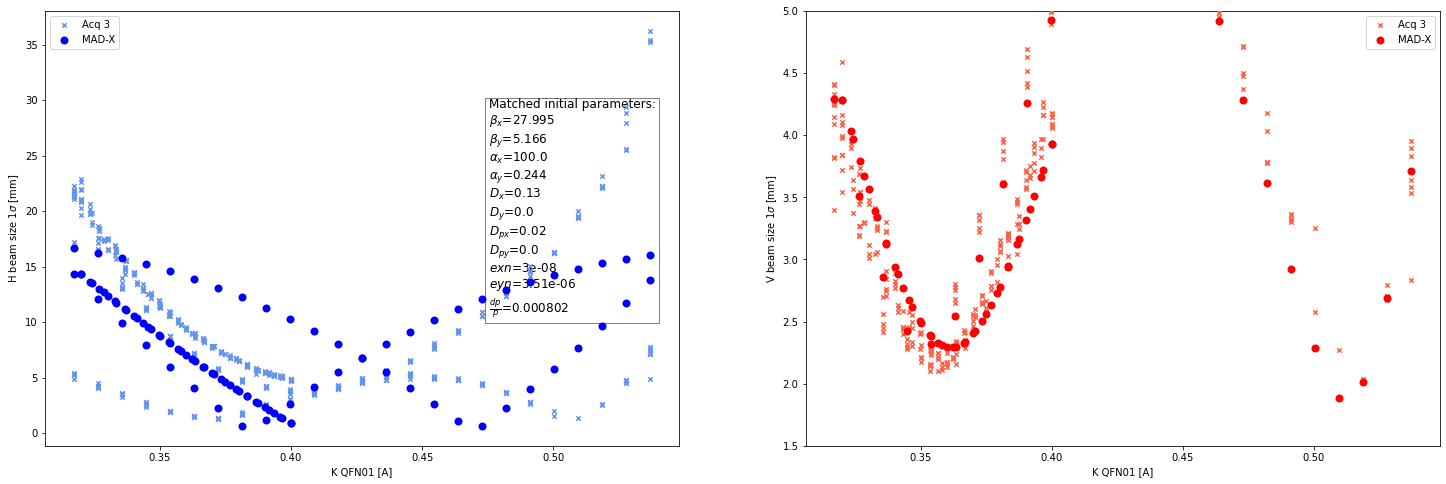

In [23]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

  

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

# df_acq = df[df.Acqu==2].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")


df_acq = df[df.Acqu==3].copy()
ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="cornflowerblue", s=20, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="tomato", s=20, marker="x", label="Acq 3", zorder=99)

# df_acq = df[df.Acqu==4].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

# df_acq = df[df.Acqu==5].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=2, zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=2, zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
ax[1].set_ylim(1.5, 5)

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(Dx0,3)),
    r'$D_{y}$='+str(round(Dy0,3)),
    r'$D_{px}$='+str(round(Dpx0,3)),
    r'$D_{py}$='+str(round(Dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# fig.suptitle(f"{subset_dirnames}")
# plt.savefig("fig/quad_scan_filter_pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight') 

# Optimise only in H and then in V all parameter

[ 8.24e+01 -1.11e+01  1.50e-06  7.53e-04]
7407.472466979767
[ 2.319e+02 -1.110e+01  1.500e-06  7.530e-04]
6738.168159714999
[8.24e+01 0.00e+00 1.50e-06 7.53e-04]
5218.148893705194
[ 8.24e+01 -1.11e+01  2.65e-05  7.53e-04]
16392.389820287386
[ 8.240e+01 -1.110e+01  1.500e-06  1.753e-03]
7178.131765653988
[ 1.00e+00 -1.11e+01  1.50e-06  7.53e-04]
83861.70710454059
[ 8.24e+01 -6.11e+01  1.50e-06  7.53e-04]
8943.64411588572
[ 8.24e+01 -1.11e+01  0.00e+00  7.53e-04]
11311.991117305424
[ 8.24e+01 -1.11e+01  1.50e-06  0.00e+00]
7464.134988451186
[1.57701749e+02 0.00000000e+00 1.23930202e-05 1.49895115e-03]
50669.305399378674
[1.32205739e+02 0.00000000e+00 5.68448514e-06 4.19839316e-04]
15496.721063415018
[ 8.24e+01 -5.55e+00  1.50e-06  7.53e-04]
6698.070488705292
[9.97918974e+01 0.00000000e+00 0.00000000e+00 9.65994028e-04]
11184.589239996307
[7.77104681e+01 0.00000000e+00 3.81490968e-06 7.74022630e-04]
6307.203220681313
[8.97482438e+01 0.00000000e+00 1.61210454e-06 6.66028970e-04]
5178.86433

340.767507673542
[ 9.09713007e+01 -2.19552325e+01  1.16967071e-05  2.00000000e-03]
330.78172442514983
[ 9.20510857e+01 -2.21031737e+01  1.18547476e-05  2.00000000e-03]
320.73269524490814
[ 9.52971988e+01 -2.30644294e+01  1.23959677e-05  2.00000000e-03]
314.7190790464668
[ 9.46754378e+01 -2.27347324e+01  1.22196867e-05  2.00000000e-03]
308.80423659091707
[ 9.52762562e+01 -2.27783574e+01  1.22450400e-05  2.00000000e-03]
308.3803838884506
[ 9.50086445e+01 -2.27034656e+01  1.22396350e-05  2.00000000e-03]
308.6057482168386
[ 9.52866548e+01 -2.27730260e+01  1.22482742e-05  1.99766300e-03]
308.4268618733696
[ 9.54499041e+01 -2.28296748e+01  1.22815116e-05  1.99901832e-03]
308.25671857660717
[ 9.53539499e+01 -2.28228566e+01  1.22658285e-05  1.99848592e-03]
308.22067543330496
[ 9.53421880e+01 -2.28284345e+01  1.22636556e-05  1.99820505e-03]
308.2150316891417
[ 9.54372749e+01 -2.28552505e+01  1.22529410e-05  1.99826216e-03]
308.2115498650105
[ 9.54955341e+01 -2.28668023e+01  1.22667401e-05  1.99

307.93539829575576
[ 9.98065743e+01 -2.38985866e+01  1.17442562e-05  1.86955819e-03]
307.9352851460032
[ 9.98241135e+01 -2.39010671e+01  1.17458867e-05  1.86951323e-03]
307.935160990568
[ 9.98323627e+01 -2.39042740e+01  1.17459681e-05  1.86938941e-03]
307.93507610164556
[ 9.98374021e+01 -2.39049772e+01  1.17474964e-05  1.86940126e-03]
307.93545969998
[ 9.98449595e+01 -2.39028011e+01  1.17451700e-05  1.86942125e-03]
307.93593791428
[ 9.98345683e+01 -2.39043386e+01  1.17435374e-05  1.86937131e-03]
307.934588096209
[ 9.98401359e+01 -2.39058667e+01  1.17349770e-05  1.86917024e-03]
307.93454171583767
[ 9.98572081e+01 -2.39096774e+01  1.17383182e-05  1.86911289e-03]
307.933622762018
[ 9.99138353e+01 -2.39237998e+01  1.17325465e-05  1.86851002e-03]
307.9317348156876
[ 1.00140269e+02 -2.39776855e+01  1.17052478e-05  1.86614525e-03]
307.9241930241808
[ 1.01008722e+02 -2.41894837e+01  1.15850205e-05  1.85670998e-03]
307.905418639466
[ 1.04728653e+02 -2.50745023e+01  1.11877241e-05  1.81880948e-0

[ 1.09719781e+02 -2.62738052e+01  1.07078891e-05  1.67345126e-03]
307.6850990346669
[ 1.10057577e+02 -2.63537975e+01  1.06747348e-05  1.67435482e-03]
307.68406439804306
[ 1.10391219e+02 -2.64331718e+01  1.06428167e-05  1.67330158e-03]
307.6826160231493
[ 1.11819052e+02 -2.67713438e+01  1.05145471e-05  1.67255682e-03]
307.6812817372233
[ 1.11560594e+02 -2.67106659e+01  1.05353623e-05  1.67287184e-03]
307.6805367349737
[ 1.12194443e+02 -2.68612072e+01  1.04729405e-05  1.67346547e-03]
307.6804971212586
[ 1.12383802e+02 -2.67657723e+01  1.04500999e-05  1.67352310e-03]
309.1198386815889
[ 1.12168856e+02 -2.68579224e+01  1.04751325e-05  1.67273793e-03]
307.67847514713225
[ 1.13385030e+02 -2.71499795e+01  1.03531779e-05  1.66951028e-03]
307.6798432369523
[ 1.12169127e+02 -2.68848591e+01  1.04190342e-05  1.67283812e-03]
307.7631972104674
[ 1.12788073e+02 -2.70070382e+01  1.04083415e-05  1.67207439e-03]
307.6801779768796
[ 1.12220087e+02 -2.68728266e+01  1.04948235e-05  1.67141056e-03]
307.6928

307.8398426373949
[ 1.13025953e+02 -2.70619949e+01  1.04144269e-05  1.62092776e-03]
307.67107644324017
[ 1.13114497e+02 -2.70462436e+01  1.03976873e-05  1.62233317e-03]
307.7734856673506
[ 1.12956577e+02 -2.70507509e+01  1.04053789e-05  1.62195053e-03]
307.6646407913621
[ 1.12659084e+02 -2.69797050e+01  1.04307365e-05  1.62049583e-03]
307.6643952883759
[ 1.11456572e+02 -2.66924722e+01  1.05371087e-05  1.61500262e-03]
307.6651499928961
[ 1.12661878e+02 -2.68784655e+01  1.04105389e-05  1.62025226e-03]
308.3945139956035
[ 1.12217838e+02 -2.68733115e+01  1.04717906e-05  1.61867163e-03]
307.6642102535466
[ 1.12194998e+02 -2.68678119e+01  1.04739440e-05  1.61857473e-03]
307.66420561580566
[ 1.12189828e+02 -2.68665668e+01  1.04744317e-05  1.61855277e-03]
307.6642046436842
[ 1.12188663e+02 -2.68662864e+01  1.04745415e-05  1.61854782e-03]
307.6642044286702
[ 1.12315190e+02 -2.68753730e+01  1.04952594e-05  1.61625987e-03]
307.70405649355894
[ 1.10869833e+02 -2.65506357e+01  1.05922660e-05  1.613

307.6617245488861
[ 1.10628954e+02 -2.64921196e+01  1.06225478e-05  1.59525908e-03]
307.6617234461738
[ 1.10635696e+02 -2.64938006e+01  1.06223508e-05  1.59520941e-03]
307.6617161637384
[ 1.10643901e+02 -2.64955517e+01  1.06213990e-05  1.59520706e-03]
307.66169431394246
[ 1.10676740e+02 -2.65033111e+01  1.06181984e-05  1.59525574e-03]
307.6616401691762
[ 1.10803419e+02 -2.65333792e+01  1.06079319e-05  1.59571314e-03]
307.6616198854088
[ 1.10789458e+02 -2.65430016e+01  1.06084468e-05  1.59570474e-03]
307.6721557519355
[ 1.10867040e+02 -2.65487960e+01  1.06011862e-05  1.59558904e-03]
307.66140820393633
[ 1.11129923e+02 -2.66114902e+01  1.05779987e-05  1.59614174e-03]
307.66128400821407
[ 1.11164330e+02 -2.66196970e+01  1.05745706e-05  1.59615391e-03]
307.6612104159839
[ 1.11324225e+02 -2.66577257e+01  1.05607014e-05  1.59643466e-03]
307.66125542683295
[ 1.11139500e+02 -2.66417383e+01  1.05781963e-05  1.59631261e-03]
307.71357683305587
[ 1.11304032e+02 -2.66540623e+01  1.05605781e-05  1.5

307.6511857471348
[ 1.10995807e+02 -2.66278446e+01  1.06022092e-05  1.50906577e-03]
307.8204237821837
[ 1.11048122e+02 -2.65929069e+01  1.05836290e-05  1.50997269e-03]
307.65087213813416
[ 1.11143902e+02 -2.66149022e+01  1.05781248e-05  1.51040351e-03]
307.65080382638746
[ 1.11074057e+02 -2.65985263e+01  1.05838894e-05  1.50972575e-03]
307.6507331620398
[ 1.11404987e+02 -2.66772201e+01  1.05524228e-05  1.50761680e-03]
307.6506832800107
[ 1.11464110e+02 -2.66850116e+01  1.05484180e-05  1.50797822e-03]
307.65410668434265
[ 1.11320080e+02 -2.66572969e+01  1.05612691e-05  1.50595979e-03]
307.65054478790495
[ 1.11348531e+02 -2.66444576e+01  1.05525755e-05  1.50596223e-03]
307.6811878686277
[ 1.11316741e+02 -2.66565728e+01  1.05622101e-05  1.50687408e-03]
307.6506121300113
[ 1.11367359e+02 -2.66666071e+01  1.05633907e-05  1.50569974e-03]
307.65187378761095
[ 1.11270773e+02 -2.66461534e+01  1.05649348e-05  1.50578783e-03]
307.650508228483
[ 1.11285363e+02 -2.66497995e+01  1.05631966e-05  1.50

307.6530087346631
[ 1.10757051e+02 -2.65229421e+01  1.06144444e-05  1.46408122e-03]
307.6494925058143
[ 1.10750785e+02 -2.65239909e+01  1.06124597e-05  1.46429209e-03]
307.65004370804513
[ 1.10768831e+02 -2.65256476e+01  1.06141033e-05  1.46425076e-03]
307.64947700636776
[ 1.10761262e+02 -2.65216713e+01  1.06159887e-05  1.46428839e-03]
307.64976759320285
[ 1.10752138e+02 -2.65216489e+01  1.06156847e-05  1.46428800e-03]
307.64947394706365
[ 1.10728102e+02 -2.65159046e+01  1.06179251e-05  1.46421685e-03]
307.6494703862698
[ 1.10672438e+02 -2.65026182e+01  1.06229945e-05  1.46418704e-03]
307.6494661790048
[ 1.10657681e+02 -2.64990942e+01  1.06243471e-05  1.46416790e-03]
307.6494658274005
[ 1.10655589e+02 -2.64985946e+01  1.06245389e-05  1.46416522e-03]
307.6494658052326
[ 1.10652104e+02 -2.65027225e+01  1.06266163e-05  1.46417997e-03]
307.65140866833565
[ 1.10654925e+02 -2.64984379e+01  1.06246167e-05  1.46418218e-03]
307.6494655126836
[ 1.10651339e+02 -2.64975815e+01  1.06249449e-05  1.4

308.8057159987529
[ 2.02338846e+02 -4.83632967e+01  6.07307476e-06  1.86223682e-03]
313.20747704806985
[ 2.03060907e+02 -4.84881585e+01  5.75306650e-06  1.85876248e-03]
309.4470006137115
[ 2.02371635e+02 -4.84437961e+01  5.88422615e-06  1.85729015e-03]
308.7877515831756
[ 2.02162695e+02 -4.83555254e+01  5.86375924e-06  1.85800417e-03]
308.66698004275304
[ 2.02195907e+02 -4.83745367e+01  5.84508609e-06  1.85850234e-03]
308.5932670636324
[ 2.02182052e+02 -4.83920317e+01  5.83069955e-06  1.85776898e-03]
308.5430387546411
[ 2.02289821e+02 -4.83585209e+01  5.82841695e-06  1.85792007e-03]
308.73129583115394
[ 2.02170094e+02 -4.84349231e+01  5.84205364e-06  1.85799585e-03]
308.50975804891937
[ 2.02142707e+02 -4.84565909e+01  5.86339388e-06  1.85821945e-03]
308.62400634841947
[ 2.02224528e+02 -4.84456531e+01  5.83540212e-06  1.85802001e-03]
308.5013750754271
[ 2.02258978e+02 -4.84463739e+01  5.83651779e-06  1.85810486e-03]
308.5057569244607
[ 2.02248562e+02 -4.84490935e+01  5.83935837e-06  1.8

308.2436340034591
[ 1.74070906e+02 -4.16951254e+01  6.76695562e-06  1.94179195e-03]
308.2423179007722
[ 1.73761089e+02 -4.16205677e+01  6.77442621e-06  1.94192406e-03]
308.2393927607973
[ 1.73873434e+02 -4.16478592e+01  6.77226717e-06  1.94177974e-03]
308.24003056930206
[ 1.73735629e+02 -4.16250860e+01  6.79130282e-06  1.94236241e-03]
308.253185244898
[ 1.73679644e+02 -4.16016965e+01  6.78183731e-06  1.94252723e-03]
308.2385292932362
[ 1.73570591e+02 -4.15733434e+01  6.78572713e-06  1.94241298e-03]
308.2381873215905
[ 1.73600050e+02 -4.15578894e+01  6.79300847e-06  1.94235345e-03]
308.263789891346
[ 1.73510703e+02 -4.15718611e+01  6.78284672e-06  1.94263232e-03]
308.23592225099617
[ 1.73465386e+02 -4.15589845e+01  6.78590090e-06  1.94240961e-03]
308.2350624666764
[ 1.73521024e+02 -4.15729384e+01  6.78393498e-06  1.94242216e-03]
308.2356558306907
[ 1.73444836e+02 -4.15664069e+01  6.78893723e-06  1.94240857e-03]
308.24105455480054
[ 1.73446752e+02 -4.15535552e+01  6.78801055e-06  1.94255

308.0701301710356
[ 1.55109426e+02 -3.71478183e+01  7.59323152e-06  1.96888841e-03]
308.0699577265777
[ 1.55083957e+02 -3.71415159e+01  7.59464180e-06  1.96894872e-03]
308.0699333079521
[ 1.55078995e+02 -3.71402881e+01  7.59491654e-06  1.96896047e-03]
308.06992899468287
[ 1.55078040e+02 -3.71400518e+01  7.59496943e-06  1.96896274e-03]
308.06992818086314
[ 1.55077856e+02 -3.71400064e+01  7.59497959e-06  1.96896317e-03]
308.0699280251543
[ 1.55088533e+02 -3.71218102e+01  7.57284692e-06  1.96971537e-03]
308.11307286174906
[ 1.54443267e+02 -3.69832676e+01  7.62767616e-06  1.97172408e-03]
308.06880823799673
[ 1.54151200e+02 -3.69057986e+01  7.64439923e-06  1.97207906e-03]
308.0750702623041
[ 1.54608441e+02 -3.69207453e+01  7.63489171e-06  1.97195260e-03]
308.49597591410316
[ 1.54101262e+02 -3.69209676e+01  7.62772217e-06  1.97179326e-03]
308.05911571520795
[ 1.54402735e+02 -3.69911962e+01  7.61936005e-06  1.97099355e-03]
308.0600178989878
[ 1.54144268e+02 -3.68924943e+01  7.60892540e-06  1.

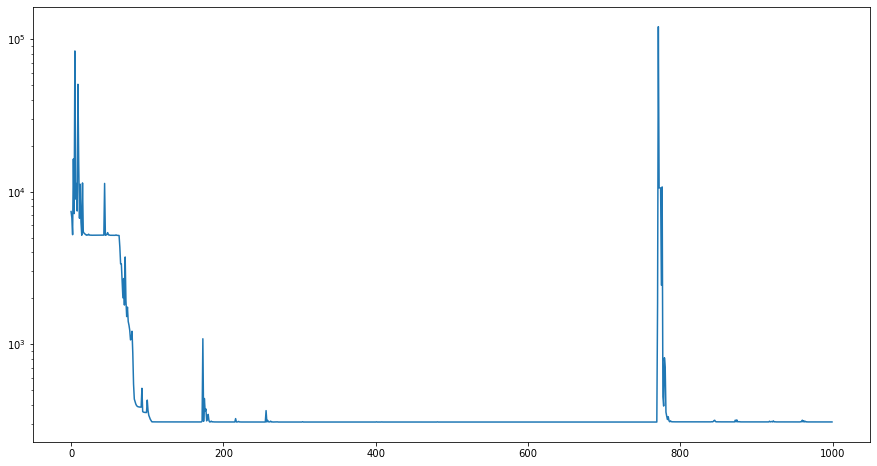

In [42]:
# Py-BOBYQA

#################################### Initialize MADX ####################################


madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

btv="f61.btv010"

progress_obj = []
progress_params = []
# Define the objective function
def f_fit(params):
    global progress_obj
    print(params)
    betx0, alfx0, exn, sige = params
    
    dx0 = 0.13
    dy0 = 0.0
    dpx0 = 0.02
    dpy0 = 0
    
    bety0 = 33.2
    alfy0 = 0.28
    eyn = 1.5e-6
    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

        
    def worker1(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1, return_dict1V))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2, return_dict2V))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3, return_dict3V))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4, return_dict4V))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_H_madx"]=madx_sigma_list
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1V.values())
        madx_sigma_list.extend(return_dict2V.values())
        madx_sigma_list.extend(return_dict3V.values())
        madx_sigma_list.extend(return_dict4V.values())
        
        new_df["sigma_V_madx"]=madx_sigma_list
        
        
        objective = sum(
            abs(
                new_df["sigma_H_madx"]-new_df["sigH"])**2 #+ (new_df["sigma_V_madx"]-new_df["sigV"])**2
                )
        

    print (objective)
    progress_obj.append(objective)
    progress_params.append(params)
    
    with open('progress_H.pickle', 'wb') as handle:
        pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('params_H.pickle', 'wb') as handle:
        pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return (objective)

# Define the starting point

# Open the last params that work, a way to save progress of optimisation
with open('params.pickle', 'rb') as handle:
            params = pickle.load(handle)
        
initial_guess = [82.4, -11.1, 1.5e-6, 7.53e-4]
# initial_guess = params[-1]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, -100, 0.0, 0.0])
upper = np.array([300, 0, 5.0e-5, 20.0e-4])

# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-8, maxfun=1000)

# Display output
print(soln)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(progress_obj)
ax.set_yscale('log')

In [49]:
soln.x

array([ 1.10574337e+02, -2.64790170e+01,  1.06326898e-05,  1.46296000e-03])

In [43]:
with open('params_H.pickle', 'rb') as handle:
    params = pickle.load(handle)

# New initial conditions
betx0 = params[-1][0]
bety0 = 33.2
alfx0 = params[-1][1]
alfy0 = 0.28
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = params[-1][2]
eyn = 1.5e-6
sige = params[-1][3]

In [65]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

  

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

# df_acq = df[df.Acqu==2].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")



ax[0].scatter(new_df.k_qfn01, new_df.sigma_H_madx, color="magenta", linewidth=2, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(new_df.k_qfn01, new_df.sigma_V_madx, color="tomato", linewidth=2, marker="x", label="Acq 3", zorder=99)

# df_acq = df[df.Acqu==4].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

# df_acq = df[df.Acqu==5].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")


# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(Dx0,3)),
    r'$D_{y}$='+str(round(Dy0,3)),
    r'$D_{px}$='+str(round(Dpx0,3)),
    r'$D_{py}$='+str(round(Dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# fig.suptitle(f"{subset_dirnames}")
# plt.savefig("fig/quad_scan_filter_pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight') 

PermissionError: [Errno 13] Permission denied: 'tempfile'

# Optimise in V using previous result in the H plane

[ 3.32e+01 -1.11e+01  1.50e-06  7.53e-04]
13220.303443635356
[ 1.077e+02 -1.110e+01  1.500e-06  7.530e-04]
18373.579913097754
[3.32e+01 8.89e+01 1.50e-06 7.53e-04]
445693.797134771
[ 3.32e+01 -1.11e+01  2.65e-05  7.53e-04]
426811.25837724213
[ 3.320e+01 -1.110e+01  1.500e-06  1.753e-03]
13736.476626264863
[ 1.00e+00 -1.11e+01  1.50e-06  7.53e-04]
275484.5541496195
[ 3.32e+01 -1.00e+02  1.50e-06  7.53e-04]
797679.0961442903
[ 3.32e+01 -1.11e+01  0.00e+00  7.53e-04]
2822.3745262275324
[ 3.32e+01 -1.11e+01  1.50e-06  0.00e+00]
13736.476626264863
[7.00007319e+01 7.83469963e+00 0.00000000e+00 8.76500000e-04]
2822.3745262275324
[5.29269261e+01 3.92253501e+00 0.00000000e+00 3.56366549e-04]
2822.3745262275324
[ 3.32e+01 -1.11e+01  7.50e-07  7.53e-04]
4723.326755521682
[2.70490639e+01 5.40490218e+00 2.47171868e-07 9.21358064e-04]
1649.707255736811
[1.97871898e+01 3.45222705e+00 1.43906631e-07 9.31373220e-04]
1875.033570487643
[ 3.14727936e+01 -1.59287248e+00  0.00000000e+00  9.59822441e-04]
282

305.09847451466396
[2.27884001e+01 2.35714671e+01 8.33544319e-08 9.55731635e-04]
311.9073111016014
[2.27472211e+01 2.36034325e+01 9.74860749e-08 9.55999607e-04]
303.7028831518275
[2.27306025e+01 2.36754992e+01 9.75307476e-08 9.55800420e-04]
303.69379572075536
[2.26907614e+01 2.36533152e+01 9.52306217e-08 9.55285509e-04]
302.43308170753545
[2.27276644e+01 2.36308740e+01 9.75643840e-08 9.55459869e-04]
303.68934736582696
[2.26771717e+01 2.36564293e+01 1.03430141e-07 9.55387414e-04]
309.86986184356005
[2.26816296e+01 2.36662408e+01 8.94650350e-08 9.55544895e-04]
302.64548993406976
[2.26854980e+01 2.36702354e+01 9.55139777e-08 9.55219927e-04]
302.484417214693
[2.26941880e+01 2.36594194e+01 9.12215993e-08 9.55204932e-04]
302.1828528202186
[2.26915953e+01 2.36728345e+01 9.24490270e-08 9.55333120e-04]
301.9112808345805
[2.26814016e+01 2.36798192e+01 9.21074146e-08 9.55213693e-04]
301.8194600404799
[2.26701526e+01 2.36981994e+01 9.14863114e-08 9.55052356e-04]
301.6814040759734
[2.26574593e+01 2

427.93842091734155
[2.15618852e+01 3.06751727e+01 1.52879344e-07 9.44477690e-04]
1917.0793949276822
[2.11413531e+01 3.17922544e+01 3.26838283e-08 9.34951045e-04]
309.671076432129
[2.13215013e+01 3.03167778e+01 2.99586011e-08 9.45564543e-04]
384.3097429958298
[2.14296301e+01 3.13348889e+01 3.02778470e-08 9.41447954e-04]
351.5827783579164
[2.15588393e+01 3.03725335e+01 1.09662118e-07 9.47015929e-04]
937.3192115876892
[2.16624977e+01 3.06660929e+01 2.65313122e-08 9.48860145e-04]
436.62709052523905
[2.16493674e+01 3.05782678e+01 3.32654935e-09 9.45639511e-04]
1654.1936672955642
[2.14386337e+01 3.07118895e+01 5.58570589e-08 9.45452150e-04]
298.11801653903643
[2.15914515e+01 3.07038262e+01 4.23316883e-08 9.45427080e-04]
281.97727770237157
[2.15724698e+01 3.05989224e+01 6.12985487e-08 9.44349016e-04]
323.9093456186671
[2.15756571e+01 3.06218050e+01 3.79449494e-08 9.44656047e-04]
302.95466426498416
[2.15349338e+01 3.06340912e+01 4.32339351e-08 9.44769319e-04]
279.7804268262122
[2.15287752e+01 

264.242873616291
[1.03242682e+01 2.99736761e+01 2.02258210e-08 1.04228888e-03]
264.1276370822652
[1.03249551e+01 2.99738840e+01 2.05798306e-08 1.04229021e-03]
264.4919015829233
[1.03238030e+01 2.99738138e+01 2.03463174e-08 1.04228591e-03]
264.20978974296514
[1.03241359e+01 2.99737804e+01 2.00807678e-08 1.04228296e-03]
264.0905938723641
[1.03235810e+01 2.99739075e+01 2.00207216e-08 1.04228613e-03]
264.09446294711586
[1.03241240e+01 2.99737655e+01 2.00175711e-08 1.04227953e-03]
264.0951914770344
[1.03243697e+01 2.99738393e+01 2.00841009e-08 1.04228013e-03]
264.0906760920815
[1.03241555e+01 2.99739844e+01 2.00664934e-08 1.04228301e-03]
264.0905208938551
[1.03240819e+01 2.99739910e+01 2.00434910e-08 1.04228136e-03]
264.0917378430719
[1.03241971e+01 2.99739932e+01 2.00868300e-08 1.04228287e-03]
264.090828575392
[1.03241425e+01 2.99739018e+01 2.00724547e-08 1.04228253e-03]
264.09047575989234
[1.03241057e+01 2.99739092e+01 2.00938556e-08 1.04228266e-03]
264.09124910087996
[1.03241464e+01 2.99

193.68625249370328
[ 6.49003529e+01 -2.03134178e+01  7.64251883e-08  5.65759328e-04]
193.49190279639785
[ 6.49001670e+01 -2.03158269e+01  7.71707676e-08  5.65616642e-04]
193.39839468625604
[ 6.49041164e+01 -2.03224452e+01  7.59856149e-08  5.65592933e-04]
193.6307651170967
[ 6.49005667e+01 -2.03135134e+01  7.69887590e-08  5.65519776e-04]
193.40280879224807
[ 6.49001865e+01 -2.03227366e+01  7.68905604e-08  5.65688056e-04]
193.44664583121732
[ 6.48998255e+01 -2.03114768e+01  7.66682860e-08  5.65603126e-04]
193.43893937179956
[ 6.48989259e+01 -2.03175055e+01  7.72539732e-08  5.65609253e-04]
193.40282876072578
[ 6.48989323e+01 -2.03166689e+01  7.67890347e-08  5.65609840e-04]
193.43926522008738
[ 6.49003708e+01 -2.03155388e+01  7.70649948e-08  5.65624786e-04]
193.40393524004924
[ 6.48999484e+01 -2.03151004e+01  7.72987594e-08  5.65620163e-04]
193.39079389673154
[ 6.49003613e+01 -2.03143196e+01  7.73373870e-08  5.65622601e-04]
193.38634406750643
[ 6.49001842e+01 -2.03134695e+01  7.73550357e-0

120.29691676707284
[ 7.54687450e+01 -2.86292080e+00  2.35357975e-07  4.76906811e-04]
120.29681112659861
[ 7.54657904e+01 -2.86608083e+00  2.34564884e-07  4.76959936e-04]
120.3075775053961
[ 7.54681577e+01 -2.86222892e+00  2.35260722e-07  4.76921101e-04]
120.29790464519931
[ 7.54715046e+01 -2.86216855e+00  2.35683398e-07  4.76908183e-04]
120.29624158396608
[ 7.54727776e+01 -2.86459210e+00  2.35429942e-07  4.76933040e-04]
120.29594358343483
[ 7.54740817e+01 -2.86569324e+00  2.35347901e-07  4.76947606e-04]
120.29598819369211
[ 7.54731237e+01 -2.86381245e+00  2.35013188e-07  4.76929903e-04]
120.30026806694845
[ 7.54729599e+01 -2.86603286e+00  2.35597218e-07  4.76944942e-04]
120.29516266371228
[ 7.54773000e+01 -2.86955311e+00  2.35547355e-07  4.76986931e-04]
120.29441098281886
[ 7.54910754e+01 -2.88658407e+00  2.34615410e-07  4.77181393e-04]
120.29397497951797
[ 7.54907477e+01 -2.89150757e+00  2.35123754e-07  4.77157805e-04]
120.28893548247726
[ 7.55006636e+01 -2.89851479e+00  2.34740781e-0

120.24745301545921
[ 7.56377361e+01 -3.21884479e+00  2.29004817e-07  4.77234959e-04]
120.24738139515321
[ 7.56373313e+01 -3.22647764e+00  2.28907837e-07  4.77259112e-04]
120.24729808076029
[ 7.56369625e+01 -3.22751051e+00  2.28904406e-07  4.77263205e-04]
120.24730209463084
[ 7.56372362e+01 -3.22625919e+00  2.28649125e-07  4.77264982e-04]
120.24752371324803
[ 7.56372133e+01 -3.22676394e+00  2.28810295e-07  4.77270159e-04]
120.2471648514458
[ 7.56375281e+01 -3.23057203e+00  2.28730790e-07  4.77286607e-04]
120.24713353105345
[ 7.56378952e+01 -3.23523480e+00  2.28636792e-07  4.77305253e-04]
120.24711506014857
[ 7.56379430e+01 -3.23592049e+00  2.28623037e-07  4.77308001e-04]
120.24711391245943
[ 7.56379503e+01 -3.23602762e+00  2.28620889e-07  4.77308430e-04]
120.24711377122753
[ 7.56380259e+01 -3.23684150e+00  2.29376743e-07  4.77316286e-04]
120.25432874200291
[ 7.56379475e+01 -3.23618422e+00  2.28613576e-07  4.77308509e-04]
120.24711556755759
[ 7.56378328e+01 -3.23602689e+00  2.28623785e-0

120.22832272736999
[ 7.52443027e+01 -3.25868692e+00  2.29018036e-07  4.82325487e-04]
120.2282963557851
[ 7.52438930e+01 -3.25980962e+00  2.30165767e-07  4.82320558e-04]
120.2419715035903
[ 7.52399407e+01 -3.25442449e+00  2.29204347e-07  4.82306580e-04]
120.22775195554941
[ 7.52237282e+01 -3.25024111e+00  2.29285843e-07  4.82510075e-04]
120.22687529599676
[ 7.51531967e+01 -3.23848828e+00  2.29527903e-07  4.83243723e-04]
120.2235216932416
[ 7.48783844e+01 -3.25691056e+00  2.29045034e-07  4.86331431e-04]
120.2223945657051
[ 7.48437787e+01 -3.24573307e+00  2.30790008e-07  4.85865374e-04]
120.2113568107139
[ 7.46800153e+01 -3.33163921e+00  2.29116133e-07  4.86333764e-04]
120.20798469736337
[ 7.46549489e+01 -3.30484798e+00  2.09894386e-07  4.86157166e-04]
125.44650584462943
[ 7.46257132e+01 -3.37360036e+00  2.28932461e-07  4.87194603e-04]
120.21401292770159
[ 7.46562507e+01 -3.28813641e+00  2.35729223e-07  4.86367481e-04]
120.61988993763454
[ 7.47046097e+01 -3.38164521e+00  2.28691791e-07  4

120.18305060310036
[ 7.43666397e+01 -3.16464499e+00  2.32848204e-07  4.90929731e-04]
120.18276008639641
[ 7.43649178e+01 -3.17327786e+00  2.32708475e-07  4.90951616e-04]
120.18263825792819
[ 7.43647910e+01 -3.18915713e+00  2.32433686e-07  4.90989986e-04]
120.18274922232878
[ 7.43639874e+01 -3.17425503e+00  2.32694579e-07  4.90953391e-04]
120.18259096684096
[ 7.43625178e+01 -3.17228293e+00  2.32734781e-07  4.90942530e-04]
120.18251523414735
[ 7.43600775e+01 -3.16967183e+00  2.32790089e-07  4.90924569e-04]
120.18239466108147
[ 7.43561643e+01 -3.16600620e+00  2.32869766e-07  4.90895516e-04]
120.182210019266
[ 7.42408717e+01 -2.96857698e+00  2.36028533e-07  4.90150590e-04]
120.19902015183389
[ 7.43330636e+01 -3.12721457e+00  2.33637639e-07  4.90669708e-04]
120.18188201880633
[ 7.43358698e+01 -3.12865660e+00  2.33600344e-07  4.90694570e-04]
120.18197333813539
[ 7.43326569e+01 -3.12430045e+00  2.34339480e-07  4.90693789e-04]
120.1877669300429
[ 7.43327329e+01 -3.13056675e+00  2.33563461e-07 

120.02060143322655
[ 7.10923035e+01 -2.80164508e+00  2.48230235e-07  4.70613808e-04]
120.0208030118178
[ 7.11127850e+01 -2.81432825e+00  2.51138245e-07  4.70314467e-04]
120.1500302865718
[ 7.11039267e+01 -2.81561383e+00  2.47748734e-07  4.70539647e-04]
120.01853209974172
[ 7.11002592e+01 -2.82017028e+00  2.47593189e-07  4.70686769e-04]
120.01746012173616
[ 7.10676607e+01 -2.84652513e+00  2.47258569e-07  4.71084047e-04]
120.01134792503706
[ 7.08896531e+01 -2.90481345e+00  2.48300115e-07  4.70276394e-04]
120.03084910114686
[ 7.10104247e+01 -2.90709172e+00  2.46333977e-07  4.71930968e-04]
120.00145026510754
[ 7.09753939e+01 -3.13153474e+00  2.42164824e-07  4.76570475e-04]
120.00764269858323
[ 7.08252912e+01 -2.91683657e+00  2.46741011e-07  4.71211385e-04]
119.98986318310189
[ 7.00743810e+01 -2.92328441e+00  2.48662326e-07  4.68835963e-04]
119.9433220382279
[ 6.97436333e+01 -2.55719284e+00  2.56681911e-07  4.60231857e-04]
119.98726474340089
[ 7.00714468e+01 -3.05558641e+00  2.60570870e-07 

421.44675494366584
[ 6.21401555e+01 -2.79483449e+00  2.89394885e-07  4.79864207e-04]
121.31823861901067
[ 6.29957820e+01 -2.60761755e+00  2.42244208e-07  4.72426691e-04]
130.55709585886058
[ 6.33286124e+01 -2.28124163e+00  2.90157761e-07  4.72939581e-04]
119.86065382358287
[ 6.30117217e+01 -2.47946676e+00  2.47214486e-07  4.80675603e-04]
129.17779883076858
[ 6.31583360e+01 -2.76284053e+00  2.80274064e-07  4.81784601e-04]
120.07155629745586
[ 6.30820819e+01 -2.73892631e+00  2.53239780e-07  4.78537791e-04]
123.14673241413563
[ 6.30681984e+01 -2.70111674e+00  2.77193554e-07  4.77751129e-04]
119.55304776118591
[ 6.30035781e+01 -2.71101717e+00  2.77259372e-07  4.77810777e-04]
119.55633693108794
[ 6.30628046e+01 -2.77334459e+00  2.70865511e-07  4.77333124e-04]
119.49427206005481
[ 6.30506120e+01 -2.69116617e+00  2.72425887e-07  4.77088754e-04]
119.48983185278296
[ 6.30577316e+01 -2.66544327e+00  2.64197480e-07  4.77000429e-04]
120.50267343509124
[ 6.30437509e+01 -2.68478268e+00  2.73040683e-

119.37773791311395
[ 6.21828985e+01 -2.51622069e+00  2.81523103e-07  4.80255478e-04]
119.37573808373145
[ 6.21828541e+01 -2.50510250e+00  2.81637616e-07  4.80167417e-04]
119.37650997201214
[ 6.21833719e+01 -2.51632129e+00  2.80406701e-07  4.80262174e-04]
119.3892789793693
[ 6.21785843e+01 -2.51456618e+00  2.81581980e-07  4.80218039e-04]
119.37537013354608
[ 6.21774864e+01 -2.50999252e+00  2.81845805e-07  4.80269167e-04]
119.37508588830264
[ 6.21722221e+01 -2.51030094e+00  2.81822188e-07  4.80274716e-04]
119.37465763915054
[ 6.21554155e+01 -2.49651254e+00  2.82245122e-07  4.80376501e-04]
119.37340404675705
[ 6.20717660e+01 -2.49046593e+00  2.82346374e-07  4.80532774e-04]
119.36766123471082
[ 6.17412313e+01 -2.45604326e+00  2.83375421e-07  4.81436234e-04]
119.35594656415506
[ 6.14393623e+01 -2.27150554e+00  2.88188312e-07  4.82308105e-04]
119.39841751565234
[ 6.17462828e+01 -2.46071386e+00  2.84444035e-07  4.82060710e-04]
119.33947160493778
[ 6.16087049e+01 -2.34751877e+00  2.87275644e-0

118.78565074261302
[ 5.60547855e+01 -2.23370040e+00  3.14939323e-07  5.03176378e-04]
118.79990880415622
[ 5.60460975e+01 -2.23144354e+00  3.13565719e-07  5.03242608e-04]
118.78348355516528
[ 5.60476136e+01 -2.22204576e+00  3.13896864e-07  5.03046006e-04]
118.78307394052855
[ 5.60438845e+01 -2.21818607e+00  3.16032398e-07  5.03019054e-04]
118.81091159109948
[ 5.60400901e+01 -2.22508507e+00  3.13883801e-07  5.03075942e-04]
118.78248788022745
[ 5.60330470e+01 -2.22274727e+00  3.14093731e-07  5.03026303e-04]
118.78180629127692
[ 5.60086970e+01 -2.20123443e+00  3.14972419e-07  5.02831493e-04]
118.77855984499682
[ 5.58864532e+01 -2.19984204e+00  3.15860176e-07  5.02212742e-04]
118.76692880957327
[ 5.58278021e+01 -2.10585661e+00  3.19883695e-07  5.00968675e-04]
118.77329235655341
[ 5.58830041e+01 -2.19510267e+00  3.22256912e-07  5.02312068e-04]
119.0767841381612
[ 5.58458183e+01 -2.14681901e+00  3.17903679e-07  5.01783960e-04]
118.76423075146815
[ 5.57883282e+01 -2.17450497e+00  3.17488772e-0

118.51148313054782
[ 5.31409413e+01 -2.01128313e+00  3.34544902e-07  4.86496127e-04]
118.43707087755492
[ 5.31346470e+01 -2.02354271e+00  3.34200017e-07  4.86709058e-04]
118.43588826252967
[ 5.31280397e+01 -2.00480461e+00  3.34861054e-07  4.86864045e-04]
118.43581931841912
[ 5.31211002e+01 -2.00867858e+00  3.36886662e-07  4.86856663e-04]
118.46672733604673
[ 5.31210615e+01 -1.99586094e+00  3.35132357e-07  4.86858199e-04]
118.43543504132124
[ 5.31154293e+01 -1.98809935e+00  3.35426541e-07  4.86929236e-04]
118.43538920745848
[ 5.30914648e+01 -1.95704523e+00  3.36672473e-07  4.87190767e-04]
118.43620158715574
[ 5.31147025e+01 -1.98670722e+00  3.36772775e-07  4.86906375e-04]
118.44663901981298
[ 5.31098554e+01 -2.00410799e+00  3.34780768e-07  4.87118459e-04]
118.433278156717
[ 5.30625632e+01 -2.01449921e+00  3.34570854e-07  4.87936584e-04]
118.42655511481078
[ 5.28833363e+01 -1.90349445e+00  3.38594657e-07  4.91143596e-04]
118.42450981727349
[ 5.28459355e+01 -1.91956475e+00  3.38438500e-07

118.01327328514517
[ 4.95024381e+01 -1.85530836e+00  3.63097757e-07  5.19895936e-04]
117.99031426186544
[ 4.94292648e+01 -1.83641101e+00  3.62494821e-07  5.25812765e-04]
117.9297372645571
[ 4.94576487e+01 -1.93407203e+00  3.66283983e-07  5.26157662e-04]
118.4259993566167
[ 4.91921403e+01 -1.78355156e+00  3.64455430e-07  5.24940151e-04]
117.8809400005188
[ 4.89885380e+01 -1.71114504e+00  3.68979806e-07  5.26715504e-04]
117.86221696675604
[ 4.89142024e+01 -1.69784858e+00  3.70020955e-07  5.27521450e-04]
117.85340359906847
[ 4.87687301e+01 -1.66438357e+00  3.72415376e-07  5.29537122e-04]
117.83961635208836
[ 4.85872779e+01 -1.62297576e+00  3.75388583e-07  5.32151503e-04]
117.82468125594725
[ 4.84163465e+01 -1.58411079e+00  3.78184999e-07  5.34674160e-04]
117.81304902016
[ 4.82935256e+01 -1.55622595e+00  3.80193512e-07  5.36509806e-04]
117.80624244254457
[ 4.82221269e+01 -1.54002540e+00  3.81361015e-07  5.37583458e-04]
117.80291395430311
[ 4.81859540e+01 -1.53181965e+00  3.81952506e-07  5.

117.67048206570227
[ 4.79002710e+01 -1.74331213e+00  3.73621228e-07  5.42224948e-04]
117.66931797270306
[ 4.78917554e+01 -1.71712555e+00  3.75385536e-07  5.42368537e-04]
117.67072622625243
[ 4.79039817e+01 -1.73633330e+00  3.70390929e-07  5.42172390e-04]
117.7388771790716
[ 4.78956350e+01 -1.74200228e+00  3.74058755e-07  5.42374811e-04]
117.66840838392595
[ 4.78842135e+01 -1.73857693e+00  3.74360979e-07  5.42330243e-04]
117.66682541224725
[ 4.78427855e+01 -1.70593963e+00  3.75778778e-07  5.42230303e-04]
117.66348946011816
[ 4.76694168e+01 -1.59091877e+00  3.82543552e-07  5.42457493e-04]
117.66737613304913
[ 4.77715219e+01 -1.62455020e+00  3.80372929e-07  5.41906884e-04]
117.67272608831357
[ 4.78386054e+01 -1.69757430e+00  3.72870646e-07  5.42442327e-04]
117.72098573656615
[ 4.77997565e+01 -1.70687755e+00  3.76261226e-07  5.42538363e-04]
117.65575371371685
[ 4.77645539e+01 -1.66235986e+00  3.78403763e-07  5.42550556e-04]
117.65882167097755
[ 4.77950056e+01 -1.71417269e+00  3.72858350e-0

114.97852694868931
[ 3.66439295e+01 -1.15315126e+00  4.99990622e-07  5.74475951e-04]
114.9848918214841
[ 3.66560653e+01 -1.18359802e+00  4.97949434e-07  5.74117839e-04]
114.9804898219057
[ 3.66237060e+01 -1.17433411e+00  4.98731669e-07  5.74016995e-04]
114.9724098708967
[ 3.66064044e+01 -1.17330938e+00  4.99061644e-07  5.73902293e-04]
114.9661190980292
[ 3.65401434e+01 -1.19453894e+00  4.98453008e-07  5.73411175e-04]
114.93983722730825
[ 3.63307243e+01 -1.36596343e+00  4.89295763e-07  5.70906767e-04]
114.95073680567819
[ 3.63938322e+01 -1.21171969e+00  4.99012483e-07  5.72759497e-04]
114.88979377024826
[ 3.59193941e+01 -1.53907801e+00  4.80008536e-07  5.68619835e-04]
115.072160524622
[ 3.63709950e+01 -1.15896466e+00  4.89562527e-07  5.72341523e-04]
115.45674157726037
[ 3.61139454e+01 -1.09037430e+00  5.10374602e-07  5.71553906e-04]
114.82131031906789
[ 3.58650005e+01 -1.20302676e+00  5.04141644e-07  5.69374588e-04]
114.71777352160852
[ 3.47666227e+01 -1.38029107e+00  5.01397907e-07  5.

110.88961699692018
[ 2.80320496e+01 -6.50279437e-01  6.86230352e-07  5.70215437e-04]
110.88856383036284
[ 2.80270010e+01 -6.47822305e-01  6.86761335e-07  5.70247769e-04]
110.88775487236906
[ 2.80231534e+01 -6.45949320e-01  6.87164699e-07  5.70272072e-04]
110.88717523633214
[ 2.80203926e+01 -6.44605021e-01  6.87453553e-07  5.70289380e-04]
110.88677922542618
[ 2.80184960e+01 -6.43681241e-01  6.87651759e-07  5.70301223e-04]
110.88651686868991
[ 2.80172315e+01 -6.43065238e-01  6.87783805e-07  5.70309101e-04]
110.88634636893748
[ 2.80164053e+01 -6.42662661e-01  6.87870049e-07  5.70314242e-04]
110.88623687021531
[ 2.80158725e+01 -6.42403015e-01  6.87925652e-07  5.70317555e-04]
110.88616705809156
[ 2.80155318e+01 -6.42236977e-01  6.87961201e-07  5.70319672e-04]
110.88612274815696
[ 2.80153151e+01 -6.42131379e-01  6.87983806e-07  5.70321018e-04]
110.88609470277528
[ 2.80151777e+01 -6.42064452e-01  6.87998131e-07  5.70321871e-04]
110.88607698260716
[ 2.80150909e+01 -6.42022129e-01  6.88007189e-

92.0532533287364
[ 2.65077661e+00 -9.33667030e-02  1.75557016e-06  7.69996008e-04]
186.29107387217604
[ 6.87554098e+00 -4.49210011e-01  1.47613760e-06  6.73839015e-04]
111.63327057078236
[ 1.34264841e+01 -2.03960878e+00  1.38831919e-06  6.64115620e-04]
568.4829792242201
[1.12150292e+01 1.37123706e+00 1.71472827e-06 6.87415480e-04]
421.9639694855074
[ 1.31346582e+01 -2.08950088e-01  1.29775747e-06  6.60066150e-04]
94.47961043277796
[ 1.19715817e+01 -4.79969866e-01  1.03479976e-06  6.68311368e-04]
136.70755805810296
[1.39217523e+01 3.29536391e-01 1.24716118e-06 6.67772628e-04]
155.02441734490202
[ 1.28853583e+01 -4.82199379e-01  1.22388747e-06  6.74264403e-04]
92.83331208865366
[ 1.34868353e+01 -3.05443085e-01  1.13860375e-06  6.66201774e-04]
109.45719153509253
[ 1.36313743e+01 -2.29338544e-01  1.27294044e-06  6.61894130e-04]
93.79437611588777
[ 1.34315452e+01 -1.99675373e-01  1.29423693e-06  6.67758428e-04]
93.83758552534077
[ 1.33199383e+01 -3.30902004e-01  1.25774972e-06  6.66123789e-

39.46168014433164
[6.06868951e+00 1.78204725e-01 3.04216525e-06 6.73052114e-04]
39.44459292729847
[6.06918758e+00 1.79087949e-01 3.04338830e-06 6.73052508e-04]
39.43619929954052
[6.06945295e+00 1.79532199e-01 3.04400320e-06 6.73052725e-04]
39.432098504131346
[6.06958775e+00 1.79751973e-01 3.04430733e-06 6.73052838e-04]
39.430099382185546
[6.06965472e+00 1.79859795e-01 3.04445652e-06 6.73052894e-04]
39.42912571488375
[6.06968764e+00 1.79912476e-01 3.04452941e-06 6.73052922e-04]
39.42865168731071
[6.06970374e+00 1.79938164e-01 3.04456495e-06 6.73052935e-04]
39.42842095205246
[6.06971159e+00 1.79950677e-01 3.04458227e-06 6.73052942e-04]
39.42830865067175
[6.04577057e+00 1.15055475e-01 3.08477345e-06 6.71723203e-04]
41.22168226854662
[6.30510303e+00 3.51568110e-01 3.30539847e-06 6.72652925e-04]
41.90448792530946
[6.02922197e+00 1.00682692e-01 3.04282506e-06 6.74039390e-04]
41.499097668395386
[6.13409827e+00 1.96258792e-01 3.09797966e-06 6.72325987e-04]
39.103551903645474
[6.05336273e+00 1.

35.625106950529094
[5.16968072e+00 2.47090242e-01 3.53736840e-06 6.79272878e-04]
35.43180630844537
[5.17550579e+00 2.50325362e-01 3.54096651e-06 6.79424384e-04]
35.42614547785087
[5.17931911e+00 2.48119708e-01 3.54211253e-06 6.79493784e-04]
35.43037928643001
[5.17640225e+00 2.45696637e-01 3.54059722e-06 6.79425127e-04]
35.43979879007669
[5.17716432e+00 2.51497854e-01 3.54203202e-06 6.79416869e-04]
35.425514587741546
[5.17751895e+00 2.51857693e-01 3.54266311e-06 6.79459685e-04]
35.42552599611279
[5.17878920e+00 2.52469234e-01 3.54221101e-06 6.79414590e-04]
35.42558909322688
[5.17870413e+00 2.51532539e-01 3.54170293e-06 6.79421960e-04]
35.42489480938378
[5.18301754e+00 2.52506490e-01 3.54013773e-06 6.79370411e-04]
35.42429336521907
[5.18049032e+00 2.52031705e-01 3.53892480e-06 6.79289807e-04]
35.42519660727191
[5.18184120e+00 2.54731752e-01 3.54003289e-06 6.79373915e-04]
35.43148865548758
[5.18580627e+00 2.51701133e-01 3.54028568e-06 6.79338709e-04]
35.422313956398575
[5.18795357e+00 2.5

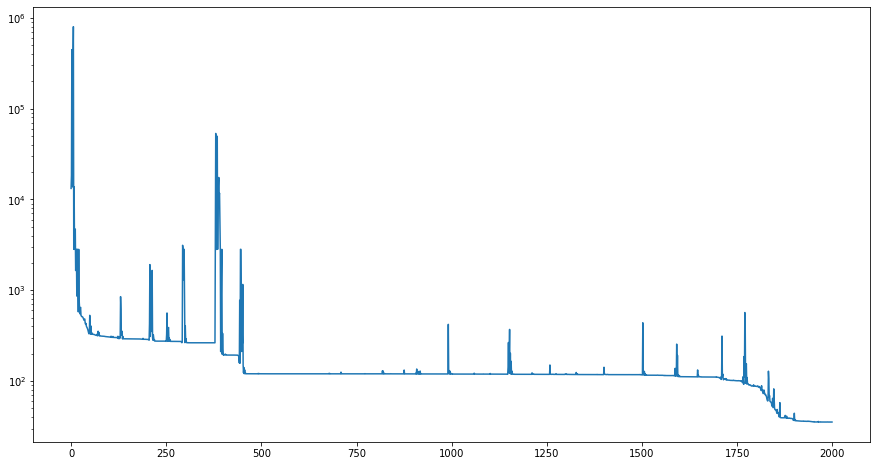

In [59]:
# Py-BOBYQA

#################################### Initialize MADX ####################################


madx1 = Madx()
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx1.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx1.input('SEQEDIT, SEQUENCE=f61d;')
madx1.input('FLATTEN;')
madx1.input('REMOVE, ELEMENT=ARBMATRIX;')
madx1.input('FLATTEN;')
madx1.input('ENDEDIT;')
madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx1.input('BRHO      := BEAM->PC * 3.3356;')
madx1.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx1.use(sequence="f61d")

madx2 = Madx()
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx2.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx2.input('SEQEDIT, SEQUENCE=f61d;')
madx2.input('FLATTEN;')
madx2.input('REMOVE, ELEMENT=ARBMATRIX;')
madx2.input('FLATTEN;')
madx2.input('ENDEDIT;')
madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx2.input('BRHO      := BEAM->PC * 3.3356;')
madx2.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx2.use(sequence="f61d")

madx3 = Madx()
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx3.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx3.input('SEQEDIT, SEQUENCE=f61d;')
madx3.input('FLATTEN;')
madx3.input('REMOVE, ELEMENT=ARBMATRIX;')
madx3.input('FLATTEN;')
madx3.input('ENDEDIT;')
madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx3.input('BRHO      := BEAM->PC * 3.3356;')
madx3.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx3.use(sequence="f61d")

madx4 = Madx()
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx4.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")
madx4.input('SEQEDIT, SEQUENCE=f61d;')
madx4.input('FLATTEN;')
madx4.input('REMOVE, ELEMENT=ARBMATRIX;')
madx4.input('FLATTEN;')
madx4.input('ENDEDIT;')
madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx4.input('BRHO      := BEAM->PC * 3.3356;')
madx4.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx4.use(sequence="f61d")

btv="f61.btv010"


progress_obj = []
progress_params = []
# Define the objective function
def f_fit(params):
    global progress_obj
    print(params)
    bety0, alfy0, eyn, sige = params
    
    betx0 = soln.x[0]
    alfx0 = soln.x[1]
    exn = soln.x[2]
    # sige = paramsH[-1][5]
    
    dx0 = 0.13
    dy0 = 0.0
    dpx0 = 0.02
    dpy0 = 0
    
    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx1.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx2.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx3.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx4.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)

        
    def worker1(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]
            
            madx1.input("kQFN1 = "+str(k_qfn01)+";")
            madx1.input("kQDN2 = "+str(k_qdn02)+";")
            madx1.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx1.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker2(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx2.input("kQFN1 = "+str(k_qfn01)+";")
            madx2.input("kQDN2 = "+str(k_qdn02)+";")
            madx2.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx2.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
    
    def worker3(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx3.input("kQFN1 = "+str(k_qfn01)+";")
            madx3.input("kQDN2 = "+str(k_qdn02)+";")
            madx3.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx3.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1
            
    def worker4(df, return_dict, return_dictV):
        i = 0
        for idx in list(df.index.values):
            k_qfn01 = df.k_qfn01[idx]
            k_qdn02 = df.k_qdn02[idx]
            k_qfn03 = df.k_qfn03[idx]

            madx4.input("kQFN1 = "+str(k_qfn01)+";")
            madx4.input("kQDN2 = "+str(k_qdn02)+";")
            madx4.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx4.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000
            
            return_dict[i] = H_sigma_madx
            return_dictV[i] = V_sigma_madx
            i += 1


    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict1 = manager.dict()
        return_dict2 = manager.dict()
        return_dict3 = manager.dict()
        return_dict4 = manager.dict()
        return_dict1V = manager.dict()
        return_dict2V = manager.dict()
        return_dict3V = manager.dict()
        return_dict4V = manager.dict()
        jobs = []
        p1 = multiprocessing.Process(target=worker1, args=(np.array_split(new_df, 4)[0], return_dict1, return_dict1V))
        p2 = multiprocessing.Process(target=worker2, args=(np.array_split(new_df, 4)[1], return_dict2, return_dict2V))
        p3 = multiprocessing.Process(target=worker3, args=(np.array_split(new_df, 4)[2], return_dict3, return_dict3V))
        p4 = multiprocessing.Process(target=worker4, args=(np.array_split(new_df, 4)[3], return_dict4, return_dict4V))

        p1.start()
        p2.start()
        p3.start()
        p4.start()

        p1.join()
        p2.join()
        p3.join()
        p4.join()
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1.values())
        madx_sigma_list.extend(return_dict2.values())
        madx_sigma_list.extend(return_dict3.values())
        madx_sigma_list.extend(return_dict4.values())
        
        new_df["sigma_H_madx"]=madx_sigma_list
        
        madx_sigma_list = []
        madx_sigma_list.extend(return_dict1V.values())
        madx_sigma_list.extend(return_dict2V.values())
        madx_sigma_list.extend(return_dict3V.values())
        madx_sigma_list.extend(return_dict4V.values())
        
        new_df["sigma_V_madx"]=madx_sigma_list
        
        
        objective = sum(
            abs(
                #new_df["sigma_H_madx"]-new_df["sigH"])**2 #+ 
                (new_df["sigma_V_madx"]-new_df["sigV"])**2
                )
                )
        

    print (objective)
    progress_obj.append(objective)
    progress_params.append(params)
    
    with open('progress_V.pickle', 'wb') as handle:
        pickle.dump(progress_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('params_V.pickle', 'wb') as handle:
        pickle.dump(progress_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return (objective)

# Define the starting point

# Open the last params that work, a way to save progress of optimisation
with open('params.pickle', 'rb') as handle:
            params = pickle.load(handle)
        
initial_guess = [33.2, -11.1, 1.5e-6, 7.53e-4]
# initial_guess = params[-1]

# Define bound constraints (lower <= x <= upper)
lower = np.array([1, -100, 0.0, 0.0])
upper = np.array([150, 100, 5.0e-5, 20.0e-4])

# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower,upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=True, scaling_within_bounds=True, rhoend=1e-8, maxfun=2000)

# Display output
print(soln)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(progress_obj)
ax.set_yscale('log')

In [60]:
# New initial conditions

bety0 = soln.x[0]
alfy0 = soln.x[1]
eyn = soln.x[2]
sige = soln.x[3]
print (betx0, bety0, alfx0, alfy0, Dx0, Dpx0, Dy0, Dpy0, exn, eyn, sige)

154.0835045206266 5.222566527078791 -36.90472944993891 0.2523074897915478 0.13 0.02 0.0 0.0 7.639770207283603e-06 3.534081877201574e-06 0.000679081344780741


In [64]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"


H_sigma_madx = []
V_sigma_madx = []
for i in range(len(new_df)):
    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

  

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(25,8))

# df_acq = df[df.Acqu==2].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="slategray", label="Acq 2")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="salmon", label="Acq 2")



ax[0].scatter(new_df.k_qfn01, new_df.sigma_H_madx, color="magenta", linewidth=2, marker="x", label="Acq 3", zorder=99)
ax[1].scatter(new_df.k_qfn01, new_df.sigma_V_madx, color="tomato", linewidth=2, marker="x", label="Acq 3", zorder=99)

# df_acq = df[df.Acqu==4].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue",s=20, label="Acq 4")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red",s=20, label="Acq 4")

# df_acq = df[df.Acqu==5].copy()
# ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, alpha=0.4, s=5, color="darkblue", label="Acq 5")
# ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, alpha=0.4, s=5, color="darkred", label="Acq 5")

#MAD-X
ax[0].scatter(new_df.k_qfn01, np.array(H_sigma_madx)*1000, color="blue", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")
ax[1].scatter(new_df.k_qfn01, np.array(V_sigma_madx)*1000, color="red", linewidth=1, alpha=0.5, facecolors='none', zorder=99, label="MAD-X")

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")


# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(Dx0,3)),
    r'$D_{y}$='+str(round(Dy0,3)),
    r'$D_{px}$='+str(round(Dpx0,3)),
    r'$D_{py}$='+str(round(Dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# fig.suptitle(f"{subset_dirnames}")
# plt.savefig("fig/quad_scan_filter_pybobqa.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight') 

PermissionError: [Errno 13] Permission denied: 'tempfile'